# AML Cell-Cell Interaction Modeling with DIISCO

In [1]:
cd ..

/Users/shouvikmani/Desktop/DIISCO/DIISCO/diisco


In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
%matplotlib inline
from matplotlib.colors import LogNorm
import seaborn as sns
#import tensorflow as tf
#from Scalable_GPRN.model.SGPRN import SGPRN
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
# reload edited modules always
%load_ext autoreload
%autoreload 2
from diisco import DIISCO
import diisco.names as names
from PIL import Image

In [3]:
torch.set_default_dtype(torch.float64)

In [4]:
days_to_dli = pd.read_csv('../../data/AML/AML_days_to_DLI.csv')
days_to_dli.head()

sample  days_to_DLI
0   MS2_          -91
1   MS4_          -16
2   MS3_           54
3   MS1_         1692
4   LB3_         -115

In [5]:
cells_df = pd.read_csv('../../data/AML/diisco_runs/run_3/diisco_all_aml_patient_cells_split_metaclusters.csv', index_col='Unnamed: 0')
# Remove doublet clusters
cells_df = cells_df[~cells_df['cluster_number'].isin([32, 34, 35, 43, 53])]
cells_df = cells_df[cells_df['dataset'].str.contains('aml')]
cells_df = pd.merge(cells_df, days_to_dli, left_on='sample', right_on='sample')
cells_df = cells_df[cells_df['days_to_DLI'] <= 1000]
cells_df

x          y sample  cluster_number dataset patient  time  \
0      11.877133  -4.378096   GD1_               8    aml1      GD   PRE   
1      11.053895  -5.831936   GD1_               8    aml1      GD   PRE   
2       0.673263  -3.220195   GD1_               1    aml1      GD   PRE   
3       1.766714  -3.783651   GD1_               1    aml1      GD   PRE   
4      -0.800807  -4.188338   GD1_               1    aml1      GD   PRE   
...          ...        ...    ...             ...     ...     ...   ...   
39271  -4.058257   0.067470   AH3_               0    aml1      AH  POST   
39272   9.655376  -3.384150   AH3_              11    aml1      AH  POST   
39273   4.689529  14.416002   AH3_               3    aml1      AH  POST   
39274  -2.095942   1.206428   AH3_               0    aml1      AH  POST   
39275   8.477838  -3.970363   AH3_              11    aml1      AH  POST   

           response aml DATA                 celltypist  cml_Y  vireo  \
0      NONRESPONDER   x  AML              Mid erythroid    0.0  tumor   
1      NONRESPONDER   x  AML              Mid erythroid    0.0  tumor   
2      NONRESPONDER   x  AML             CD16+ NK cells    0.0  tumor   
3      NONRESPONDER   x  AML             CD16+ NK cells    0.0  tumor   
4      NONRESPONDER   x  AML             CD16+ NK cells    0.0  tumor   
...             ...  ..  ...                        ...    ...    ...   
39271  NONRESPONDER   x  AML  Tem/Trm cytotoxic T cells    0.0  donor   
39272  NONRESPONDER   x  AML              Mid erythroid    0.0  tumor   
39273  NONRESPONDER   x  AML              Naive B cells    0.0  donor   
39274  NONRESPONDER   x  AML                   NK cells    0.0  donor   
39275  NONRESPONDER   x  AML              Mid erythroid    0.0  tumor   

      response_group  BM diisco_cluster  days_to_DLI  
0         AML_NR_PRE  BM       MC5_leuk         -109  
1         AML_NR_PRE  BM       MC5_leuk         -109  
2         AML_NR_PRE  BM              1         -109  
3         AML_NR_PRE  BM              1         -109  
4         AML_NR_PRE  BM              1         -109  
...              ...  ..            ...          ...  
39271    AML_NR_POST  BM              0           48  
39272    AML_NR_POST  BM       MC4_leuk           48  
39273    AML_NR_POST  BM              3           48  
39274    AML_NR_POST  BM              0           48  
39275    AML_NR_POST  BM       MC4_leuk           48  

[35039 rows x 17 columns]

## Responders model

In [6]:
cells_df_responders = cells_df[cells_df['response'] == 'RESPONDER']
cells_df_responders

x         y sample  cluster_number dataset patient time  \
2029   11.945880 -5.867986   EL1_               8    aml1      EL  PRE   
2030   -2.083548  7.255095   EL1_               2    aml1      EL  PRE   
2031   -2.955473  7.885801   EL1_               2    aml1      EL  PRE   
2032   -2.837099  7.800364   EL1_               2    aml1      EL  PRE   
2033   -2.916190  7.826178   EL1_               2    aml1      EL  PRE   
...          ...       ...    ...             ...     ...     ...  ...   
39127   7.000071  3.118854   MS4_              39    aml1      MS  PRE   
39128  10.042539  5.447767   MS4_               9    aml1      MS  PRE   
39129   5.158579  4.008451   MS4_               4    aml1      MS  PRE   
39130   6.837269  2.754053   MS4_              39    aml1      MS  PRE   
39131   5.473361  5.616415   MS4_               4    aml1      MS  PRE   

        response aml DATA                celltypist  cml_Y  vireo  \
2029   RESPONDER   x  AML             Mid erythroid    0.0  donor   
2030   RESPONDER   x  AML  Tcm/Naive helper T cells    0.0  donor   
2031   RESPONDER   x  AML  Tcm/Naive helper T cells    0.0  donor   
2032   RESPONDER   x  AML  Tcm/Naive helper T cells    0.0  donor   
2033   RESPONDER   x  AML  Tcm/Naive helper T cells    0.0  donor   
...          ...  ..  ...                       ...    ...    ...   
39127  RESPONDER   x  AML       Classical monocytes    0.0  donor   
39128  RESPONDER   x  AML             Promyelocytes    0.0  donor   
39129  RESPONDER   x  AML       Classical monocytes    0.0  donor   
39130  RESPONDER   x  AML       Classical monocytes    0.0  donor   
39131  RESPONDER   x  AML       Classical monocytes    0.0  donor   

      response_group  BM diisco_cluster  days_to_DLI  
2029       AML_R_PRE  BM            MC5          -46  
2030       AML_R_PRE  BM              2          -46  
2031       AML_R_PRE  BM              2          -46  
2032       AML_R_PRE  BM              2          -46  
2033       AML_R_PRE  BM              2          -46  
...              ...  ..            ...          ...  
39127      AML_R_PRE  BM            MC7          -16  
39128      AML_R_PRE  BM            MC2          -16  
39129      AML_R_PRE  BM            MC3          -16  
39130      AML_R_PRE  BM            MC7          -16  
39131      AML_R_PRE  BM            MC3          -16  

[25856 rows x 17 columns]

In [7]:
clusters_of_interest = {
    '0': 'T cell',
    '1': 'NK cell',
    '13': 'NK cell',
    '2': 'T cell',
    '20': 'B cell',
    '26': 'T cell',
    '3': 'B cell',
    '40': 'T cell',
    '5': 'T cell',
    'MC1': 'Myeloid',
    'MC1_leuk': 'AML',
    'MC2': 'Myeloid',
    'MC3': 'Myeloid',
    'MC4': 'Myeloid',
    'MC7': 'Myeloid'
}

colors = {
    'T cell': 'tab:blue',
    'B cell': 'tab:pink',
    'Myeloid': 'tab:red',
    'AML': 'tab:gray',
    'HSC': 'goldenrod',
    'NK cell': 'tab:purple'
}

In [8]:
sample_cluster_proportions = []

all_clusters = sorted(cells_df_responders['diisco_cluster'].unique())
for sample, sample_df in cells_df_responders.groupby('sample'):
    cluster_proportions = sample_df['diisco_cluster'].value_counts(normalize=True)
    cluster_proportions_dict = {cluster: (cluster_proportions[cluster] 
                                          if cluster in cluster_proportions
                                          else 0)
                                for cluster in all_clusters}
    sample_cluster_proportions.append({
        'sample': sample,
        'days_to_DLI': sample_df.iloc[0]['days_to_DLI'],
        **cluster_proportions_dict
    })
    
sample_cluster_proportions_all_df = pd.DataFrame(sample_cluster_proportions)
sample_cluster_proportions_all_df = sample_cluster_proportions_all_df.sort_values('days_to_DLI')
sample_cluster_proportions_all_df

sample  days_to_DLI         0         1        13        14        18  \
4    KC1_         -195  0.066818  0.019253  0.035108  0.069083  0.000000   
9    LB3_         -115  0.000000  0.000000  0.000000  0.000000  0.000000   
2    EL3_         -100  0.017084  0.039294  0.001708  0.000000  0.000000   
11   MS2_          -91  0.074738  0.153961  0.032885  0.005979  0.000000   
5    KC2_          -79  0.015385  0.020513  0.018315  0.011722  0.000000   
0    EL1_          -46  0.023729  0.105085  0.006780  0.000000  0.003390   
13   MS4_          -16  0.041611  0.095302  0.017450  0.000000  0.000000   
12   MS3_           54  0.160669  0.102929  0.011715  0.000000  0.000000   
6    KC4_          103  0.441999  0.223051  0.008952  0.000000  0.000000   
7    LB1_          258  0.430159  0.193474  0.025044  0.004233  0.000000   
8    LB2_          363  0.378436  0.119803  0.018323  0.001409  0.001409   
10   LB4_          496  0.241341  0.126993  0.009896  0.005498  0.000000   
1    EL2_          664  0.018295  0.129099  0.003797  0.002071  0.000000   
3    EL4_          727  0.029801  0.234272  0.016556  0.001656  0.000000   

           2        20        21  ...  MC2_leuk       MC3  MC3_leuk       MC4  \
4   0.004530  0.027180  0.001133  ...  0.000000  0.211778  0.000000  0.116648   
9   0.000000  0.000000  0.000000  ...  0.004181  0.000000  0.000000  0.000000   
2   0.029613  0.012528  0.010820  ...  0.019932  0.001708  0.001139  0.002278   
11  0.073244  0.008969  0.005979  ...  0.007474  0.234679  0.001495  0.013453   
5   0.005861  0.006593  0.000733  ...  0.000000  0.538462  0.000000  0.031502   
0   0.576271  0.000000  0.037288  ...  0.000000  0.023729  0.000000  0.054237   
13  0.018792  0.000000  0.006711  ...  0.000000  0.409396  0.000000  0.018792   
12  0.035146  0.008368  0.088703  ...  0.000000  0.097071  0.000000  0.174059   
6   0.015293  0.011190  0.014174  ...  0.000000  0.007087  0.000000  0.011190   
7   0.029277  0.012698  0.004938  ...  0.000000  0.067725  0.000000  0.005291   
8   0.088090  0.008457  0.003524  ...  0.000000  0.051445  0.000000  0.003524   
10  0.088510  0.019791  0.003573  ...  0.000000  0.105553  0.000000  0.008521   
1   0.046600  0.008284  0.002761  ...  0.000000  0.330342  0.000000  0.080773   
3   0.034768  0.016556  0.001656  ...  0.000000  0.369205  0.000000  0.024834   

    MC4_leuk       MC5       MC6       MC7  MC7_leuk       MC8  
4   0.000000  0.014723  0.000000  0.007928  0.000000  0.000000  
9   0.002787  0.000000  0.000000  0.000000  0.004181  0.000000  
2   0.000000  0.001708  0.000569  0.005125  0.000000  0.000000  
11  0.002990  0.000000  0.000000  0.022422  0.002990  0.001495  
5   0.000733  0.008059  0.000733  0.016117  0.000000  0.000000  
0   0.000000  0.040678  0.000000  0.006780  0.000000  0.000000  
13  0.000000  0.002685  0.001342  0.159732  0.000000  0.000000  
12  0.000000  0.001674  0.000000  0.015063  0.000000  0.000000  
6   0.000000  0.002238  0.000373  0.003357  0.000000  0.000373  
7   0.000000  0.002116  0.000705  0.003704  0.000000  0.000353  
8   0.000000  0.000000  0.000705  0.008457  0.000000  0.000000  
10  0.000000  0.002199  0.001100  0.007147  0.000000  0.000275  
1   0.000000  0.047290  0.013807  0.034864  0.000000  0.004142  
3   0.000000  0.000000  0.000000  0.020695  0.000000  0.001656  

[14 rows x 34 columns]

In [9]:
sample_cluster_proportions_df = sample_cluster_proportions_all_df[['sample', 'days_to_DLI'] 
                                                                  + list(clusters_of_interest.keys())]
sample_cluster_proportions_df

sample  days_to_DLI         0         1        13         2        20  \
4    KC1_         -195  0.066818  0.019253  0.035108  0.004530  0.027180   
9    LB3_         -115  0.000000  0.000000  0.000000  0.000000  0.000000   
2    EL3_         -100  0.017084  0.039294  0.001708  0.029613  0.012528   
11   MS2_          -91  0.074738  0.153961  0.032885  0.073244  0.008969   
5    KC2_          -79  0.015385  0.020513  0.018315  0.005861  0.006593   
0    EL1_          -46  0.023729  0.105085  0.006780  0.576271  0.000000   
13   MS4_          -16  0.041611  0.095302  0.017450  0.018792  0.000000   
12   MS3_           54  0.160669  0.102929  0.011715  0.035146  0.008368   
6    KC4_          103  0.441999  0.223051  0.008952  0.015293  0.011190   
7    LB1_          258  0.430159  0.193474  0.025044  0.029277  0.012698   
8    LB2_          363  0.378436  0.119803  0.018323  0.088090  0.008457   
10   LB4_          496  0.241341  0.126993  0.009896  0.088510  0.019791   
1    EL2_          664  0.018295  0.129099  0.003797  0.046600  0.008284   
3    EL4_          727  0.029801  0.234272  0.016556  0.034768  0.016556   

          26         3        40         5       MC1  MC1_leuk       MC2  \
4   0.000000  0.125708  0.003398  0.007928  0.091733  0.007928  0.124575   
9   0.000000  0.000000  0.000000  0.000000  0.000000  0.988153  0.000000   
2   0.000000  0.041572  0.001139  0.001708  0.332005  0.465262  0.009681   
11  0.013453  0.177877  0.028401  0.017937  0.005979  0.034380  0.017937   
5   0.000733  0.120147  0.016117  0.002930  0.013187  0.000000  0.149451   
0   0.030508  0.000000  0.023729  0.010169  0.010169  0.000000  0.006780   
13  0.045638  0.000000  0.004027  0.006711  0.010738  0.000000  0.132886   
12  0.028452  0.114644  0.093724  0.013389  0.019247  0.000000  0.023431   
6   0.089892  0.063782  0.066020  0.024991  0.001119  0.000000  0.002611   
7   0.004056  0.120459  0.028219  0.031041  0.002293  0.000000  0.015344   
8   0.014799  0.132488  0.083157  0.043693  0.002114  0.000000  0.014094   
10  0.004398  0.226498  0.018417  0.024739  0.047004  0.000000  0.031336   
1   0.008975  0.065585  0.016569  0.030376  0.017259  0.000000  0.117363   
3   0.009106  0.091060  0.003311  0.012417  0.053808  0.000000  0.055464   

         MC3       MC4       MC7  
4   0.211778  0.116648  0.007928  
9   0.000000  0.000000  0.000000  
2   0.001708  0.002278  0.005125  
11  0.234679  0.013453  0.022422  
5   0.538462  0.031502  0.016117  
0   0.023729  0.054237  0.006780  
13  0.409396  0.018792  0.159732  
12  0.097071  0.174059  0.015063  
6   0.007087  0.011190  0.003357  
7   0.067725  0.005291  0.003704  
8   0.051445  0.003524  0.008457  
10  0.105553  0.008521  0.007147  
1   0.330342  0.080773  0.034864  
3   0.369205  0.024834  0.020695

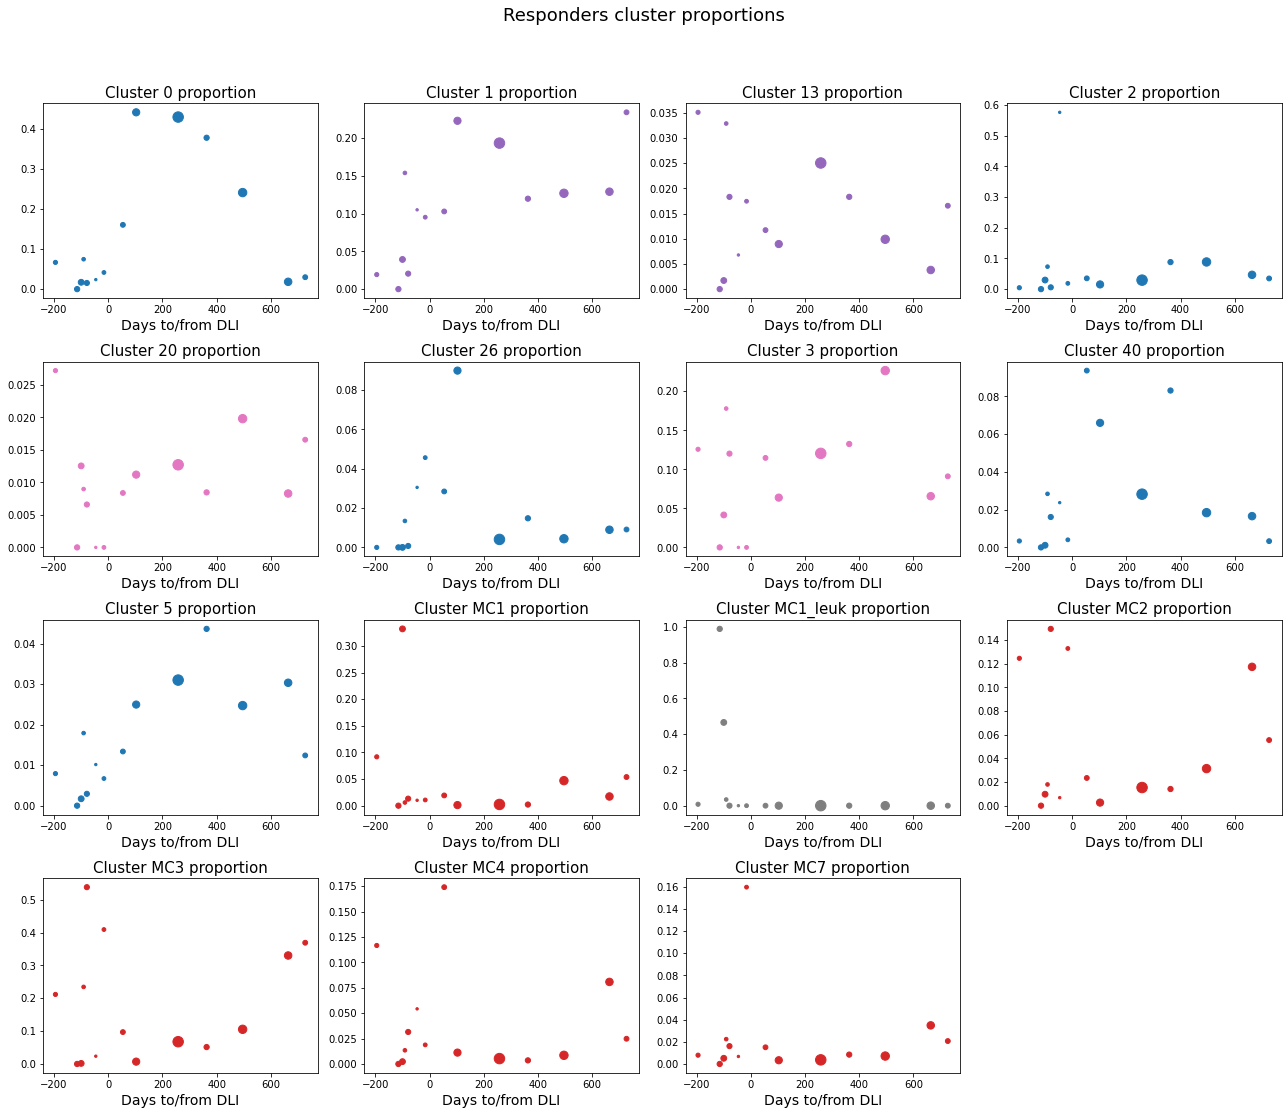

In [10]:
cells_per_sample = cells_df_responders['sample'].value_counts(normalize=True)[sample_cluster_proportions_df['sample']]

plt.figure(figsize=(18, 18))
for i, cluster in enumerate(clusters_of_interest):
    color = colors[list(clusters_of_interest.values())[i]]
    plt.subplot(5, 4, i+1)
    plt.scatter(sample_cluster_proportions_df['days_to_DLI'], 
                sample_cluster_proportions_df[cluster], 
                s=cells_per_sample*500, 
                color=color)
    plt.title(f'Cluster {cluster} proportion', fontsize=15)
    plt.xlabel('Days to/from DLI', fontsize=14)
plt.suptitle(f'Responders cluster proportions', y=1.03, fontsize=18)
plt.tight_layout()
plt.savefig('../../figures/AML/run_3/cell_type_proportions_R.eps', bbox_inches='tight')

In [11]:
cluster_means = sample_cluster_proportions_df[clusters_of_interest].mean()
cluster_std_devs = sample_cluster_proportions_df[clusters_of_interest].std()
sample_cluster_proportions_df.loc[:, clusters_of_interest] -= cluster_means
sample_cluster_proportions_df.loc[:, clusters_of_interest] /= cluster_std_devs
sample_cluster_proportions_df

/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_29180/858897236.py:1: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  cluster_means = sample_cluster_proportions_df[clusters_of_interest].mean()
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_29180/858897236.py:2: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  cluster_std_devs = sample_cluster_proportions_df[clusters_of_interest].std()
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_29180/858897236.py:3: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  sample_cluster_proportions_df.loc[:, clusters_of_interest] -= cluster_means
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_29180/858897236.py:3: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a 

sample  days_to_DLI         0         1        13         2        20  \
4    KC1_         -195 -0.435516 -1.246089  1.880741 -0.476618  2.226978   
9    LB3_         -115 -0.841046 -1.505746 -1.363005 -0.507382 -1.305296   
2    EL3_         -100 -0.737358 -0.975793 -1.205156 -0.306282  0.322882   
11   MS2_          -91 -0.387444  0.570717  1.675377 -0.009985 -0.139751   
5    KC2_          -79 -0.747674 -1.229091  0.329201 -0.467581 -0.448428   
0    EL1_          -46 -0.697031 -0.088475 -0.736602  3.406071 -1.305296   
13   MS4_          -16 -0.588502 -0.220414  0.249247 -0.379766 -1.305296   
12   MS3_           54  0.134089 -0.117552 -0.280560 -0.268702 -0.217779   
6    KC4_          103  1.841536  1.502529 -0.535901 -0.403528  0.148918   
7    LB1_          258  1.769673  1.103630  0.950930 -0.308563  0.344967   
8    LB2_          363  1.455755  0.110024  0.329916  0.090838 -0.206283   
10   LB4_          496  0.623703  0.206998 -0.448712  0.093690  1.266720   
1    EL2_          664 -0.730011  0.235404 -1.012181 -0.190922 -0.228666   
3    EL4_          727 -0.660176  1.653858  0.166704 -0.271271  0.846331   

          26         3        40         5       MC1  MC1_leuk       MC2  \
4  -0.718134  0.505695 -0.780661 -0.643288  0.555846 -0.350651  1.348242   
9  -0.718134 -1.348074 -0.890305 -1.253274 -0.497646  3.124404 -0.906002   
2  -0.718134 -0.735030 -0.853549 -1.121818  3.315217  1.270672 -0.730819   
11 -0.177139  1.275021  0.026237  0.126911 -0.428980 -0.256874 -0.581421   
5  -0.688673  0.423684 -0.370172 -1.027793 -0.346204 -0.378755  1.798370   
0   0.508732 -1.348074 -0.124531 -0.470779 -0.380856 -0.378755 -0.783322   
13  1.117134 -1.348074 -0.760351 -0.736862 -0.374324 -0.378755  1.498625   
12  0.426029  0.342546  2.134342 -0.223044 -0.276608 -0.378755 -0.482009   
6   2.896772 -0.407501  1.240291  0.669642 -0.484795 -0.378755 -0.858756   
7  -0.555009  0.428286  0.020366  1.135152 -0.471315 -0.378755 -0.628348   
8  -0.123002  0.605675  1.793334  2.108678 -0.473366 -0.378755 -0.650958   
10 -0.541272  1.992013 -0.295962  0.650266  0.042163 -0.378755 -0.338966   
1  -0.357222 -0.380914 -0.355596  1.084036 -0.299435 -0.378755  1.217728   
3  -0.351947 -0.005250 -0.783444 -0.297827  0.120304 -0.378755  0.097635   

         MC3       MC4       MC7  
4   0.209570  1.507822 -0.351956  
9  -0.992937 -0.755460 -0.546873  
2  -0.983236 -0.711263 -0.420856  
11  0.339603 -0.494437  0.004413  
5   2.064527 -0.144240 -0.150593  
0  -0.858201  0.296890 -0.380179  
13  1.331673 -0.390846  3.380501  
12 -0.441753  2.621747 -0.176519  
6  -0.952696 -0.538347 -0.464334  
7  -0.608385 -0.652800 -0.455808  
8  -0.700826 -0.687093 -0.338946  
10 -0.393594 -0.590127 -0.371152  
1   0.882792  0.811758  0.310332  
3   1.103465 -0.273605 -0.038029

In [12]:
X = sample_cluster_proportions_df['days_to_DLI'].values.reshape(-1, 1)
X

array([[-195],
       [-115],
       [-100],
       [ -91],
       [ -79],
       [ -46],
       [ -16],
       [  54],
       [ 103],
       [ 258],
       [ 363],
       [ 496],
       [ 664],
       [ 727]])

In [13]:
Y = sample_cluster_proportions_df[clusters_of_interest].values
Y[:5]

/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_29180/2580917083.py:1: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  Y = sample_cluster_proportions_df[clusters_of_interest].values


array([[-0.43551611, -1.24608851,  1.88074118, -0.47661841,  2.22697814,
        -0.71813416,  0.50569451, -0.78066061, -0.64328833,  0.55584645,
        -0.35065079,  1.34824164,  0.2095698 ,  1.50782232, -0.35195609],
       [-0.8410459 , -1.50574633, -1.36300536, -0.50738168, -1.30529613,
        -0.71813416, -1.34807424, -0.89030466, -1.25327388, -0.49764632,
         3.12440379, -0.90600246, -0.99293692, -0.75546028, -0.54687271],
       [-0.73735797, -0.97579282, -1.20515606, -0.30628169,  0.3228825 ,
        -0.71813416, -0.73503026, -0.85354851, -1.12181832,  3.31521744,
         1.27067172, -0.73081889, -0.98323621, -0.71126278, -0.4208556 ],
       [-0.3874435 ,  0.57071716,  1.67537741, -0.00998467, -0.13975122,
        -0.1771392 ,  1.2750214 ,  0.02623651,  0.12691122, -0.42898042,
        -0.25687376, -0.58142072,  0.33960275, -0.49443735,  0.00441292],
       [-0.74767359, -1.2290913 ,  0.32920083, -0.46758099, -0.4484285 ,
        -0.68867339,  0.42368407, -0.37017152, 

Text(0.5, 1.02, 'Interaction prior variances for responders based on receptor-ligand expression')

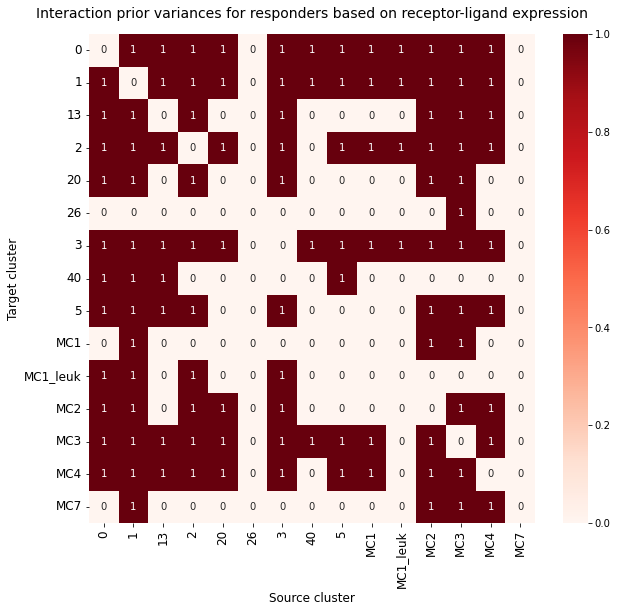

In [14]:
W_prior_variance = np.load('../../data/AML/responder_interaction_prior_run_3.npy')

plt.figure(figsize=(10, 9))
ax = sns.heatmap(W_prior_variance, cmap="Reds", annot=True)
ax.set_yticklabels(clusters_of_interest, fontsize=12, rotation=0)
ax.set_xticklabels(clusters_of_interest, fontsize=12, rotation=90)
plt.xlabel('Source cluster', fontsize=12)
plt.ylabel('Target cluster', fontsize=12)
plt.title('Interaction prior variances for responders based on receptor-ligand expression', 
          fontsize=14, y=1.02)

In [15]:
timepoints = torch.tensor(X)
proportions = torch.tensor(Y)
prior_matrix = torch.tensor(W_prior_variance)
n_timepoints, n_cell_types = proportions.shape

print('timepoints.shape:', timepoints.shape)
print('cell_types.shape:', proportions.shape)

timepoints.shape: torch.Size([14, 1])
cell_types.shape: torch.Size([14, 15])


In [16]:
def unscale(proportions, cluster_index): 
    return np.clip((proportions * 
                    cluster_std_devs.values[cluster_index] + 
                    cluster_means.values[cluster_index]), 
                   0, 1)

In [17]:
# mean of all intervals
lengthscale = np.mean(np.abs(X - X.T))
lengthscale

319.3775510204082

In [18]:
hyper_init_vals = {
    names.LENGTHSCALE_F: 300,
    names.LENGTHSCALE_W: 300,
    names.SIGMA_F: 1,
    names.VARIANCE_F: 10,
    names.SIGMA_W: 0.1,
    names.VARIANCE_W: 10,
    names.SIGMA_Y: 0.5,
}
print(hyper_init_vals)

{'lengthscale_f': 300, 'lengthscale_w': 300, 'sigma_f': 1, 'variance_f': 10, 'sigma_w': 0.1, 'variance_w': 10, 'sigma_y': 0.5}


In [19]:
model = DIISCO(lambda_matrix=prior_matrix, hypers_init_vals=hyper_init_vals, verbose=True, verbose_freq=100)

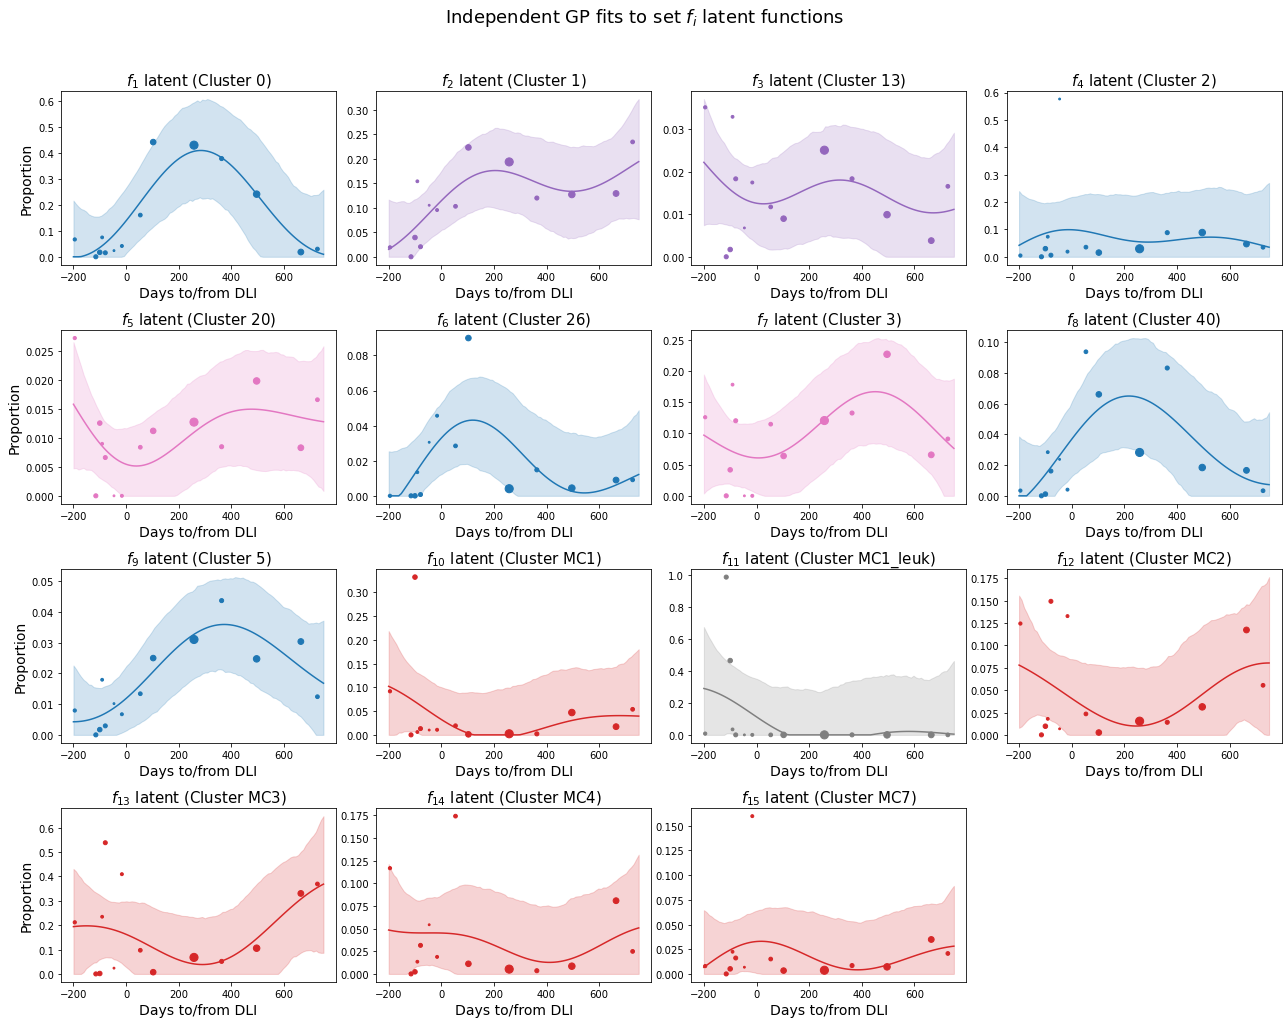

In [21]:
model.fit_and_set_f_prior_params(timepoints=timepoints, proportions=proportions, hypers=model.hypers_init_vals)
eval_timepoints = torch.linspace(-200, 750, 100).view(-1, 1)

n_samples = 1000
n_eval_timepoints = eval_timepoints.shape[0]
f_prior_np = model.sample_f_prior(eval_timepoints, n_samples=n_samples)

plt.figure(figsize=(18, 30))
for i, cluster in enumerate(clusters_of_interest):
    eval_timepoints_np = eval_timepoints.detach().numpy()
    f_prior_cell_type_np = f_prior_np[:, i, :].detach().numpy()
    mean = unscale(f_prior_cell_type_np.mean(axis=0), i)
    upper = unscale(np.percentile(f_prior_cell_type_np, 97.5, axis=0), i)
    lower = unscale(np.percentile(f_prior_cell_type_np, 2.5, axis=0), i)
    plt.subplot(9, 4, i+1)
    color = colors[list(clusters_of_interest.values())[i]]
#     color = 'tab:blue'
    plt.plot(eval_timepoints_np, mean, c=color)
    plt.scatter(timepoints, unscale(proportions[:, i].flatten().detach().numpy(), i), 
                c=color, s=cells_per_sample*300)
    plt.fill_between(eval_timepoints_np.flatten(), lower, upper, color=color, alpha=0.2)
    plt.title('$f_{%s}$ latent (Cluster %s)' % (i+1, cluster), fontsize=15)
    plt.xlabel('Days to/from DLI', fontsize=14)
    if i%4==0: plt.ylabel('Proportion', fontsize=14)
plt.subplots_adjust(hspace=0.4)
plt.suptitle('Independent GP fits to set $f_i$ latent functions', fontsize=18, y=1.01)
plt.tight_layout()

In [22]:
model.fit(timepoints, 
          proportions, 
          n_iter=300000, 
          lr=0.00001, 
          hypers_to_optim=[], 
          guide="MultivariateNormalFactorized")

[iteration 0001] loss: 534248.6845
[iteration 0101] loss: 337838.9846
[iteration 0201] loss: 316660.2282
[iteration 0301] loss: 302313.3196
[iteration 0401] loss: 293133.5898
[iteration 0501] loss: 285360.3043
[iteration 0601] loss: 277854.9916
[iteration 0701] loss: 272197.8796
[iteration 0801] loss: 267510.5287
[iteration 0901] loss: 263927.2620
[iteration 1001] loss: 260690.1999
[iteration 1101] loss: 256710.1328
[iteration 1201] loss: 253437.8747
[iteration 1301] loss: 250767.2804
[iteration 1401] loss: 247316.0543
[iteration 1501] loss: 245229.4278
[iteration 1601] loss: 241686.2497
[iteration 1701] loss: 239485.1179
[iteration 1801] loss: 237233.0951
[iteration 1901] loss: 234287.4719
[iteration 2001] loss: 231878.2026
[iteration 2101] loss: 231609.8953
[iteration 2201] loss: 228750.3269
[iteration 2301] loss: 227533.4956
[iteration 2401] loss: 225024.2176
[iteration 2501] loss: 222044.6284
[iteration 2601] loss: 221158.5220
[iteration 2701] loss: 220821.3783
[iteration 2801] los

[iteration 23101] loss: 119461.4100
[iteration 23201] loss: 119785.4206
[iteration 23301] loss: 119098.9141
[iteration 23401] loss: 119574.4510
[iteration 23501] loss: 119636.3315
[iteration 23601] loss: 119140.9632
[iteration 23701] loss: 119566.0970
[iteration 23801] loss: 118501.9909
[iteration 23901] loss: 118009.5136
[iteration 24001] loss: 118433.1452
[iteration 24101] loss: 119169.0487
[iteration 24201] loss: 118697.2369
[iteration 24301] loss: 118489.9494
[iteration 24401] loss: 117535.1084
[iteration 24501] loss: 117816.4150
[iteration 24601] loss: 117770.8128
[iteration 24701] loss: 118487.3102
[iteration 24801] loss: 118350.1364
[iteration 24901] loss: 117544.0160
[iteration 25001] loss: 117299.2414
[iteration 25101] loss: 118022.9339
[iteration 25201] loss: 117347.0267
[iteration 25301] loss: 117747.7451
[iteration 25401] loss: 118147.9317
[iteration 25501] loss: 116958.4882
[iteration 25601] loss: 116560.2995
[iteration 25701] loss: 117356.2964
[iteration 25801] loss: 1178

[iteration 45901] loss: 102434.8245
[iteration 46001] loss: 102083.1477
[iteration 46101] loss: 102755.4464
[iteration 46201] loss: 102765.8537
[iteration 46301] loss: 103359.1300
[iteration 46401] loss: 103414.2235
[iteration 46501] loss: 102542.8280
[iteration 46601] loss: 102030.9319
[iteration 46701] loss: 103002.4978
[iteration 46801] loss: 101596.4976
[iteration 46901] loss: 103322.6023
[iteration 47001] loss: 102578.5673
[iteration 47101] loss: 101879.9595
[iteration 47201] loss: 101604.7919
[iteration 47301] loss: 102013.0295
[iteration 47401] loss: 102839.1273
[iteration 47501] loss: 102117.5635
[iteration 47601] loss: 102316.3951
[iteration 47701] loss: 102176.0595
[iteration 47801] loss: 101729.9759
[iteration 47901] loss: 101353.3314
[iteration 48001] loss: 101333.7954
[iteration 48101] loss: 101442.6569
[iteration 48201] loss: 101555.8851
[iteration 48301] loss: 102233.4956
[iteration 48401] loss: 101742.8419
[iteration 48501] loss: 102649.6253
[iteration 48601] loss: 1017

[iteration 69201] loss: 96010.5327
[iteration 69301] loss: 95210.2872
[iteration 69401] loss: 96050.0177
[iteration 69501] loss: 95347.9084
[iteration 69601] loss: 94862.3003
[iteration 69701] loss: 96193.1454
[iteration 69801] loss: 94943.3132
[iteration 69901] loss: 95293.7904
[iteration 70001] loss: 96785.0688
[iteration 70101] loss: 95628.7638
[iteration 70201] loss: 95863.2905
[iteration 70301] loss: 95285.5867
[iteration 70401] loss: 95117.2178
[iteration 70501] loss: 96252.8132
[iteration 70601] loss: 95343.0303
[iteration 70701] loss: 95811.6820
[iteration 70801] loss: 95425.7255
[iteration 70901] loss: 95881.6684
[iteration 71001] loss: 95723.5128
[iteration 71101] loss: 95457.9307
[iteration 71201] loss: 95629.0809
[iteration 71301] loss: 95995.8114
[iteration 71401] loss: 94883.3764
[iteration 71501] loss: 95301.6351
[iteration 71601] loss: 95984.0294
[iteration 71701] loss: 95377.1145
[iteration 71801] loss: 95187.7105
[iteration 71901] loss: 95476.5420
[iteration 72001] lo

[iteration 92701] loss: 90337.0871
[iteration 92801] loss: 91561.2451
[iteration 92901] loss: 90997.1665
[iteration 93001] loss: 90878.7343
[iteration 93101] loss: 91442.9107
[iteration 93201] loss: 91171.6401
[iteration 93301] loss: 91335.3444
[iteration 93401] loss: 91072.7927
[iteration 93501] loss: 91290.5078
[iteration 93601] loss: 91089.3155
[iteration 93701] loss: 90596.9049
[iteration 93801] loss: 91303.4500
[iteration 93901] loss: 91295.2738
[iteration 94001] loss: 90606.9065
[iteration 94101] loss: 90465.1182
[iteration 94201] loss: 91295.3510
[iteration 94301] loss: 92060.4548
[iteration 94401] loss: 90197.3390
[iteration 94501] loss: 90574.6934
[iteration 94601] loss: 91140.2543
[iteration 94701] loss: 90770.9030
[iteration 94801] loss: 91379.8791
[iteration 94901] loss: 90506.3957
[iteration 95001] loss: 90254.6835
[iteration 95101] loss: 91008.9578
[iteration 95201] loss: 90801.2044
[iteration 95301] loss: 90546.7849
[iteration 95401] loss: 90032.3946
[iteration 95501] lo

[iteration 115701] loss: 88192.5435
[iteration 115801] loss: 87071.1362
[iteration 115901] loss: 87635.2148
[iteration 116001] loss: 87479.1354
[iteration 116101] loss: 86837.4227
[iteration 116201] loss: 87548.5165
[iteration 116301] loss: 86937.4596
[iteration 116401] loss: 87187.1731
[iteration 116501] loss: 86975.8224
[iteration 116601] loss: 87627.5808
[iteration 116701] loss: 87145.8785
[iteration 116801] loss: 86917.1623
[iteration 116901] loss: 87488.2477
[iteration 117001] loss: 86903.4160
[iteration 117101] loss: 87262.1024
[iteration 117201] loss: 86823.4726
[iteration 117301] loss: 87264.3077
[iteration 117401] loss: 87263.0083
[iteration 117501] loss: 87855.4337
[iteration 117601] loss: 86825.9719
[iteration 117701] loss: 87263.1472
[iteration 117801] loss: 86216.2383
[iteration 117901] loss: 87876.4068
[iteration 118001] loss: 86537.7545
[iteration 118101] loss: 87123.8943
[iteration 118201] loss: 87060.9449
[iteration 118301] loss: 87450.0147
[iteration 118401] loss: 875

[iteration 138501] loss: 84375.2343
[iteration 138601] loss: 84986.6460
[iteration 138701] loss: 85625.8565
[iteration 138801] loss: 85614.8997
[iteration 138901] loss: 85209.0221
[iteration 139001] loss: 86646.9145
[iteration 139101] loss: 85826.5878
[iteration 139201] loss: 84759.6346
[iteration 139301] loss: 84940.7234
[iteration 139401] loss: 84704.7728
[iteration 139501] loss: 85379.6516
[iteration 139601] loss: 85187.6288
[iteration 139701] loss: 84774.3141
[iteration 139801] loss: 84774.6895
[iteration 139901] loss: 84203.6261
[iteration 140001] loss: 85220.8272
[iteration 140101] loss: 85701.9335
[iteration 140201] loss: 85080.1779
[iteration 140301] loss: 84883.7532
[iteration 140401] loss: 85412.4634
[iteration 140501] loss: 84782.9638
[iteration 140601] loss: 85367.8405
[iteration 140701] loss: 84825.1146
[iteration 140801] loss: 84351.1475
[iteration 140901] loss: 85645.3601
[iteration 141001] loss: 84934.6513
[iteration 141101] loss: 85248.0710
[iteration 141201] loss: 848

[iteration 161301] loss: 83284.9422
[iteration 161401] loss: 83913.8161
[iteration 161501] loss: 83194.5876
[iteration 161601] loss: 83708.9513
[iteration 161701] loss: 83279.8134
[iteration 161801] loss: 82221.0714
[iteration 161901] loss: 84119.4842
[iteration 162001] loss: 83932.1700
[iteration 162101] loss: 82746.9240
[iteration 162201] loss: 82590.6457
[iteration 162301] loss: 83535.6966
[iteration 162401] loss: 83622.0737
[iteration 162501] loss: 83447.5934
[iteration 162601] loss: 83499.1112
[iteration 162701] loss: 83232.4211
[iteration 162801] loss: 83410.2939
[iteration 162901] loss: 83084.3932
[iteration 163001] loss: 83474.8489
[iteration 163101] loss: 83115.7428
[iteration 163201] loss: 83792.0928
[iteration 163301] loss: 82874.1803
[iteration 163401] loss: 83485.3724
[iteration 163501] loss: 83180.6178
[iteration 163601] loss: 83203.0197
[iteration 163701] loss: 83505.3977
[iteration 163801] loss: 84072.4977
[iteration 163901] loss: 83718.7898
[iteration 164001] loss: 843

[iteration 184101] loss: 82243.6460
[iteration 184201] loss: 82643.8342
[iteration 184301] loss: 82491.5431
[iteration 184401] loss: 81864.1534
[iteration 184501] loss: 83256.8600
[iteration 184601] loss: 82634.6209
[iteration 184701] loss: 82384.8671
[iteration 184801] loss: 82529.8849
[iteration 184901] loss: 82156.0023
[iteration 185001] loss: 82880.0441
[iteration 185101] loss: 81981.3926
[iteration 185201] loss: 81867.9100
[iteration 185301] loss: 82961.3554
[iteration 185401] loss: 82714.3236
[iteration 185501] loss: 83109.1276
[iteration 185601] loss: 82713.2397
[iteration 185701] loss: 82940.8153
[iteration 185801] loss: 83081.4309
[iteration 185901] loss: 82444.9502
[iteration 186001] loss: 81948.5140
[iteration 186101] loss: 82803.6335
[iteration 186201] loss: 82009.2908
[iteration 186301] loss: 81774.7806
[iteration 186401] loss: 82245.2367
[iteration 186501] loss: 82850.4416
[iteration 186601] loss: 82213.5773
[iteration 186701] loss: 81942.1157
[iteration 186801] loss: 822

[iteration 206901] loss: 81311.7894
[iteration 207001] loss: 81034.6706
[iteration 207101] loss: 80991.6828
[iteration 207201] loss: 81885.0095
[iteration 207301] loss: 81067.8634
[iteration 207401] loss: 81214.9379
[iteration 207501] loss: 81082.5600
[iteration 207601] loss: 80851.1333
[iteration 207701] loss: 80925.8769
[iteration 207801] loss: 80736.1065
[iteration 207901] loss: 81247.5929
[iteration 208001] loss: 81610.6461
[iteration 208101] loss: 81796.1428
[iteration 208201] loss: 81467.0530
[iteration 208301] loss: 80617.0898
[iteration 208401] loss: 80992.9744
[iteration 208501] loss: 81457.4054
[iteration 208601] loss: 81756.2346
[iteration 208701] loss: 80869.4953
[iteration 208801] loss: 80975.9446
[iteration 208901] loss: 81411.2833
[iteration 209001] loss: 81249.5962
[iteration 209101] loss: 80247.3741
[iteration 209201] loss: 81739.9402
[iteration 209301] loss: 80596.4497
[iteration 209401] loss: 81513.5041
[iteration 209501] loss: 81848.8841
[iteration 209601] loss: 807

[iteration 229701] loss: 80747.0237
[iteration 229801] loss: 80783.9596
[iteration 229901] loss: 79719.6000
[iteration 230001] loss: 79917.5388
[iteration 230101] loss: 79942.5230
[iteration 230201] loss: 80215.5324
[iteration 230301] loss: 80719.1412
[iteration 230401] loss: 80706.9912
[iteration 230501] loss: 80202.4515
[iteration 230601] loss: 79447.3791
[iteration 230701] loss: 80717.8111
[iteration 230801] loss: 79715.6580
[iteration 230901] loss: 79875.2728
[iteration 231001] loss: 80248.2218
[iteration 231101] loss: 80260.1603
[iteration 231201] loss: 80126.1415
[iteration 231301] loss: 79797.6928
[iteration 231401] loss: 79836.8648
[iteration 231501] loss: 80839.1879
[iteration 231601] loss: 79820.0166
[iteration 231701] loss: 80071.1619
[iteration 231801] loss: 80342.5343
[iteration 231901] loss: 80100.6027
[iteration 232001] loss: 79935.4460
[iteration 232101] loss: 79825.6796
[iteration 232201] loss: 80084.0469
[iteration 232301] loss: 80227.5649
[iteration 232401] loss: 799

[iteration 252501] loss: 79287.2818
[iteration 252601] loss: 79387.5290
[iteration 252701] loss: 79407.3624
[iteration 252801] loss: 79656.2739
[iteration 252901] loss: 79637.2369
[iteration 253001] loss: 78864.0543
[iteration 253101] loss: 79324.8325
[iteration 253201] loss: 79280.3474
[iteration 253301] loss: 79197.2752
[iteration 253401] loss: 79313.6117
[iteration 253501] loss: 79106.7799
[iteration 253601] loss: 78969.6650
[iteration 253701] loss: 79050.5234
[iteration 253801] loss: 79615.1766
[iteration 253901] loss: 79202.4028
[iteration 254001] loss: 79633.3485
[iteration 254101] loss: 79590.7576
[iteration 254201] loss: 79258.0547
[iteration 254301] loss: 80206.3892
[iteration 254401] loss: 79297.6891
[iteration 254501] loss: 79367.2430
[iteration 254601] loss: 79329.7151
[iteration 254701] loss: 78633.1082
[iteration 254801] loss: 79186.6902
[iteration 254901] loss: 80025.2174
[iteration 255001] loss: 79006.6305
[iteration 255101] loss: 79521.1062
[iteration 255201] loss: 789

[iteration 275301] loss: 78603.4368
[iteration 275401] loss: 77559.1774
[iteration 275501] loss: 78667.4365
[iteration 275601] loss: 78566.0901
[iteration 275701] loss: 79146.9191
[iteration 275801] loss: 77384.5993
[iteration 275901] loss: 78896.1475
[iteration 276001] loss: 77463.2582
[iteration 276101] loss: 78533.4537
[iteration 276201] loss: 78836.6482
[iteration 276301] loss: 78414.7779
[iteration 276401] loss: 78423.5641
[iteration 276501] loss: 78681.7315
[iteration 276601] loss: 79038.7074
[iteration 276701] loss: 78511.2589
[iteration 276801] loss: 78019.4727
[iteration 276901] loss: 78255.8777
[iteration 277001] loss: 77894.3118
[iteration 277101] loss: 78411.7008
[iteration 277201] loss: 78210.0446
[iteration 277301] loss: 78074.5937
[iteration 277401] loss: 78692.1803
[iteration 277501] loss: 78304.0224
[iteration 277601] loss: 77688.1920
[iteration 277701] loss: 78058.2874
[iteration 277801] loss: 78904.2367
[iteration 277901] loss: 77880.5942
[iteration 278001] loss: 781

[iteration 298101] loss: 77415.7054
[iteration 298201] loss: 77943.2572
[iteration 298301] loss: 77424.7575
[iteration 298401] loss: 77377.1930
[iteration 298501] loss: 77629.4532
[iteration 298601] loss: 78024.6519
[iteration 298701] loss: 77392.1740
[iteration 298801] loss: 77657.4342
[iteration 298901] loss: 77086.1959
[iteration 299001] loss: 76467.4273
[iteration 299101] loss: 77526.1986
[iteration 299201] loss: 78107.9023
[iteration 299301] loss: 78391.4495
[iteration 299401] loss: 78078.4107
[iteration 299501] loss: 77677.8763
[iteration 299601] loss: 77641.1131
[iteration 299701] loss: 77775.6584
[iteration 299801] loss: 77649.9712
[iteration 299901] loss: 77817.0063


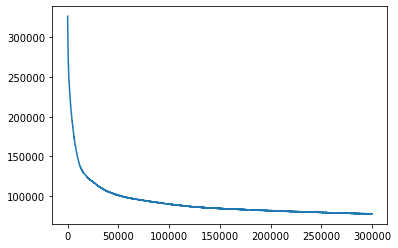

In [23]:
start = 100
loss_moving_avg = np.convolve(model.losses[start:], np.ones(100)/100, 'valid')
plt.plot(loss_moving_avg)

In [24]:
predict_timepoints = torch.linspace(timepoints.min(), timepoints.max(), 100).reshape(-1, 1)
means = model.get_means(predict_timepoints)

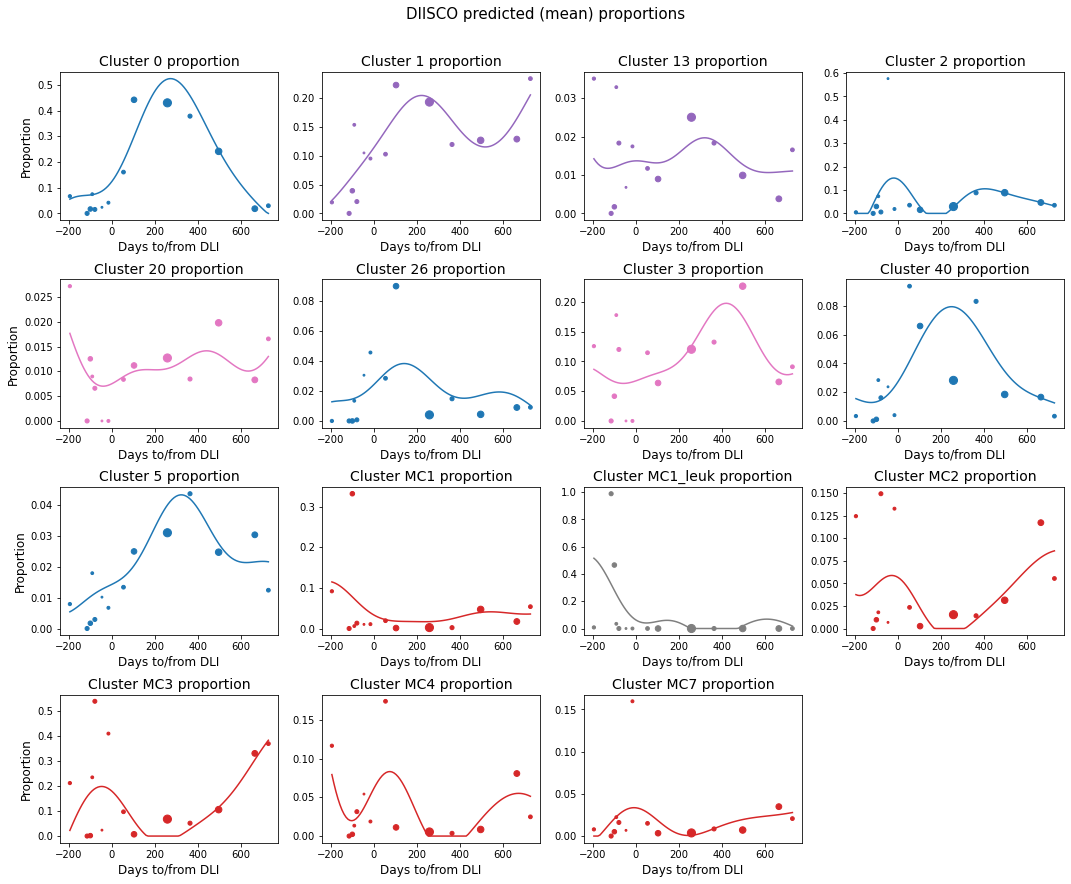

In [25]:
from mimic_alpha.mimic_alpha import colorAlpha_to_rgb
import matplotlib.colors as colors2

plt.figure(figsize=(18, 18))
for i, cluster in enumerate(clusters_of_interest):
    mean = unscale(means['Y'][:, i], i)
    x = predict_timepoints.squeeze().numpy()
    plt.subplot(5, 4, i+1)
    color = colors[list(clusters_of_interest.values())[i]]
    plt.plot(x, mean, c=color)
    plt.scatter(timepoints, unscale(proportions[:, i], i), c=color, s=cells_per_sample*300)
    plt.title(f'Cluster {cluster} proportion', fontsize=14)
    plt.xlabel('Days to/from DLI', fontsize=12)
    if i%4==0: plt.ylabel('Proportion', fontsize=12)
    
plt.suptitle('DIISCO predicted (mean) proportions', fontsize=15, y=0.93)
plt.subplots_adjust(hspace=0.4)

In [26]:
predict_timepoints = torch.linspace(timepoints.min(), timepoints.max(), 100).reshape(-1, 1)
samples = model.sample(predict_timepoints, 
                 n_samples=10000, 
                 n_samples_per_latent=10,
                 include_emission_variance=False)

100%|██████████████████████████████████████| 10000/10000 [03:22<00:00, 49.41it/s]


In [27]:
W_samples_predict = samples['W']
f_samples_predict = samples['F']
y_samples_predict = samples['Y']

In [28]:
y_preds = y_samples_predict.mean(axis=0).numpy()

np.save('../../data/AML/run_3_X_R.npy', predict_timepoints.numpy())
np.save('../../data/AML/run_3_y_preds_R.npy', y_preds)
np.save('../../data/AML/run_3_W_samples_predict_R.npy', W_samples_predict)
np.save('../../data/AML/run_3_y_samples_predict_R.npy', y_samples_predict)

In [19]:
predict_timepoints = np.load('../../data/AML/run_3_X_R.npy')
y_preds = np.load('../../data/AML/run_3_y_preds_R.npy')
W_samples_predict = np.load('../../data/AML/run_3_W_samples_predict_R.npy')
y_samples_predict = np.load('../../data/AML/run_3_y_samples_predict_R.npy')

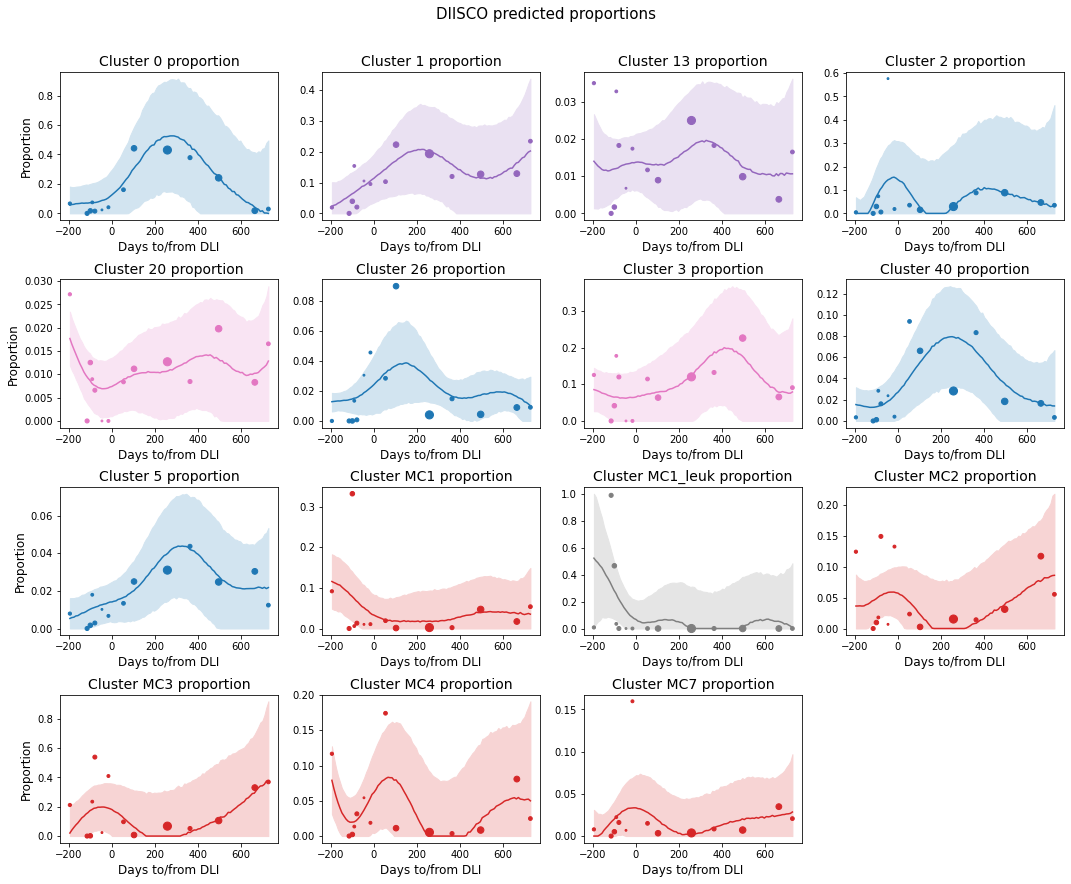

In [20]:
from mimic_alpha.mimic_alpha import colorAlpha_to_rgb
import matplotlib.colors as colors2

plt.figure(figsize=(18, 18))
for i, cluster in enumerate(clusters_of_interest):
    cell_type_samples = y_samples_predict[:, :, i]
    mean = unscale(cell_type_samples.mean(axis=0), i)
    x = predict_timepoints.squeeze()
    percentile_75 = unscale(np.percentile(cell_type_samples, 84, axis=0), i)
    percentile_25 = unscale(np.percentile(cell_type_samples, 16, axis=0), i)
    plt.subplot(5, 4, i+1)
    color = colors[list(clusters_of_interest.values())[i]]
    plt.plot(x, mean, c=color)
    color_with_alpha = list(colors2.to_rgb(color)) + [0.2]
    color_without_alpha = colorAlpha_to_rgb([color_with_alpha], 0.2)
    plt.fill_between(x, percentile_25, percentile_75, color=color_without_alpha)
    plt.scatter(timepoints, unscale(proportions[:, i], i), c=color, s=cells_per_sample*300)
    plt.title(f'Cluster {cluster} proportion', fontsize=14)
    plt.xlabel('Days to/from DLI', fontsize=12)
    if i%4==0: plt.ylabel('Proportion', fontsize=12)
    
plt.suptitle('DIISCO predicted proportions', fontsize=15, y=0.93)
plt.subplots_adjust(hspace=0.4)
plt.savefig('../../figures/AML/run_3/diisco_predictions_R.eps')

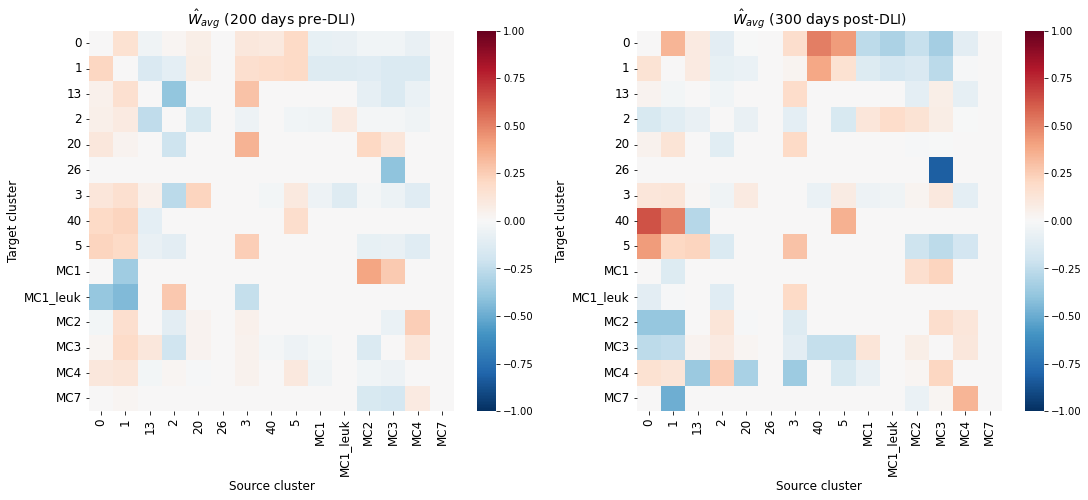

In [21]:
annot = False
vmin = -1
vmax = 1

X_200_days_pre_dli_index = np.where(predict_timepoints > -200)[0][0]
X_post_dli_index = np.where(predict_timepoints > 0)[0][0]
X_300_days_post_dli_index = np.where(predict_timepoints > 300)[0][0]
X_post_dli_index

W = W_samples_predict.mean(axis=0)
W_pre_dli = W[X_200_days_pre_dli_index:X_post_dli_index]
W_post_dli = W[X_post_dli_index:X_300_days_post_dli_index]
W_pre_dli_avg_over_time = np.mean(W_pre_dli, axis=0)
W_post_dli_avg_over_time = np.mean(W_post_dli, axis=0)

plt.figure(figsize=(18, 7))
plt.subplot(1, 2, 1)
ax = sns.heatmap(W_pre_dli_avg_over_time, cmap="RdBu_r", annot=annot, 
                 fmt='.2f', vmin=vmin, vmax=vmax, center=0)
ax.set_yticklabels(clusters_of_interest, fontsize=12)
ax.set_xticklabels(clusters_of_interest, fontsize=12)
plt.xlabel('Source cluster', fontsize=12)
plt.ylabel('Target cluster', fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.title('$\hat{W}_{avg}$ (200 days pre-DLI)', fontsize=14)

plt.subplot(1, 2, 2)
ax = sns.heatmap(W_post_dli_avg_over_time, cmap="RdBu_r", annot=annot, 
                 fmt='.2f', vmin=vmin, vmax=vmax, center=0)
ax.set_yticklabels(clusters_of_interest, fontsize=12)
ax.set_xticklabels(clusters_of_interest, fontsize=12)
plt.xlabel('Source cluster', fontsize=12)
plt.ylabel('Target cluster', fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.title('$\hat{W}_{avg}$ (300 days post-DLI)', fontsize=14)
plt.savefig('../../figures/AML/run_3/W_avg_pre_post_DLI_R.eps')

In [22]:
y_samples_predict_unscaled = [unscale(y_samples_predict[:, :, i], i) 
                              for i in range(len(clusters_of_interest))]
y_samples_predict_unscaled = np.dstack(y_samples_predict_unscaled)
y_samples_predict_unscaled.shape

(10000, 100, 15)

In [23]:
y_mu = y_samples_predict_unscaled.mean(axis=0).mean(axis=0)
y_sigma = y_samples_predict_unscaled.std(axis=0).mean(axis=0)

y_mu_over_sigma = np.array(y_mu) / np.array(y_sigma)

(0.0, 2.0)

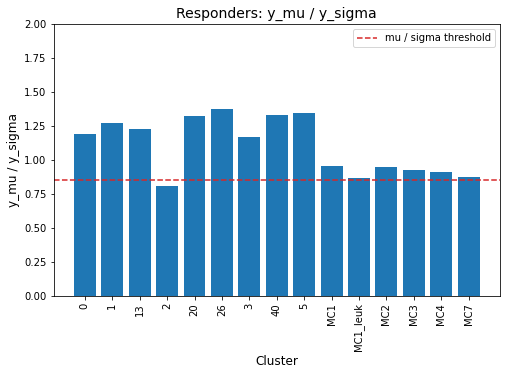

In [24]:
plt.figure(figsize=(8, 5))
mu_sigma_threshold = 0.85
plt.bar(range(len(y_mu_over_sigma)), y_mu_over_sigma)
plt.xticks(range(len(y_mu_over_sigma)), clusters_of_interest, rotation=90)
plt.axhline(mu_sigma_threshold, c='tab:red', linestyle='--', label='mu / sigma threshold')
plt.legend(loc='upper right')
plt.title("Responders: y_mu / y_sigma", fontsize=14)
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("y_mu / y_sigma", fontsize=12)
plt.ylim([0, 2])

In [25]:
mean_abs_W_threshold = 0.3
max_abs_W_threshold = 1
mu_sigma_threshold = 0.85

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


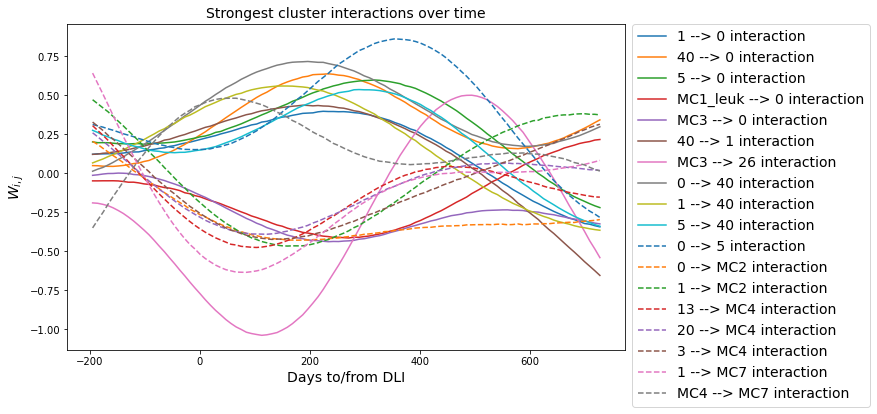

In [26]:
plt.figure(figsize=(10, 6))
linestyles = ['-', '--', ":"]
lines = 0
for i, cluster_i in enumerate(clusters_of_interest):
    for j, cluster_j in enumerate(clusters_of_interest):
        # a sustained strong interaction over the entire post-DLI time period
        sustained = np.abs(W_post_dli_avg_over_time[i, j]) > mean_abs_W_threshold
        # a transient strong interaction during the post-DLI time period
        transient = (np.abs(W_post_dli[:, i, j]) > max_abs_W_threshold).any()
        confident = (y_mu_over_sigma[i] > mu_sigma_threshold and
                     y_mu_over_sigma[j] > mu_sigma_threshold)
        show_line = (sustained or transient) and confident
        if show_line and i!= j:
            plt.plot(predict_timepoints.squeeze(),
                     W[:, i, j],
                     linestyle=linestyles[lines//10],
                     label='%s --> %s interaction' % (cluster_j, cluster_i))
            lines += 1
plt.legend(bbox_to_anchor=(1, 1.02), loc='upper left', fontsize=14)
plt.title('Strongest cluster interactions over time', fontsize=14)
plt.ylabel('$W_{i, j}$', fontsize=14)
plt.xlabel('Days to/from DLI', fontsize=14)
plt.savefig('../../figures/AML/run_3/W_over_time_R_top_interactions.eps', bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


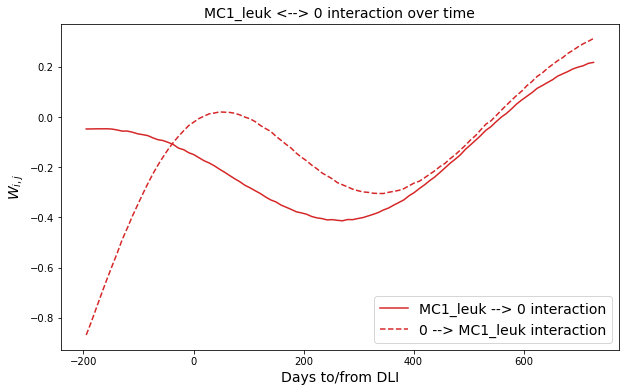

In [27]:
i = 0
j = 10
cluster_i = list(clusters_of_interest.keys())[i]
cluster_j = list(clusters_of_interest.keys())[j]

plt.figure(figsize=(10, 6))
plt.plot(predict_timepoints.squeeze(),
         W[:, i, j],
         linestyle='-',
         color='tab:red',
         label='%s --> %s interaction' % (cluster_j, cluster_i))
plt.plot(predict_timepoints.squeeze(),
         W[:, j, i],
         linestyle='--',
         color='tab:red',
         label='%s --> %s interaction' % (cluster_i, cluster_j))

plt.legend(loc='lower right', fontsize=14)
plt.title('MC1_leuk <--> 0 interaction over time', fontsize=14)
plt.ylabel('$W_{i, j}$', fontsize=14)
plt.xlabel('Days to/from DLI', fontsize=14)
plt.savefig('../../figures/AML/run_3/W_MC1_leuk_and_0_over_time_R.eps', bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


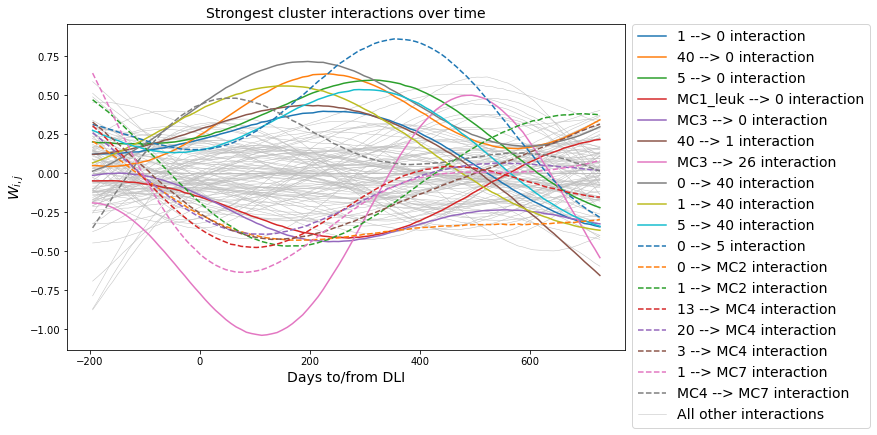

In [28]:
plt.figure(figsize=(10, 6))
linestyles = ['-', '--', ":"]
lines = 0
for i, cluster_i in enumerate(clusters_of_interest):
    for j, cluster_j in enumerate(clusters_of_interest):
        # a sustained strong interaction over the entire post-DLI time period
        sustained = np.abs(W_post_dli_avg_over_time[i, j]) > mean_abs_W_threshold
        # a transient strong interaction during the post-DLI time period
        transient = (np.abs(W_post_dli[:, i, j]) > max_abs_W_threshold).any()
        confident = (y_mu_over_sigma[i] > mu_sigma_threshold and
                     y_mu_over_sigma[j] > mu_sigma_threshold)
        show_line = (sustained or transient) and confident
        if show_line and i!= j:
            plt.plot(predict_timepoints.squeeze(), 
                     W[:, i, j],
                     linestyles[lines//10],
                     label='%s --> %s interaction' % (cluster_j, cluster_i))
            lines += 1
            
once = False
color = 'tab:gray'
color_with_alpha = list(colors2.to_rgb(color)) + [0.5]
color_without_alpha = colorAlpha_to_rgb([color_with_alpha], 0.5)
for i, cluster_i in enumerate(clusters_of_interest):
    for j, cluster_j in enumerate(clusters_of_interest):
        # a sustained strong interaction over the entire post-DLI time period
        sustained = np.abs(W_post_dli_avg_over_time[i, j]) > mean_abs_W_threshold
        # a transient strong interaction during the post-DLI time period
        transient = (np.abs(W_post_dli[:, i, j]) > max_abs_W_threshold).any()
        confident = (y_mu_over_sigma[i] > mu_sigma_threshold and
                     y_mu_over_sigma[j] > mu_sigma_threshold)
        show_line = (sustained or transient) and confident
        if not show_line and i != j:
            plt.plot(predict_timepoints.squeeze(), 
                     W[:, i, j],
                     color=color_without_alpha[0],
                     linewidth=0.5, zorder=-100,
                     label='All other interactions' if not once else '')
            once = True

plt.legend(bbox_to_anchor=(1, 1.02), loc='upper left', fontsize=14)
plt.title('Strongest cluster interactions over time', fontsize=14)
plt.ylabel('$W_{i, j}$', fontsize=14)
plt.xlabel('Days to/from DLI', fontsize=14)
plt.savefig('../../figures/AML/run_3/W_over_time_R_all_interactions.eps', bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


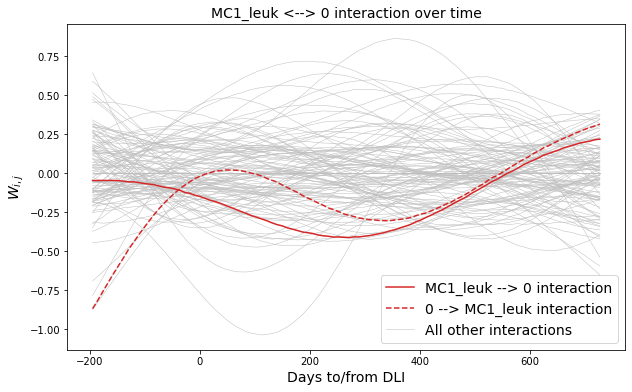

In [29]:
i = 0
j = 10
cluster_i = list(clusters_of_interest.keys())[i]
cluster_j = list(clusters_of_interest.keys())[j]

plt.figure(figsize=(10, 6))
plt.plot(predict_timepoints.squeeze(),
         W[:, i, j],
         linestyle='-',
         color='tab:red',
         label='%s --> %s interaction' % (cluster_j, cluster_i))
plt.plot(predict_timepoints.squeeze(),
         W[:, j, i],
         linestyle='--',
         color='tab:red',
         label='%s --> %s interaction' % (cluster_i, cluster_j))

once = False
color = 'tab:gray'
color_with_alpha = list(colors2.to_rgb(color)) + [0.5]
color_without_alpha = colorAlpha_to_rgb([color_with_alpha], 0.5)
for i, cluster_i in enumerate(clusters_of_interest):
    for j, cluster_j in enumerate(clusters_of_interest):
        # a sustained strong interaction over the entire post-DLI time period
        sustained = np.abs(W_post_dli_avg_over_time[i, j]) > mean_abs_W_threshold
        # a transient strong interaction during the post-DLI time period
        transient = (np.abs(W_post_dli[:, i, j]) > max_abs_W_threshold).any()
        confident = (y_mu_over_sigma[i] > mu_sigma_threshold and
                     y_mu_over_sigma[j] > mu_sigma_threshold)
        show_line = (sustained or transient) and confident
        if i != j:
            plt.plot(predict_timepoints.squeeze(), 
                     W[:, i, j],
                     color=color_without_alpha[0],
                     linewidth=0.5, zorder=-100,
                     label='All other interactions' if not once else '')
            once = True

plt.legend(loc='lower right', fontsize=14)
plt.title('MC1_leuk <--> 0 interaction over time', fontsize=14)
plt.ylabel('$W_{i, j}$', fontsize=14)
plt.xlabel('Days to/from DLI', fontsize=14)
plt.savefig('../../figures/AML/run_3/W_MC1_leuk_and_0_over_time_R_all_interactions.eps', bbox_inches='tight')

In [30]:
import py4cytoscape as p4c
p4c.cytoscape_ping()
p4c.cytoscape_version_info()

/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


You are connected to Cytoscape!


{'apiVersion': 'v1',
 'cytoscapeVersion': '3.9.1',
 'automationAPIVersion': '1.6.0',
 'py4cytoscapeVersion': '1.5.0'}

In [31]:
W_pre_dli_avg_edge_list = []

for row, target_cluster in enumerate(clusters_of_interest.keys()):
    for col, source_cluster in enumerate(clusters_of_interest.keys()):
        sustained = np.abs(W_post_dli_avg_over_time[row, col]) > mean_abs_W_threshold
        transient = (np.abs(W_post_dli[:, row, col]) > max_abs_W_threshold).any()
        confident = (y_mu_over_sigma[row] > mu_sigma_threshold and
                     y_mu_over_sigma[col] > mu_sigma_threshold)
        show_edge = (sustained or transient) and confident
        W_pre_dli_avg_edge_list.append({
            'Source cluster': source_cluster,
            'Target cluster': target_cluster,
            'Interaction weight': W_pre_dli_avg_over_time[row, col],
            'abs(Interaction weight)': np.abs(W_pre_dli_avg_over_time[row, col]) * show_edge,
            'sign(Interaction weight)': np.sign(W_pre_dli_avg_over_time[row, col])
        })

W_pre_dli_avg_edge_list_df = pd.DataFrame(W_pre_dli_avg_edge_list)

W_avg_edge_list_df = W_pre_dli_avg_edge_list_df
W_avg_edge_list_df.columns = ['source', 'target', 'Interaction weight', 
                              'abs(Interaction weight)', 'sign(Interaction weight)']
W_avg_edge_list_df[['source', 'target']] = W_avg_edge_list_df[['source', 'target']].astype(str)
W_avg_edge_list_df = W_avg_edge_list_df[W_avg_edge_list_df['source'] != W_avg_edge_list_df['target']]
W_avg_edge_list_df.head()

source target  Interaction weight  abs(Interaction weight)  \
1      1      0            0.152900                   0.1529   
2     13      0           -0.041763                   0.0000   
3      2      0            0.017407                   0.0000   
4     20      0            0.068799                   0.0000   
5     26      0            0.000000                   0.0000   

   sign(Interaction weight)  
1                       1.0  
2                      -1.0  
3                       1.0  
4                       1.0  
5                       0.0

In [32]:
# Display 0 --> MC1_leuk edge
edge_0_to_MC1_leuk = ((W_avg_edge_list_df['source'] == '0') & 
                      (W_avg_edge_list_df['target'] == 'MC1_leuk'))
W_avg_edge_list_df.loc[edge_0_to_MC1_leuk, 'abs(Interaction weight)'] = \
    np.abs(W_avg_edge_list_df.loc[edge_0_to_MC1_leuk, 'Interaction weight'])

W_avg_edge_list_df.loc[edge_0_to_MC1_leuk]

source    target  Interaction weight  abs(Interaction weight)  \
150      0  MC1_leuk           -0.388844                 0.388844   

     sign(Interaction weight)  
150                      -1.0

In [33]:
y_preds_pre_dli = y_preds[X_200_days_pre_dli_index:X_post_dli_index]
y_preds_avg_pre_dli = y_preds_pre_dli.mean(axis=0)
y_preds_avg_pre_dli = [unscale(y, i) for i, y in enumerate(y_preds_avg_pre_dli)]
y_preds_avg_pre_dli_df = pd.DataFrame(y_preds_avg_pre_dli,
                                      index=clusters_of_interest, 
                                      columns=['Inferred cluster proportion'])

y_preds_avg_df = y_preds_avg_pre_dli_df.reset_index()
y_preds_avg_df.columns = ['id', 'Inferred cluster proportion']
y_preds_avg_df['id'] = y_preds_avg_df['id'].astype(str)
y_preds_avg_df

id  Inferred cluster proportion
0          0                     0.076446
1          1                     0.063633
2         13                     0.012614
3          2                     0.054490
4         20                     0.010078
5         26                     0.015946
6          3                     0.069612
7         40                     0.016029
8          5                     0.009884
9        MC1                     0.078000
10  MC1_leuk                     0.290575
11       MC2                     0.047930
12       MC3                     0.145665
13       MC4                     0.038126
14       MC7                     0.017662

In [34]:
# Reduce clutter by removing nodes without edges
not_connected_cluster_ids = []
for cluster in clusters_of_interest:
    sum_abs_interaction_weights = (
        W_avg_edge_list_df.loc[(W_avg_edge_list_df['source'] == str(cluster)) | 
                               (W_avg_edge_list_df['target'] == str(cluster)), 
                               'abs(Interaction weight)'].sum()
    )
    if sum_abs_interaction_weights == 0: 
        not_connected_cluster_ids.append(str(cluster))

        
# Remove nodes with less than 1% cluster proportion
clusters_with_low_prop = y_preds_avg_df.loc[y_preds_avg_df['Inferred cluster proportion'] < 0.01, 'id']

clusters_to_remove = not_connected_cluster_ids + list(clusters_with_low_prop)
W_avg_edge_list_df = W_avg_edge_list_df[~(W_avg_edge_list_df['source'].isin(clusters_to_remove)) & 
                                        ~(W_avg_edge_list_df['target'].isin(clusters_to_remove))]
y_preds_avg_df = y_preds_avg_df[~(y_preds_avg_df['id'].isin(clusters_to_remove))]

In [35]:
# No MC5_leuk cells present in responders, so setting proportion to 0
# to align network diagram with NR
sample_cluster_proportions_all_df['MC5_leuk'] = 0

In [36]:
# Add clusters from NR interaction network diagram
clusters_to_add = {'MC5_leuk': 'AML', '2': 'T cell', '5': 'T cell'}

proportions_pre_dli_df = sample_cluster_proportions_all_df[sample_cluster_proportions_all_df['days_to_DLI'] < 0]
proportions_pre_dli_df = proportions_pre_dli_df[clusters_to_add].mean().reset_index()
proportions_pre_dli_df.columns = ['id', 'Inferred cluster proportion']
y_preds_avg_df = pd.concat([y_preds_avg_df, proportions_pre_dli_df])
y_preds_avg_df = y_preds_avg_df.sort_values('id').reset_index(drop=True)

# Add a fake 0 interactions so that cluster shows up in network diagram
for cluster in clusters_to_add:
    W_avg_edge_list_df = W_avg_edge_list_df.append({
        'source': cluster, 
        'target': '0', 
        'Interaction weight': 0,
        'abs(Interaction weight)': 0,
        'sign(Interaction weight)': 1
    }, ignore_index=True)
    W_avg_edge_list_df = W_avg_edge_list_df.append({
        'source': cluster, 
        'target': '1', 
        'Interaction weight': 0,
        'abs(Interaction weight)': 0,
        'sign(Interaction weight)': 1
    }, ignore_index=True)

/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_29180/1624672406.py:5: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  proportions_pre_dli_df = proportions_pre_dli_df[clusters_to_add].mean().reset_index()
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_29180/1624672406.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W_avg_edge_list_df = W_avg_edge_list_df.append({
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_29180/1624672406.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W_avg_edge_list_df = W_avg_edge_list_df.append({
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_29180/1624672406.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

In [37]:
colors_hex = {
    'T cell': '#397BBC',
    'B cell': '#AA589C',
    'Myeloid': '#A2342F',
    'AML': '#78787C',
    'NK cell': '#675FA5'
}

clusters_to_colors_hex = [
    colors_hex[clusters_of_interest[cluster]] if cluster in clusters_of_interest
    else colors_hex[clusters_to_add[cluster]]
    for cluster in y_preds_avg_df['id']
]

In [38]:
cluster_to_annotation = {
    '0': 'C0: CD8 ZNF683_Hi CTL',
    '1': 'C1: NK',
    '13': 'C13: NK',
    '2': 'C2: CD4 T_PE',
    '20': 'C20: Plasma B',
    '26': 'C26: CD8 Activ.',
    '3': 'C3: Naïve B',
    '40': 'C40: CD8 T_EM',
    '5': 'C5: CD8 T_EX',
    'MC1_leuk': 'MC1 Leuk',
    'MC2': 'MC2',
    'MC3': 'MC3',
    'MC4': 'MC4',
    'MC5_leuk': 'MC5 Leuk',
    'MC7': 'MC7'
}

Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.


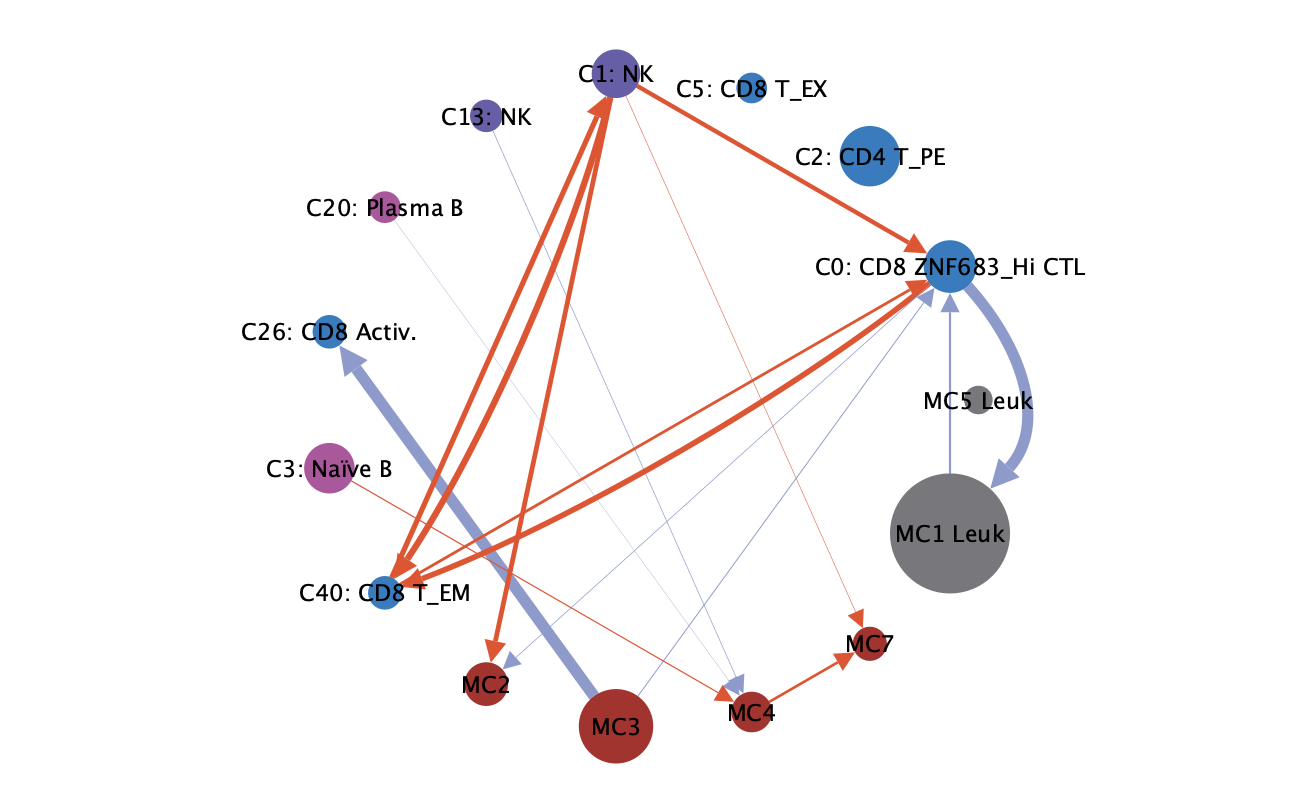

In [63]:
p4c.create_network_from_data_frames(nodes=y_preds_avg_df, 
                                    edges=W_avg_edge_list_df, 
                                    title="AML Responders Pre DLI", 
                                    collection="AML Responders Pre DLI")

# Default styles
p4c.layout_network('circular')
# p4c.layout_copycat(source_network='AML Responders Pre DLI', 
#                    target_network='AML Responders Pre DLI')
p4c.set_node_shape_default('ELLIPSE')
p4c.set_node_width_default(20)
p4c.set_node_height_default(20)
p4c.set_node_font_size_default(8)
p4c.set_edge_target_arrow_shape_default('DELTA_SHORT_1')

# Map style properties to node/edge attributes
p4c.set_node_color_mapping(table_column='shared name', 
                           table_column_values=list(y_preds_avg_df['id']), 
                           colors=clusters_to_colors_hex, 
                           mapping_type='d')
p4c.set_node_size_mapping(table_column='SUID',
                          table_column_values=list(p4c.get_table_columns()['SUID']),
                          sizes=list(p4c.get_table_columns()['Inferred cluster proportion'] * 110 + 10))
p4c.set_node_label_bypass(node_names=list(cluster_to_annotation.keys()), 
                          new_labels=list(cluster_to_annotation.values()))
p4c.set_edge_color_mapping(table_column='sign(Interaction weight)',
                           table_column_values=[-1.0, 1.0],
                           colors=['#8E9BCA', '#DD5634'])
p4c.set_edge_target_arrow_color_mapping(table_column='sign(Interaction weight)',
                                        table_column_values=[-1.0, 1.0],
                                        colors=['#8E9BCA', '#DD5634'])
p4c.set_edge_line_width_mapping(table_column='abs(Interaction weight)', 
                                table_column_values=[W_avg_edge_list_df['abs(Interaction weight)'].min(), 
                                                     W_avg_edge_list_df['abs(Interaction weight)'].max()],
                                widths=[W_avg_edge_list_df['abs(Interaction weight)'].min() * 10, 
                                        W_avg_edge_list_df['abs(Interaction weight)'].max() * 10], 
                                mapping_type='c')
edges_to_hide = [f'{row.source} (interacts with) {row.target}' 
                 for i, row in W_avg_edge_list_df.iterrows()
                 if row['abs(Interaction weight)'] == 0]
p4c.hide_edges(edges_to_hide)

p4c.set_network_center_bypass(0, 0)
p4c.set_network_zoom_bypass(1.75)
# p4c.export_image(f'../../figures/AML/run_3/interaction_network_R_pre_avg.svg', type='SVG')
# p4c.export_image(f'../../figures/AML/run_3/interaction_network_R_pre_avg.png', type='PNG')
p4c.notebook_export_show_image()

In [39]:
W_post_dli_avg_edge_list = []

for row, target_cluster in enumerate(clusters_of_interest.keys()):
    for col, source_cluster in enumerate(clusters_of_interest.keys()):
        sustained = np.abs(W_post_dli_avg_over_time[row, col]) > mean_abs_W_threshold
        transient = (np.abs(W_post_dli[:, row, col]) > max_abs_W_threshold).any()
        confident = (y_mu_over_sigma[row] > mu_sigma_threshold and
                     y_mu_over_sigma[col] > mu_sigma_threshold)
        show_edge = (sustained or transient) and confident
        W_post_dli_avg_edge_list.append({
            'Source cluster': source_cluster,
            'Target cluster': target_cluster,
            'Interaction weight': W_post_dli_avg_over_time[row, col],
            'abs(Interaction weight)': np.abs(W_post_dli_avg_over_time[row, col]) * show_edge,
            'sign(Interaction weight)': np.sign(W_post_dli_avg_over_time[row, col])
        })
        
W_post_dli_avg_edge_list_df = pd.DataFrame(W_post_dli_avg_edge_list)

W_avg_edge_list_df = W_post_dli_avg_edge_list_df
W_avg_edge_list_df.columns = ['source', 'target', 'Interaction weight', 
                              'abs(Interaction weight)', 'sign(Interaction weight)']
W_avg_edge_list_df[['source', 'target']] = W_avg_edge_list_df[['source', 'target']].astype(str)
W_avg_edge_list_df = W_avg_edge_list_df[W_avg_edge_list_df['source'] != W_avg_edge_list_df['target']]
W_avg_edge_list_df.head()

source target  Interaction weight  abs(Interaction weight)  \
1      1      0            0.337006                 0.337006   
2     13      0            0.092813                 0.000000   
3      2      0           -0.104953                 0.000000   
4     20      0           -0.004523                 0.000000   
5     26      0            0.000000                 0.000000   

   sign(Interaction weight)  
1                       1.0  
2                       1.0  
3                      -1.0  
4                      -1.0  
5                       0.0

In [40]:
# Display 0 --> MC1_leuk edge
edge_0_to_MC1_leuk = ((W_avg_edge_list_df['source'] == '0') & 
                      (W_avg_edge_list_df['target'] == 'MC1_leuk'))
W_avg_edge_list_df.loc[edge_0_to_MC1_leuk, 'abs(Interaction weight)'] = \
    np.abs(W_avg_edge_list_df.loc[edge_0_to_MC1_leuk, 'Interaction weight'])

W_avg_edge_list_df.loc[edge_0_to_MC1_leuk]

source    target  Interaction weight  abs(Interaction weight)  \
150      0  MC1_leuk           -0.104749                 0.104749   

     sign(Interaction weight)  
150                      -1.0

In [41]:
y_preds_post_dli = y_preds[X_post_dli_index:X_300_days_post_dli_index]
y_preds_avg_post_dli = y_preds_post_dli.mean(axis=0)
y_preds_avg_post_dli = [unscale(y, i) for i, y in enumerate(y_preds_avg_post_dli)]
y_preds_avg_post_dli_df = pd.DataFrame(y_preds_avg_post_dli,
                                      index=clusters_of_interest, 
                                      columns=['Inferred cluster proportion'])

y_preds_avg_df = y_preds_avg_post_dli_df.reset_index()
y_preds_avg_df.columns = ['id', 'Inferred cluster proportion']
y_preds_avg_df['id'] = y_preds_avg_df['id'].astype(str)
y_preds_avg_df

id  Inferred cluster proportion
0          0                     0.369499
1          1                     0.177597
2         13                     0.014999
3          2                     0.039360
4         20                     0.009895
5         26                     0.032235
6          3                     0.093689
7         40                     0.061369
8          5                     0.027210
9        MC1                     0.019825
10  MC1_leuk                     0.038182
11       MC2                     0.014307
12       MC3                     0.040915
13       MC4                     0.044812
14       MC7                     0.013617

In [42]:
# Reduce clutter by removing nodes without edges
not_connected_cluster_ids = []
for cluster in clusters_of_interest:
    sum_abs_interaction_weights = (
        W_avg_edge_list_df.loc[(W_avg_edge_list_df['source'] == str(cluster)) | 
                               (W_avg_edge_list_df['target'] == str(cluster)), 
                               'abs(Interaction weight)'].sum()
    )
    if sum_abs_interaction_weights == 0: 
        not_connected_cluster_ids.append(str(cluster))

        
# Remove nodes with less than 1% cluster proportion
clusters_with_low_prop = y_preds_avg_df.loc[y_preds_avg_df['Inferred cluster proportion'] < 0.01, 'id']

clusters_to_remove = not_connected_cluster_ids + list(clusters_with_low_prop)
W_avg_edge_list_df = W_avg_edge_list_df[~(W_avg_edge_list_df['source'].isin(clusters_to_remove)) & 
                                        ~(W_avg_edge_list_df['target'].isin(clusters_to_remove))]
y_preds_avg_df = y_preds_avg_df[~(y_preds_avg_df['id'].isin(clusters_to_remove))]

In [43]:
# Add clusters from NR interaction network diagram
clusters_to_add = {'MC5_leuk': 'AML', '2': 'T cell', '20': 'B cell'}

proportions_post_dli_df = sample_cluster_proportions_all_df[sample_cluster_proportions_all_df['days_to_DLI'] >= 0]
proportions_post_dli_df = proportions_post_dli_df[clusters_to_add].mean().reset_index()
proportions_post_dli_df.columns = ['id', 'Inferred cluster proportion']
y_preds_avg_df = pd.concat([y_preds_avg_df, proportions_post_dli_df])
y_preds_avg_df = y_preds_avg_df.sort_values('id').reset_index(drop=True)

# Add a fake 0 interactions so that cluster shows up in network diagram
for cluster in clusters_to_add:
    W_avg_edge_list_df = W_avg_edge_list_df.append({
        'source': cluster, 
        'target': '0', 
        'Interaction weight': 0,
        'abs(Interaction weight)': 0,
        'sign(Interaction weight)': 1
    }, ignore_index=True)
    W_avg_edge_list_df = W_avg_edge_list_df.append({
        'source': cluster, 
        'target': '1', 
        'Interaction weight': 0,
        'abs(Interaction weight)': 0,
        'sign(Interaction weight)': 1
    }, ignore_index=True)

/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_29180/3212127882.py:5: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  proportions_post_dli_df = proportions_post_dli_df[clusters_to_add].mean().reset_index()
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_29180/3212127882.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W_avg_edge_list_df = W_avg_edge_list_df.append({
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_29180/3212127882.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W_avg_edge_list_df = W_avg_edge_list_df.append({
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_29180/3212127882.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

In [44]:
colors_hex = {
    'T cell': '#397BBC',
    'B cell': '#AA589C',
    'Myeloid': '#A2342F',
    'AML': '#78787C',
    'NK cell': '#675FA5'
}

clusters_to_colors_hex = [
    colors_hex[clusters_of_interest[cluster]] if cluster in clusters_of_interest
    else colors_hex[clusters_to_add[cluster]]
    for cluster in y_preds_avg_df['id']
]


In [45]:
cluster_to_annotation = {
    '0': 'C0: CD8 ZNF683_Hi CTL',
    '1': 'C1: NK',
    '13': 'C13: NK',
    '2': 'C2: CD4 T_PE',
    '20': 'C20: Plasma B',
    '26': 'C26: CD8 Activ.',
    '3': 'C3: Naïve B',
    '40': 'C40: CD8 T_EM',
    '5': 'C5: CD8 T_EX',
    'MC1_leuk': 'MC1 Leuk',
    'MC2': 'MC2',
    'MC3': 'MC3',
    'MC4': 'MC4',
    'MC5_leuk': 'MC5 Leuk',
    'MC7': 'MC7'
}

Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.


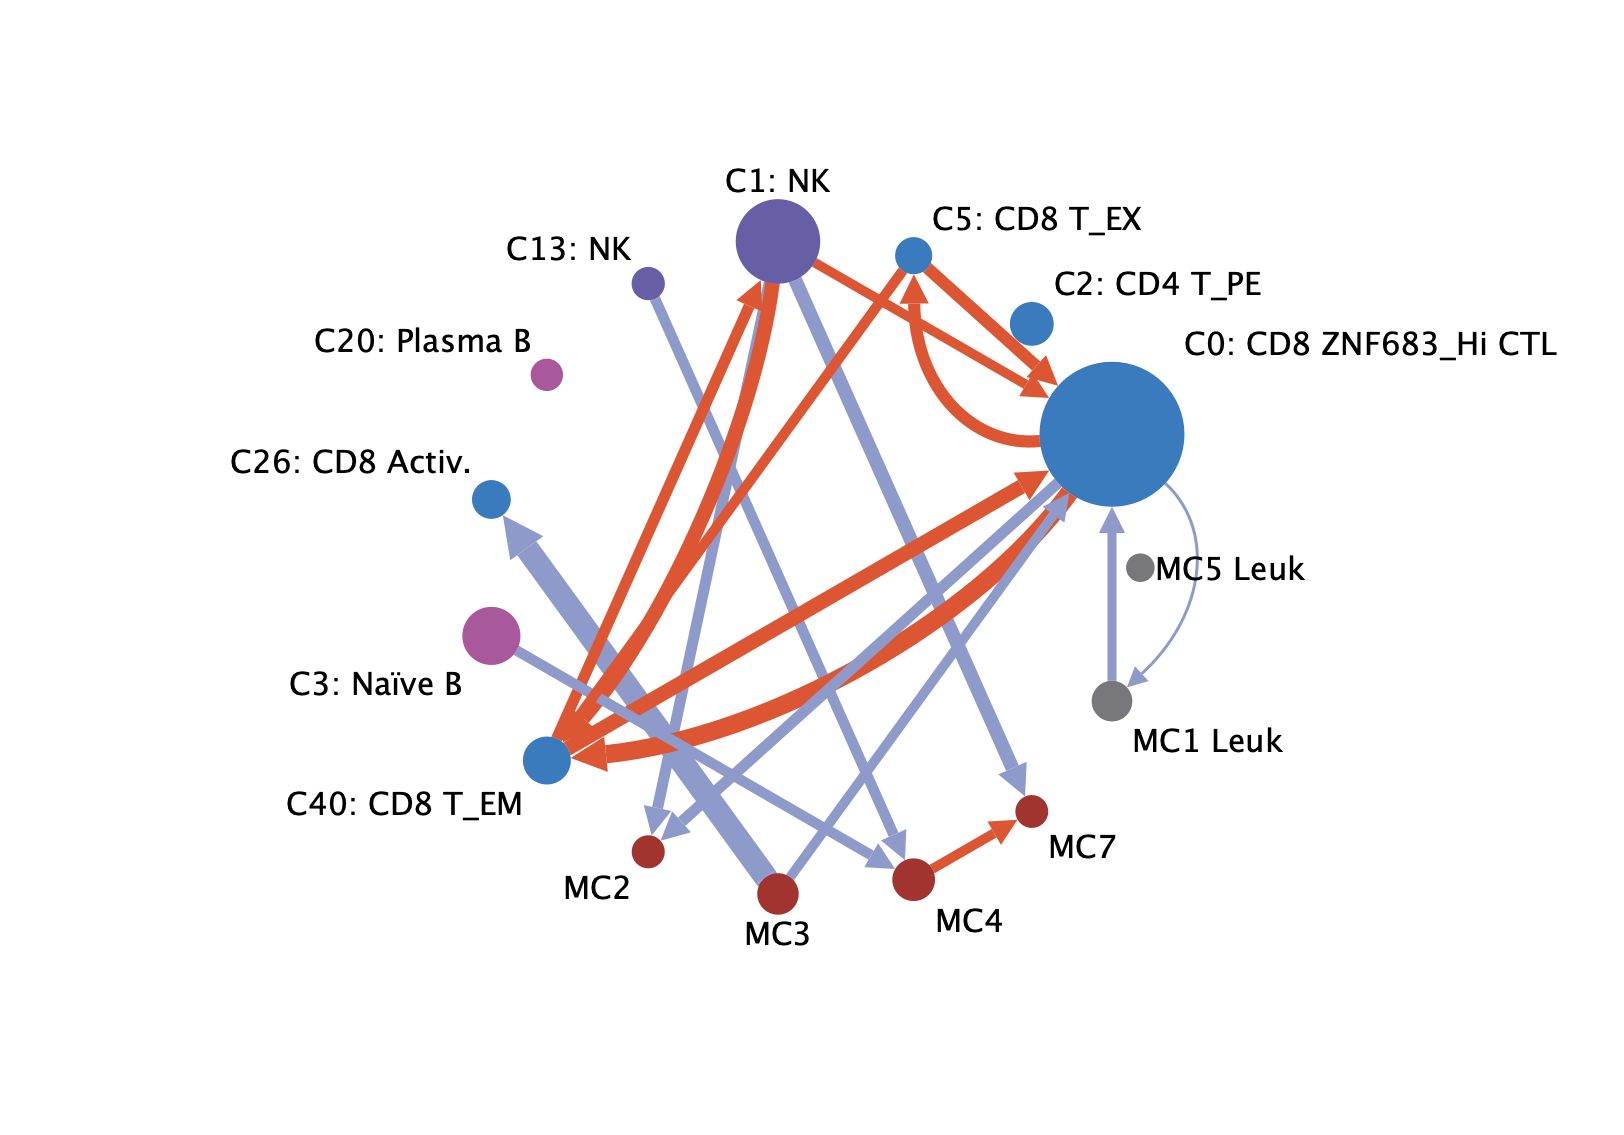

In [82]:
p4c.create_network_from_data_frames(nodes=y_preds_avg_df, 
                                    edges=W_avg_edge_list_df, 
                                    title="AML Responders Post DLI", 
                                    collection="AML Responders Post DLI")

# Default styles
p4c.layout_copycat(source_network='AML Responders Pre DLI', 
                   target_network='AML Responders Post DLI')
p4c.set_node_shape_default('ELLIPSE')
p4c.set_node_width_default(20)
p4c.set_node_height_default(20)
p4c.set_node_font_size_default(11)
p4c.set_edge_target_arrow_shape_default('DELTA_SHORT_1')

# Map style properties to node/edge attributes
p4c.set_node_color_mapping(table_column='shared name', 
                           table_column_values=list(y_preds_avg_df['id']), 
                           colors=clusters_to_colors_hex, 
                           mapping_type='d')
p4c.set_node_size_mapping(table_column='SUID',
                          table_column_values=list(p4c.get_table_columns()['SUID']),
                          sizes=list(p4c.get_table_columns()['Inferred cluster proportion'] * 110 + 10))
p4c.set_node_label_bypass(node_names=list(cluster_to_annotation.keys()), 
                          new_labels=list(cluster_to_annotation.values()))
p4c.set_edge_color_mapping(table_column='sign(Interaction weight)',
                           table_column_values=[-1.0, 1.0],
                           colors=['#8E9BCA', '#DD5634'])
p4c.set_edge_target_arrow_color_mapping(table_column='sign(Interaction weight)',
                                        table_column_values=[-1.0, 1.0],
                                        colors=['#8E9BCA', '#DD5634'])
p4c.set_edge_line_width_mapping(table_column='abs(Interaction weight)', 
                                table_column_values=[W_avg_edge_list_df['abs(Interaction weight)'].min(), 
                                                     W_avg_edge_list_df['abs(Interaction weight)'].max()],
                                widths=[W_avg_edge_list_df['abs(Interaction weight)'].min() * 10, 
                                        W_avg_edge_list_df['abs(Interaction weight)'].max() * 10], 
                                mapping_type='c')
edges_to_hide = [f'{row.source} (interacts with) {row.target}' 
                 for i, row in W_avg_edge_list_df.iterrows()
                 if row['abs(Interaction weight)'] == 0]
p4c.hide_edges(edges_to_hide)

p4c.set_network_center_bypass(0, 0)
p4c.set_network_zoom_bypass(1.75)
# p4c.export_image(f'../../figures/AML/run_3/interaction_network_R_post_avg.svg', type='SVG')
# p4c.export_image(f'../../figures/AML/run_3/interaction_network_R_post_avg.png', type='PNG')
p4c.notebook_export_show_image()

In [46]:
include_clusters = ['0', '1', '13', '2', '20', '26', '3', '40', '5', 'MC1_leuk', 
                    'MC2', 'MC3', 'MC4', 'MC5_leuk', 'MC7']

In [61]:
# for days_to_dli in range(-200, 710, 10):
for days_to_dli in [-80, 560]:
    days_nearest_X_index = np.argmin(np.abs(predict_timepoints - days_to_dli))
    W_t = W[days_nearest_X_index]
    y_t = y_preds[days_nearest_X_index]
    y_t = [unscale(y, i) for i, y in enumerate(y_t)]

    W_edge_list = []
    for row, target_cluster in enumerate(clusters_of_interest.keys()):
        for col, source_cluster in enumerate(clusters_of_interest.keys()):
            sustained = np.abs(W_post_dli_avg_over_time[row, col]) > mean_abs_W_threshold
            transient = (np.abs(W_post_dli[:, row, col]) > max_abs_W_threshold).any()
            confident = (y_mu_over_sigma[row] > mu_sigma_threshold and
                         y_mu_over_sigma[col] > mu_sigma_threshold)
            show_edge = (sustained or transient) and confident
            W_edge_list.append({
                'Source cluster': source_cluster,
                'Target cluster': target_cluster,
                'Interaction weight': W_t[row, col],
                'abs(Interaction weight)': np.abs(W_t[row, col]) * show_edge,
                'sign(Interaction weight)': np.sign(W_t[row, col])
            })

    W_edge_list_df = pd.DataFrame(W_edge_list)
    W_edge_list_df.columns = ['source', 'target', 'Interaction weight', 
                                  'abs(Interaction weight)', 'sign(Interaction weight)']
    W_edge_list_df[['source', 'target']] = W_edge_list_df[['source', 'target']].astype(str)
    W_edge_list_df = W_edge_list_df[W_edge_list_df['source'] != W_edge_list_df['target']]
    
    # Display 0 --> MC1_leuk edge
    edge_0_to_MC1_leuk = ((W_edge_list_df['source'] == '0') & 
                          (W_edge_list_df['target'] == 'MC1_leuk'))
    W_edge_list_df.loc[edge_0_to_MC1_leuk, 'abs(Interaction weight)'] = \
        np.abs(W_edge_list_df.loc[edge_0_to_MC1_leuk, 'Interaction weight'])

    y_t_df = pd.DataFrame(y_t, index=clusters_of_interest, 
                          columns=['Inferred cluster proportion'])
    y_t_df = y_t_df.reset_index()
    y_t_df.columns = ['id', 'Inferred cluster proportion']
    y_t_df['id'] = y_t_df['id'].astype(str)

    # Keep clusters consistent across timestamps
    W_edge_list_df = W_edge_list_df[(W_edge_list_df['source'].isin(include_clusters)) & 
                                    (W_edge_list_df['target'].isin(include_clusters))]
    y_t_df = y_t_df[(y_t_df['id'].isin(include_clusters))]
    
    clusters_to_add = {'MC5_leuk': 'AML'}
    proportions_post_dli_df = sample_cluster_proportions_all_df[sample_cluster_proportions_all_df['days_to_DLI'] >= 0]
    proportions_post_dli_df = proportions_post_dli_df[clusters_to_add].mean().reset_index()
    proportions_post_dli_df.columns = ['id', 'Inferred cluster proportion']
    y_t_df = pd.concat([y_t_df, proportions_post_dli_df])
    y_t_df = y_t_df.sort_values('id').reset_index(drop=True)

    # Add a fake 0 interactions so that cluster shows up in network diagram
    for cluster in clusters_to_add:
        W_edge_list_df = W_edge_list_df.append({
            'source': cluster, 
            'target': '0', 
            'Interaction weight': 0,
            'abs(Interaction weight)': 0,
            'sign(Interaction weight)': 1
        }, ignore_index=True)
        W_edge_list_df = W_edge_list_df.append({
            'source': cluster, 
            'target': '1', 
            'Interaction weight': 0,
            'abs(Interaction weight)': 0,
            'sign(Interaction weight)': 1
        }, ignore_index=True)
        
    p4c.create_network_from_data_frames(nodes=y_t_df, 
                                        edges=W_edge_list_df, 
                                        title="AML Responders", 
                                        collection="AML Responders")
    
    p4c.add_annotation_text('AML Responders Interaction Network', -90, -190, 12)
    p4c.add_annotation_text(f'{days_to_dli} days to/from DLI', -50, -175, 12)

    # Default styles
    p4c.layout_copycat(source_network='AML Responders Pre DLI', 
                       target_network='AML Responders')
    p4c.set_node_shape_default('ELLIPSE')
    p4c.set_node_width_default(20)
    p4c.set_node_height_default(20)
    p4c.set_node_font_size_default(11)
    p4c.set_edge_target_arrow_shape_default('DELTA_SHORT_1')

    # Map style properties to node/edge attributes
    p4c.set_node_color_mapping(table_column='shared name', 
                               table_column_values=list(y_t_df['id']), 
                               colors=clusters_to_colors_hex, 
                               mapping_type='d')
    p4c.set_node_size_mapping(table_column='SUID',
                              table_column_values=list(p4c.get_table_columns()['SUID']),
                              sizes=list(p4c.get_table_columns()['Inferred cluster proportion'] * 100 + 10))
    p4c.set_node_label_bypass(node_names=list(cluster_to_annotation.keys()), 
                              new_labels=list(cluster_to_annotation.values()))
    p4c.set_edge_color_mapping(table_column='sign(Interaction weight)',
                               table_column_values=[-1.0, 1.0],
                               colors=['#8E9BCA', '#DD5634'])
    p4c.set_edge_target_arrow_color_mapping(table_column='sign(Interaction weight)',
                                            table_column_values=[-1.0, 1.0],
                                            colors=['#8E9BCA', '#DD5634'])
    p4c.set_edge_line_width_mapping(table_column='abs(Interaction weight)', 
                                    table_column_values=[W_edge_list_df['abs(Interaction weight)'].min(), 
                                                         W_edge_list_df['abs(Interaction weight)'].max()],
                                    widths=[W_edge_list_df['abs(Interaction weight)'].min() * 5, 
                                            W_edge_list_df['abs(Interaction weight)'].max() * 5], 
                                    mapping_type='c')
    edges_to_hide = [f'{row.source} (interacts with) {row.target}' 
                     for i, row in W_edge_list_df.iterrows()
                     if row['abs(Interaction weight)'] == 0]
    p4c.hide_edges(edges_to_hide)

    p4c.set_network_center_bypass(0, 20)
    p4c.set_network_zoom_bypass(1.5)
    p4c.export_image(f'../../figures/AML/run_3/interaction_networks_R/png/{days_to_dli}', type='PNG')
    p4c.delete_network()

/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_29180/3941570758.py:49: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  proportions_post_dli_df = proportions_post_dli_df[clusters_to_add].mean().reset_index()
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_29180/3941570758.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W_edge_list_df = W_edge_list_df.append({
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_29180/3941570758.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W_edge_list_df = W_edge_list_df.append({


Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
This file already exists. A Cytoscape popup will be generated to confirm overwrite.


/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_29180/3941570758.py:49: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  proportions_post_dli_df = proportions_post_dli_df[clusters_to_add].mean().reset_index()
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_29180/3941570758.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W_edge_list_df = W_edge_list_df.append({
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_29180/3941570758.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W_edge_list_df = W_edge_list_df.append({


Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
This file already exists. A Cytoscape popup will be generated to confirm overwrite.


Insert legend into images

In [62]:
for days_to_dli in range(-200, 710, 10):
    try:
        network_img = Image.open(f'../../figures/AML/run_3/interaction_networks_R/png/{days_to_dli}.png')
    except:
        continue
    legend_img = Image.open('../../figures/AML/run_3/interaction_networks_R/network_diagram_legend.png')
    new_width  = 800
    new_height = int(new_width * legend_img.height / legend_img.width)
    legend_img = legend_img.resize((new_width, new_height), Image.ANTIALIAS)
    network_img.paste(legend_img, (425, 900))
    network_img
    network_img.save(f'../../figures/AML/run_3/interaction_networks_R/png2/{days_to_dli}.png')

/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_29180/1433410745.py:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  legend_img = legend_img.resize((new_width, new_height), Image.ANTIALIAS)


In [63]:
with open('../../figures/AML/run_3/interaction_networks_R/video_frames.txt', 'w') as f:
    for days_to_dli in range(-200, 510, 10):
        try:
            network_img = Image.open(f'../../figures/AML/run_3/interaction_networks_R/png2/{days_to_dli}.png')
            f.write(f'file png2/{days_to_dli}.png\n')
            f.write('duration 0.2\n')
        except:
            continue
    f.write(f'file png2/{days_to_dli}.png\n')

In [ ]:
!ffmpeg -r 10 -f concat -i video_frames.txt -vcodec libx264 -pix_fmt yuv420p -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2:color=white" -y aml_responders_interaction_network_1.mp4


Insert legend and ribbons into images

In [64]:
# Create a copy of each network image with a transparent background
# to be able to underlay the ribbons
# https://stackoverflow.com/questions/765736/how-to-use-pil-to-make-all-white-pixels-transparent
for days_to_dli in range(-200, 710, 10):
    try:
        network_img = Image.open(f'../../figures/AML/run_3/interaction_networks_R/png/{days_to_dli}.png')
    except:
        continue
    network_img = network_img.convert("RGBA")
    datas = network_img.getdata()
    newData = []
    for item in datas:
        if item[0] == 255 and item[1] == 255 and item[2] == 255:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
    network_img.putdata(newData)
    network_img.save(f'../../figures/AML/run_3/interaction_networks_R/png3/{days_to_dli}.png')

In [65]:
# Paste the network image and legend on top of the ribbon image with a mask
# https://stackoverflow.com/questions/7510313/transparent-png-in-pil-turns-out-not-to-be-transparent
for days_to_dli in range(-200, 710, 10):
    try:
        network_img = Image.open(f'../../figures/AML/run_3/interaction_networks_R/png3/{days_to_dli}.png')
    except:
        continue
    new_img = Image.new('RGBA', (network_img.width, network_img.height), "WHITE")
    ribbon_img = Image.open('../../figures/AML/run_3/interaction_networks_R/cell_type_ribbon.png')
    new_width  = 610
    new_height = int(new_width * ribbon_img.height / ribbon_img.width)
    ribbon_img = ribbon_img.resize((new_width, new_height), Image.ANTIALIAS)
    new_img.paste(ribbon_img, (500, 210), mask=ribbon_img)
    new_img.paste(network_img, (0, 0), mask=network_img)
    legend_img = Image.open('../../figures/AML/run_3/interaction_networks_R/network_diagram_legend.png')
    new_width  = 800
    new_height = int(new_width * legend_img.height / legend_img.width)
    legend_img = legend_img.resize((new_width, new_height), Image.ANTIALIAS)
    new_img.paste(legend_img, (425, 900))
    new_img.save(f'../../figures/AML/run_3/interaction_networks_R/png3/{days_to_dli}.png')

/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_29180/1728148162.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  ribbon_img = ribbon_img.resize((new_width, new_height), Image.ANTIALIAS)
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_29180/1728148162.py:18: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  legend_img = legend_img.resize((new_width, new_height), Image.ANTIALIAS)


In [66]:
with open('../../figures/AML/run_3/interaction_networks_R/video_frames_2.txt', 'w') as f:
    for days_to_dli in range(-200, 510, 10):
        try:
            network_img = Image.open(f'../../figures/AML/run_3/interaction_networks_R/png3/{days_to_dli}.png')
            f.write(f'file png3/{days_to_dli}.png\n')
            f.write('duration 0.2\n')
        except:
            continue
    f.write(f'file png3/{days_to_dli}.png\n')

In [ ]:
!ffmpeg -r 10 -f concat -i video_frames_2.txt -vcodec libx264 -pix_fmt yuv420p -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2:color=white" -y aml_responders_interaction_network_2.mp4


## Non-responders model

In [32]:
cells_df_nonresponders = cells_df[cells_df['response'] == 'NONRESPONDER']
cells_df_nonresponders

x          y sample  cluster_number dataset patient  time  \
0      11.877133  -4.378096   GD1_               8    aml1      GD   PRE   
1      11.053895  -5.831936   GD1_               8    aml1      GD   PRE   
2       0.673263  -3.220195   GD1_               1    aml1      GD   PRE   
3       1.766714  -3.783651   GD1_               1    aml1      GD   PRE   
4      -0.800807  -4.188338   GD1_               1    aml1      GD   PRE   
...          ...        ...    ...             ...     ...     ...   ...   
39271  -4.058257   0.067470   AH3_               0    aml1      AH  POST   
39272   9.655376  -3.384150   AH3_              11    aml1      AH  POST   
39273   4.689529  14.416002   AH3_               3    aml1      AH  POST   
39274  -2.095942   1.206428   AH3_               0    aml1      AH  POST   
39275   8.477838  -3.970363   AH3_              11    aml1      AH  POST   

           response aml DATA                 celltypist  cml_Y  vireo  \
0      NONRESPONDER   x  AML              Mid erythroid    0.0  tumor   
1      NONRESPONDER   x  AML              Mid erythroid    0.0  tumor   
2      NONRESPONDER   x  AML             CD16+ NK cells    0.0  tumor   
3      NONRESPONDER   x  AML             CD16+ NK cells    0.0  tumor   
4      NONRESPONDER   x  AML             CD16+ NK cells    0.0  tumor   
...             ...  ..  ...                        ...    ...    ...   
39271  NONRESPONDER   x  AML  Tem/Trm cytotoxic T cells    0.0  donor   
39272  NONRESPONDER   x  AML              Mid erythroid    0.0  tumor   
39273  NONRESPONDER   x  AML              Naive B cells    0.0  donor   
39274  NONRESPONDER   x  AML                   NK cells    0.0  donor   
39275  NONRESPONDER   x  AML              Mid erythroid    0.0  tumor   

      response_group  BM diisco_cluster  days_to_DLI  
0         AML_NR_PRE  BM       MC5_leuk         -109  
1         AML_NR_PRE  BM       MC5_leuk         -109  
2         AML_NR_PRE  BM              1         -109  
3         AML_NR_PRE  BM              1         -109  
4         AML_NR_PRE  BM              1         -109  
...              ...  ..            ...          ...  
39271    AML_NR_POST  BM              0           48  
39272    AML_NR_POST  BM       MC4_leuk           48  
39273    AML_NR_POST  BM              3           48  
39274    AML_NR_POST  BM              0           48  
39275    AML_NR_POST  BM       MC4_leuk           48  

[9183 rows x 17 columns]

In [33]:
clusters_of_interest = {
    '0': 'T cell',
    '1': 'NK cell',
    '13': 'NK cell',
    '14': 'B cell',
    '2': 'T cell',
    '23': 'B cell',
    '3': 'B cell',
    '40': 'T cell',
    '5': 'T cell',
    'MC1': 'Myeloid', 
    'MC1_leuk': 'AML', 
    'MC2': 'Myeloid', 
    'MC2_leuk': 'AML', 
    'MC3': 'Myeloid', 
    'MC3_leuk': 'AML', 
    'MC4': 'Myeloid', 
    'MC4_leuk': 'AML', 
    'MC5': 'Myeloid', 
    'MC5_leuk': 'AML', 
    'MC6': 'Myeloid', 
    'MC6_leuk': 'AML'
}

colors = {
    'T cell': 'tab:blue',
    'B cell': 'tab:pink',
    'Myeloid': 'tab:red',
    'AML': 'tab:gray',
    'HSC': 'goldenrod',
    'NK cell': 'tab:purple'
}


In [34]:
sample_cluster_proportions = []

all_clusters = sorted(cells_df_nonresponders['diisco_cluster'].unique())
for sample, sample_df in cells_df_nonresponders.groupby('sample'):
    cluster_proportions = sample_df['diisco_cluster'].value_counts(normalize=True)
    cluster_proportions_dict = {cluster: (cluster_proportions[cluster] 
                                          if cluster in cluster_proportions
                                          else 0)
                                for cluster in all_clusters}
    sample_cluster_proportions.append({
        'sample': sample,
        'days_to_DLI': sample_df.iloc[0]['days_to_DLI'],
        **cluster_proportions_dict
    })
    
sample_cluster_proportions_all_df = pd.DataFrame(sample_cluster_proportions)
sample_cluster_proportions_all_df = sample_cluster_proportions_all_df.sort_values('days_to_DLI')
sample_cluster_proportions_all_df

sample  days_to_DLI         0         1        13        14        18  \
8   JS1_         -182  0.019347  0.273277  0.067715  0.022975  0.000000   
7   GD3_         -179  0.011161  0.133929  0.024554  0.002232  0.000000   
5   GD1_         -109  0.014293  0.388862  0.049285  0.001479  0.000000   
1   AH2_         -106  0.180458  0.045481  0.015845  0.042840  0.000000   
3   AM1_          -70  0.062241  0.045643  0.000000  0.000000  0.012448   
0   AH1_          -15  0.205882  0.051471  0.014706  0.014706  0.000000   
4   AM2_            0  0.025352  0.033803  0.005634  0.000000  0.000000   
6   GD2_           28  0.021875  0.154688  0.001563  0.001563  0.000000   
2   AH3_           48  0.437500  0.083333  0.000000  0.000000  0.000000   
9   JS2_           98  0.007326  0.383394  0.008547  0.000000  0.000000   

          2        20        21  ...       MC4  MC4_leuk       MC5  MC5_leuk  \
8  0.019347  0.000000  0.014510  ...  0.061669  0.003628  0.002418  0.000000   
7  0.004464  0.006696  0.002232  ...  0.000000  0.450893  0.000000  0.022321   
5  0.117299  0.000493  0.009857  ...  0.000986  0.163135  0.000000  0.040907   
1  0.036972  0.000880  0.003228  ...  0.241491  0.011737  0.045188  0.001174   
3  0.128631  0.004149  0.004149  ...  0.095436  0.029046  0.016598  0.020747   
0  0.051471  0.000000  0.000000  ...  0.003676  0.117647  0.000000  0.029412   
4  0.154930  0.000000  0.002817  ...  0.112676  0.101408  0.039437  0.000000   
6  0.114062  0.000000  0.012500  ...  0.001563  0.207813  0.000000  0.243750   
2  0.055556  0.020833  0.027778  ...  0.000000  0.041667  0.000000  0.006944   
9  0.028083  0.000000  0.013431  ...  0.007326  0.037851  0.000000  0.000000   

        MC6  MC6_leuk       MC7  MC7_leuk       MC8  MC8_leuk  
8  0.000000  0.000000  0.089480  0.000000  0.000000  0.000000  
7  0.000000  0.000000  0.000000  0.069196  0.000000  0.000000  
5  0.000493  0.011828  0.000000  0.000493  0.000000  0.002957  
1  0.022300  0.000587  0.003228  0.000000  0.000293  0.000000  
3  0.016598  0.020747  0.000000  0.000000  0.000000  0.000000  
0  0.000000  0.047794  0.000000  0.014706  0.000000  0.000000  
4  0.039437  0.002817  0.000000  0.002817  0.036620  0.000000  
6  0.000000  0.075000  0.003125  0.001563  0.001563  0.026562  
2  0.000000  0.000000  0.000000  0.013889  0.000000  0.000000  
9  0.000000  0.010989  0.000000  0.010989  0.000000  0.004884  

[10 rows x 38 columns]

In [35]:
sample_cluster_proportions_df = sample_cluster_proportions_all_df[['sample', 'days_to_DLI'] 
                                                                  + list(clusters_of_interest.keys())]
sample_cluster_proportions_df

sample  days_to_DLI         0         1        13        14         2  \
8   JS1_         -182  0.019347  0.273277  0.067715  0.022975  0.019347   
7   GD3_         -179  0.011161  0.133929  0.024554  0.002232  0.004464   
5   GD1_         -109  0.014293  0.388862  0.049285  0.001479  0.117299   
1   AH2_         -106  0.180458  0.045481  0.015845  0.042840  0.036972   
3   AM1_          -70  0.062241  0.045643  0.000000  0.000000  0.128631   
0   AH1_          -15  0.205882  0.051471  0.014706  0.014706  0.051471   
4   AM2_            0  0.025352  0.033803  0.005634  0.000000  0.154930   
6   GD2_           28  0.021875  0.154688  0.001563  0.001563  0.114062   
2   AH3_           48  0.437500  0.083333  0.000000  0.000000  0.055556   
9   JS2_           98  0.007326  0.383394  0.008547  0.000000  0.028083   

         23         3        40  ...       MC2  MC2_leuk       MC3  MC3_leuk  \
8  0.001209  0.000000  0.006046  ...  0.079807  0.000000  0.301088  0.000000   
7  0.004464  0.000000  0.004464  ...  0.000000  0.035714  0.000000  0.131696   
5  0.003943  0.001971  0.005421  ...  0.042385  0.004929  0.023164  0.032528   
1  0.047535  0.053991  0.040493  ...  0.029636  0.002347  0.026995  0.002054   
3  0.000000  0.128631  0.000000  ...  0.053942  0.008299  0.008299  0.000000   
0  0.007353  0.095588  0.062500  ...  0.000000  0.000000  0.003676  0.047794   
4  0.000000  0.028169  0.028169  ...  0.000000  0.008451  0.000000  0.008451   
6  0.003125  0.000000  0.034375  ...  0.000000  0.004687  0.006250  0.026562   
2  0.000000  0.194444  0.013889  ...  0.000000  0.006944  0.000000  0.013889   
9  0.000000  0.000000  0.018315  ...  0.000000  0.083028  0.004884  0.058608   

        MC4  MC4_leuk       MC5  MC5_leuk       MC6  MC6_leuk  
8  0.061669  0.003628  0.002418  0.000000  0.000000  0.000000  
7  0.000000  0.450893  0.000000  0.022321  0.000000  0.000000  
5  0.000986  0.163135  0.000000  0.040907  0.000493  0.011828  
1  0.241491  0.011737  0.045188  0.001174  0.022300  0.000587  
3  0.095436  0.029046  0.016598  0.020747  0.016598  0.020747  
0  0.003676  0.117647  0.000000  0.029412  0.000000  0.047794  
4  0.112676  0.101408  0.039437  0.000000  0.039437  0.002817  
6  0.001563  0.207813  0.000000  0.243750  0.000000  0.075000  
2  0.000000  0.041667  0.000000  0.006944  0.000000  0.000000  
9  0.007326  0.037851  0.000000  0.000000  0.000000  0.010989  

[10 rows x 23 columns]

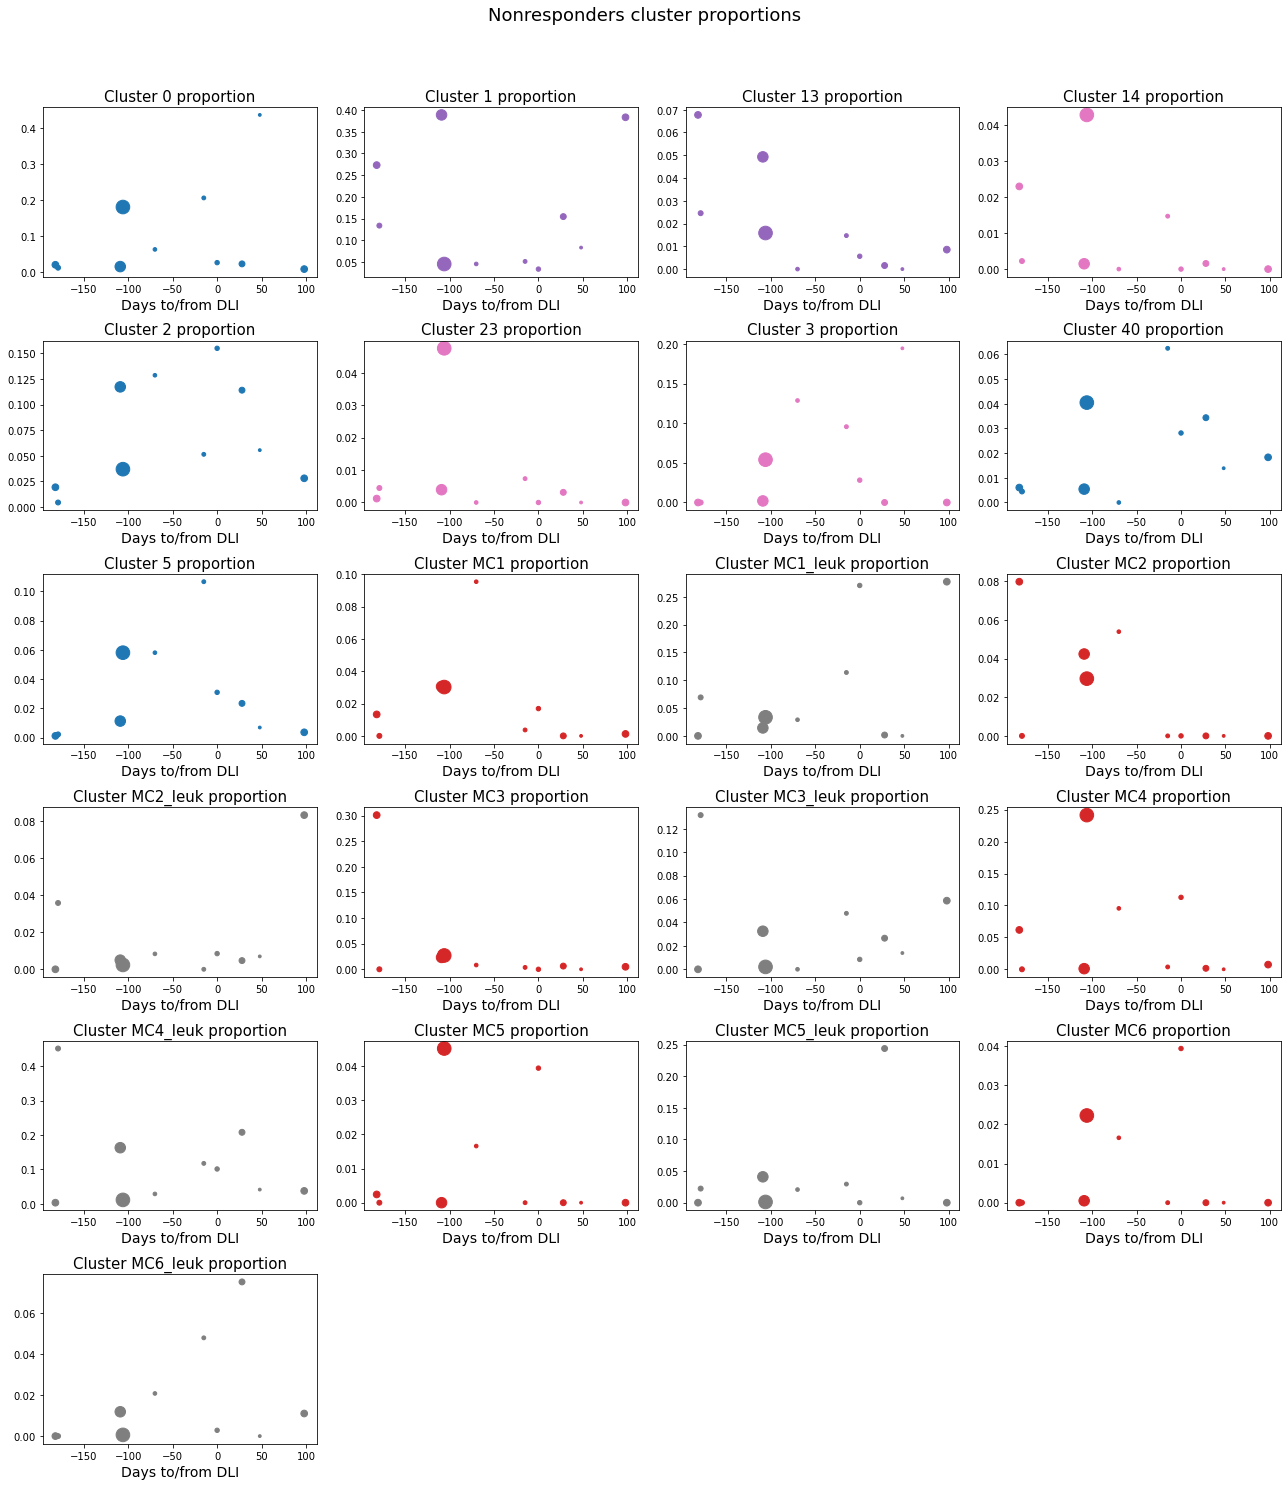

In [36]:
cells_per_sample = cells_df_nonresponders['sample'].value_counts(normalize=True)[sample_cluster_proportions_df['sample']]

plt.figure(figsize=(18, 20))
for i, cluster in enumerate(clusters_of_interest):
    color = colors[list(clusters_of_interest.values())[i]]
    plt.subplot(6, 4, i+1)
    plt.scatter(sample_cluster_proportions_df['days_to_DLI'], 
                sample_cluster_proportions_df[cluster], 
                s=cells_per_sample*500, 
                color=color)
    plt.title(f'Cluster {cluster} proportion', fontsize=15)
    plt.xlabel('Days to/from DLI', fontsize=14)
plt.suptitle(f'Nonresponders cluster proportions', y=1.03, fontsize=18)
plt.tight_layout()
plt.savefig('../../figures/AML/run_3/cell_type_proportions_NR.eps', bbox_inches='tight')

In [37]:
cluster_means = sample_cluster_proportions_df[clusters_of_interest].mean()
cluster_std_devs = sample_cluster_proportions_df[clusters_of_interest].std()
sample_cluster_proportions_df.loc[:, clusters_of_interest] -= cluster_means
sample_cluster_proportions_df.loc[:, clusters_of_interest] /= cluster_std_devs
sample_cluster_proportions_df

/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_68419/858897236.py:1: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  cluster_means = sample_cluster_proportions_df[clusters_of_interest].mean()
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_68419/858897236.py:2: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  cluster_std_devs = sample_cluster_proportions_df[clusters_of_interest].std()
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_68419/858897236.py:3: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  sample_cluster_proportions_df.loc[:, clusters_of_interest] -= cluster_means
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_68419/858897236.py:3: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a 

sample  days_to_DLI         0         1        13        14         2  \
8   JS1_         -182 -0.567943  0.815360  2.149606  1.003248 -0.980061   
7   GD3_         -179 -0.626649 -0.182271  0.253437 -0.442361 -1.262001   
5   GD1_         -109 -0.604188  1.642860  1.339964 -0.494881  0.875553   
1   AH2_         -106  0.587433 -0.815488 -0.129149  2.387757 -0.646175   
3   AM1_          -70 -0.260339 -0.814329 -0.825261 -0.597926  1.090218   
0   AH1_          -15  0.769761 -0.772609 -0.179196  0.426974 -0.371509   
4   AM2_            0 -0.524878 -0.899097 -0.577754 -0.597926  1.588426   
6   GD2_           28 -0.549814 -0.033652 -0.756616 -0.489031  0.814237   
2   AH3_           48  2.430765 -0.544495 -0.825261 -0.597926 -0.294123   
9   JS2_           98 -0.654149  1.603720 -0.449770 -0.597926 -0.814565   

         23         3        40  ...       MC2  MC2_leuk       MC3  MC3_leuk  \
8 -0.381935 -0.736685 -0.769311  ...  2.022389 -0.596720  2.831167 -0.794261   
7 -0.158080 -0.736685 -0.848729  ... -0.702601  0.783556 -0.401994  2.458438   
5 -0.193941 -0.707800 -0.800671  ...  0.744647 -0.406243 -0.153252  0.009139   
1  2.803933  0.054375  0.960337  ...  0.309324 -0.505997 -0.112111 -0.743530   
3 -0.465092  1.147988 -1.072889  ...  1.139243 -0.275992 -0.312880 -0.794261   
0  0.040574  0.663856  2.065352  ... -0.702601 -0.596720 -0.362515  0.386181   
4 -0.465092 -0.323958  0.341529  ... -0.702601 -0.270119 -0.401994 -0.585541   
6 -0.250184 -0.736685  0.653143  ... -0.702601 -0.415558 -0.334880 -0.138208   
2 -0.465092  2.112278 -0.375502  ... -0.702601 -0.328333 -0.401994 -0.451226   
9 -0.465092 -0.736685 -0.153258  ... -0.702601  2.612125 -0.349548  0.653268   

        MC4  MC4_leuk       MC5  MC5_leuk       MC6  MC6_leuk  
8  0.115994 -0.831701 -0.450124 -0.492065 -0.572393 -0.672990  
7 -0.662667  2.464490 -0.587126 -0.191355 -0.572393 -0.672990  
5 -0.650221  0.343811 -0.587126  0.059025 -0.536605 -0.204072  
1  2.386520 -0.771936  1.972780 -0.476253  1.046921 -0.649725  
3  0.542354 -0.644378  0.353129 -0.212566  0.632809  0.149481  
0 -0.616246  0.008584 -0.587126 -0.095835 -0.572393  1.221717  
4  0.760040 -0.111089  1.646974 -0.492065  2.291235 -0.561319  
6 -0.642938  0.673072 -0.587126  2.791688 -0.572393  2.300242  
2 -0.662667 -0.551366 -0.587126 -0.398510 -0.572393 -0.672990  
9 -0.570165 -0.579486 -0.587126 -0.492065 -0.572393 -0.237352  

[10 rows x 23 columns]

In [38]:
X = sample_cluster_proportions_df['days_to_DLI'].values.reshape(-1, 1)
X

array([[-182],
       [-179],
       [-109],
       [-106],
       [ -70],
       [ -15],
       [   0],
       [  28],
       [  48],
       [  98]])

In [39]:
Y = sample_cluster_proportions_df[clusters_of_interest].values
Y[:5]

/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_68419/2580917083.py:1: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  Y = sample_cluster_proportions_df[clusters_of_interest].values


array([[-0.5679425 ,  0.81536015,  2.1496058 ,  1.00324766, -0.98006061,
        -0.38193517, -0.73668466, -0.76931095, -0.84392911, -0.19840071,
        -0.75112621,  2.0223893 , -0.59671951,  2.83116735, -0.79426057,
         0.11599369, -0.83170072, -0.45012426, -0.49206452, -0.57239328,
        -0.67299013],
       [-0.62664922, -0.18227062,  0.25343674, -0.44236118, -1.26200071,
        -0.15808024, -0.73668466, -0.84872921, -0.81421379, -0.65101351,
        -0.10874938, -0.70260063,  0.78355567, -0.40199383,  2.45843847,
        -0.66266741,  2.46449006, -0.58712643, -0.19135459, -0.57239328,
        -0.67299013],
       [-0.60418836,  1.64286024,  1.33996373, -0.49488073,  0.87555265,
        -0.19394114, -0.70779988, -0.80067124, -0.5497704 ,  0.38878526,
        -0.61844112,  0.74464711, -0.40624289, -0.15325172,  0.00913933,
        -0.65022136,  0.34381066, -0.58712643,  0.05902459, -0.53660548,
        -0.2040723 ],
       [ 0.58743347, -0.81548809, -0.12914863,  2.38775677

Text(0.5, 1.02, 'Interaction prior variances for nonresponders based on receptor-ligand expression')

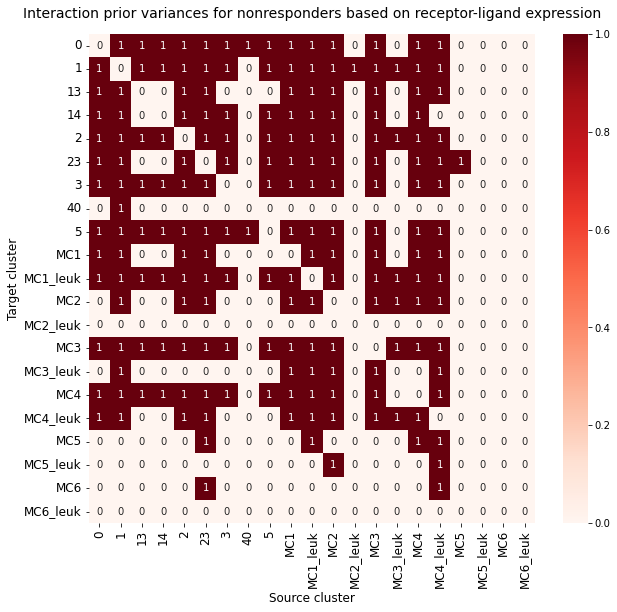

In [40]:
W_prior_variance = np.load('../../data/AML/nonresponder_interaction_prior_run_3.npy')

plt.figure(figsize=(10, 9))
ax = sns.heatmap(W_prior_variance, cmap="Reds", annot=True)
ax.set_yticklabels(clusters_of_interest, fontsize=12, rotation=0)
ax.set_xticklabels(clusters_of_interest, fontsize=12, rotation=90)
plt.xlabel('Source cluster', fontsize=12)
plt.ylabel('Target cluster', fontsize=12)
plt.title('Interaction prior variances for nonresponders based on receptor-ligand expression', 
          fontsize=14, y=1.02)

In [41]:
timepoints = torch.tensor(X)
proportions = torch.tensor(Y)
prior_matrix = torch.tensor(W_prior_variance)
n_timepoints, n_cell_types = proportions.shape

print('timepoints.shape:', timepoints.shape)
print('cell_types.shape:', proportions.shape)

timepoints.shape: torch.Size([10, 1])
cell_types.shape: torch.Size([10, 21])


In [42]:
def unscale(proportions, cluster_index): 
    return np.clip((proportions * 
                    cluster_std_devs.values[cluster_index] + 
                    cluster_means.values[cluster_index]), 
                   0, 1)

In [43]:
# mean of all intervals
lengthscale = np.mean(np.abs(X - X.T))
lengthscale

103.34

In [44]:
hyper_init_vals = {
    names.LENGTHSCALE_F: 100,
    names.LENGTHSCALE_W: 100,
    names.SIGMA_F: 1,
    names.VARIANCE_F: 10,
    names.SIGMA_W: 0.1,
    names.VARIANCE_W: 10,
    names.SIGMA_Y: 0.5,
}
print(hyper_init_vals)

{'lengthscale_f': 100, 'lengthscale_w': 100, 'sigma_f': 1, 'variance_f': 10, 'sigma_w': 0.1, 'variance_w': 10, 'sigma_y': 0.5}


In [19]:
model = DIISCO(lambda_matrix=prior_matrix, hypers_init_vals=hyper_init_vals, verbose=True, verbose_freq=100)

Text(0.5, 0.95, 'Independent GP fits to set $f_i$ latent functions')

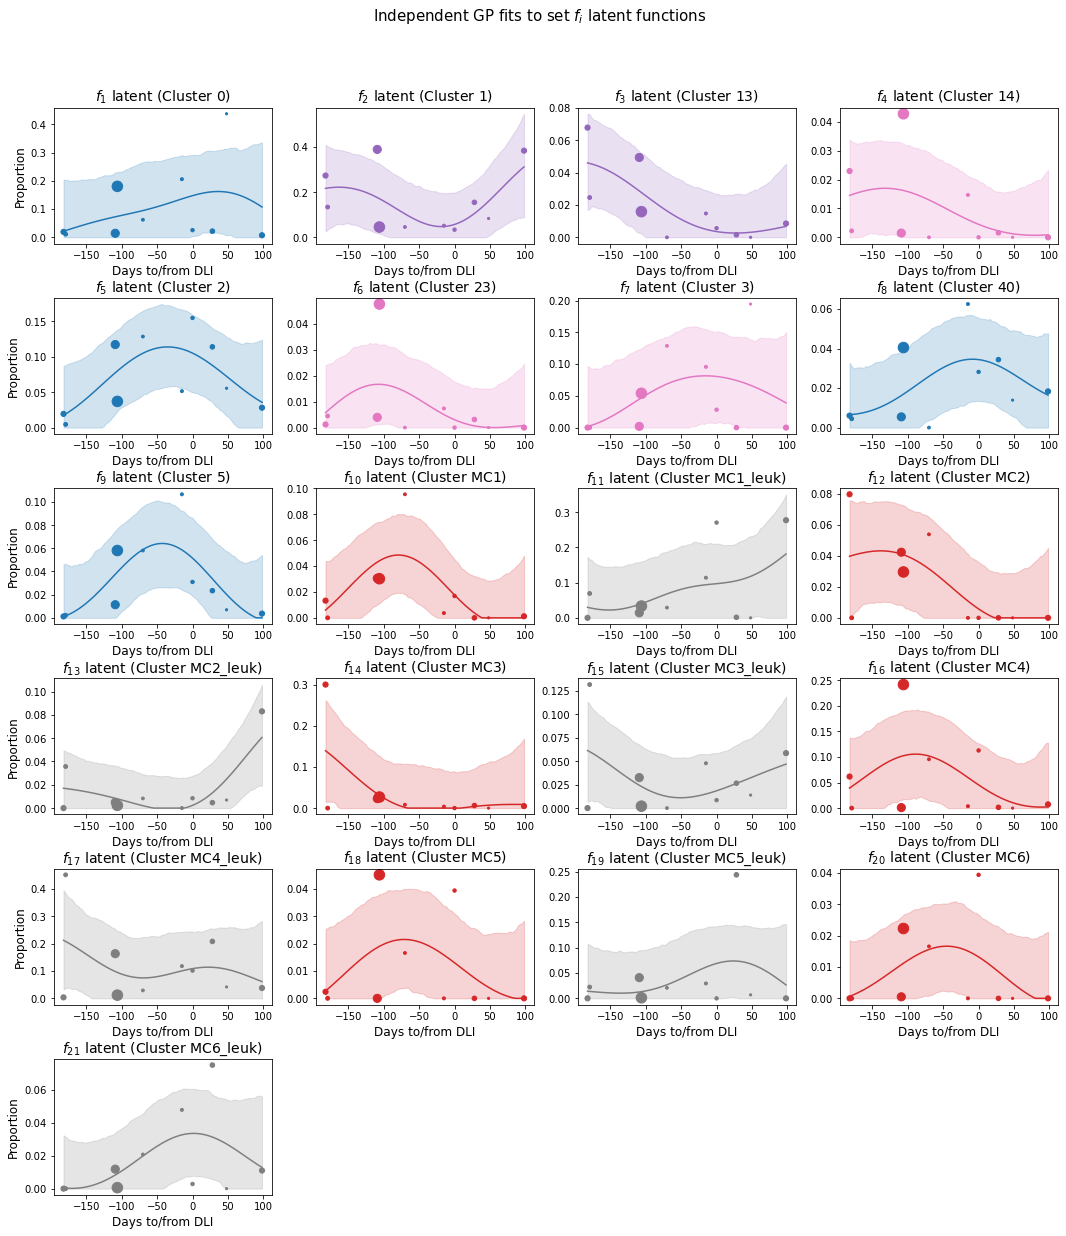

In [20]:
model.fit_and_set_f_prior_params(timepoints=timepoints, proportions=proportions, hypers=model.hypers_init_vals)
eval_timepoints = torch.linspace(timepoints.min(), timepoints.max(), 100).view(-1, 1)

n_samples = 1000
n_eval_timepoints = eval_timepoints.shape[0]
f_prior_np = model.sample_f_prior(eval_timepoints, n_samples=n_samples)

plt.figure(figsize=(18, 20))
for i, cluster in enumerate(clusters_of_interest):
    eval_timepoints_np = eval_timepoints.detach().numpy()
    f_prior_cell_type_np = f_prior_np[:, i, :].detach().numpy()
    mean = unscale(f_prior_cell_type_np.mean(axis=0), i)
    upper = unscale(np.percentile(f_prior_cell_type_np, 97.5, axis=0), i)
    lower = unscale(np.percentile(f_prior_cell_type_np, 2.5, axis=0), i)
    plt.subplot(6, 4, i+1)
    color = colors[list(clusters_of_interest.values())[i]]
#     color = 'tab:blue'
    plt.plot(eval_timepoints_np, mean, c=color)
    plt.scatter(timepoints, unscale(proportions[:, i].flatten().detach().numpy(), i), 
                c=color, s=cells_per_sample*300)
    plt.fill_between(eval_timepoints_np.flatten(), lower, upper, color=color, alpha=0.2)
    plt.title('$f_{%s}$ latent (Cluster %s)' % (i+1, cluster), fontsize=14)
    plt.xlabel('Days to/from DLI', fontsize=12)
    if i%4==0: plt.ylabel('Proportion', fontsize=12)
plt.subplots_adjust(hspace=0.4)
plt.suptitle('Independent GP fits to set $f_i$ latent functions', fontsize=15, y=0.95)

In [21]:
model.fit(timepoints, 
          proportions, 
          n_iter=300000, 
          lr=0.00001, 
          hypers_to_optim=[], 
          guide="MultivariateNormalFactorized")

[iteration 0001] loss: 2099043.1844
[iteration 0101] loss: 1398516.8898
[iteration 0201] loss: 1310557.9979
[iteration 0301] loss: 1259205.5067
[iteration 0401] loss: 1221848.1653
[iteration 0501] loss: 1190157.8539
[iteration 0601] loss: 1166600.6903
[iteration 0701] loss: 1146936.8291
[iteration 0801] loss: 1128512.2997
[iteration 0901] loss: 1112018.1397
[iteration 1001] loss: 1098297.9428
[iteration 1101] loss: 1084416.7790
[iteration 1201] loss: 1070851.8097
[iteration 1301] loss: 1061228.1892
[iteration 1401] loss: 1047511.6678
[iteration 1501] loss: 1037912.5896
[iteration 1601] loss: 1026263.2717
[iteration 1701] loss: 1018698.0084
[iteration 1801] loss: 1009571.0044
[iteration 1901] loss: 1002173.0477
[iteration 2001] loss: 995429.7066
[iteration 2101] loss: 989643.6100
[iteration 2201] loss: 979235.4581
[iteration 2301] loss: 971346.2935
[iteration 2401] loss: 964006.3534
[iteration 2501] loss: 954374.6992
[iteration 2601] loss: 950084.2971
[iteration 2701] loss: 947979.1662


[iteration 23001] loss: 459486.8844
[iteration 23101] loss: 458712.6828
[iteration 23201] loss: 462567.1928
[iteration 23301] loss: 460211.7392
[iteration 23401] loss: 456455.9702
[iteration 23501] loss: 455295.3145
[iteration 23601] loss: 456088.6726
[iteration 23701] loss: 453851.8650
[iteration 23801] loss: 455531.2171
[iteration 23901] loss: 455037.8356
[iteration 24001] loss: 450798.2087
[iteration 24101] loss: 453392.1644
[iteration 24201] loss: 452101.7440
[iteration 24301] loss: 451588.6850
[iteration 24401] loss: 450874.7605
[iteration 24501] loss: 451351.3535
[iteration 24601] loss: 449126.2096
[iteration 24701] loss: 449592.2095
[iteration 24801] loss: 448216.4139
[iteration 24901] loss: 447943.3801
[iteration 25001] loss: 448041.4384
[iteration 25101] loss: 446515.7843
[iteration 25201] loss: 448820.2432
[iteration 25301] loss: 446225.6587
[iteration 25401] loss: 443823.6310
[iteration 25501] loss: 443146.6657
[iteration 25601] loss: 444238.6150
[iteration 25701] loss: 4445

[iteration 45801] loss: 393337.7767
[iteration 45901] loss: 394859.2900
[iteration 46001] loss: 395241.9821
[iteration 46101] loss: 394938.1557
[iteration 46201] loss: 393878.3153
[iteration 46301] loss: 393948.6819
[iteration 46401] loss: 394058.5723
[iteration 46501] loss: 396855.0691
[iteration 46601] loss: 395715.2448
[iteration 46701] loss: 393526.0753
[iteration 46801] loss: 393018.2957
[iteration 46901] loss: 394309.2078
[iteration 47001] loss: 394561.7605
[iteration 47101] loss: 392214.0138
[iteration 47201] loss: 393534.6196
[iteration 47301] loss: 392378.3895
[iteration 47401] loss: 393107.7233
[iteration 47501] loss: 390413.9416
[iteration 47601] loss: 393429.6839
[iteration 47701] loss: 395174.0180
[iteration 47801] loss: 393195.8038
[iteration 47901] loss: 393267.8918
[iteration 48001] loss: 391592.5896
[iteration 48101] loss: 393216.6558
[iteration 48201] loss: 394708.8813
[iteration 48301] loss: 394003.5323
[iteration 48401] loss: 392421.6788
[iteration 48501] loss: 3923

[iteration 68601] loss: 373489.1804
[iteration 68701] loss: 373849.7119
[iteration 68801] loss: 373060.3424
[iteration 68901] loss: 372510.9482
[iteration 69001] loss: 374062.6390
[iteration 69101] loss: 373965.7074
[iteration 69201] loss: 375767.5865
[iteration 69301] loss: 374640.6971
[iteration 69401] loss: 374334.2287
[iteration 69501] loss: 373206.5027
[iteration 69601] loss: 373594.3105
[iteration 69701] loss: 371673.4599
[iteration 69801] loss: 374396.5910
[iteration 69901] loss: 375054.9495
[iteration 70001] loss: 373599.8854
[iteration 70101] loss: 372641.6342
[iteration 70201] loss: 374955.6728
[iteration 70301] loss: 374483.7456
[iteration 70401] loss: 374145.7029
[iteration 70501] loss: 374952.3122
[iteration 70601] loss: 374437.3315
[iteration 70701] loss: 371570.5188
[iteration 70801] loss: 374326.6572
[iteration 70901] loss: 372759.7511
[iteration 71001] loss: 376364.5648
[iteration 71101] loss: 375083.7594
[iteration 71201] loss: 375460.7626
[iteration 71301] loss: 3745

[iteration 91401] loss: 362985.6775
[iteration 91501] loss: 363667.4213
[iteration 91601] loss: 363257.9711
[iteration 91701] loss: 364628.0318
[iteration 91801] loss: 363376.6853
[iteration 91901] loss: 360214.7130
[iteration 92001] loss: 360453.3082
[iteration 92101] loss: 362409.1805
[iteration 92201] loss: 361522.1203
[iteration 92301] loss: 361202.3018
[iteration 92401] loss: 361400.3746
[iteration 92501] loss: 361917.8530
[iteration 92601] loss: 361674.1739
[iteration 92701] loss: 363200.3419
[iteration 92801] loss: 361057.1094
[iteration 92901] loss: 363731.0575
[iteration 93001] loss: 363417.1272
[iteration 93101] loss: 361623.7341
[iteration 93201] loss: 361138.7172
[iteration 93301] loss: 362670.4945
[iteration 93401] loss: 364423.9049
[iteration 93501] loss: 361744.7950
[iteration 93601] loss: 361559.6462
[iteration 93701] loss: 363033.1279
[iteration 93801] loss: 361429.4390
[iteration 93901] loss: 362358.1966
[iteration 94001] loss: 363095.0449
[iteration 94101] loss: 3628

[iteration 113801] loss: 354786.7012
[iteration 113901] loss: 355562.3905
[iteration 114001] loss: 351299.5462
[iteration 114101] loss: 354809.6307
[iteration 114201] loss: 353203.5276
[iteration 114301] loss: 353015.4819
[iteration 114401] loss: 354567.8463
[iteration 114501] loss: 353638.1126
[iteration 114601] loss: 356329.4987
[iteration 114701] loss: 353170.5834
[iteration 114801] loss: 354476.4497
[iteration 114901] loss: 353397.4238
[iteration 115001] loss: 354075.4773
[iteration 115101] loss: 354140.7582
[iteration 115201] loss: 353589.7555
[iteration 115301] loss: 355729.3288
[iteration 115401] loss: 353955.6701
[iteration 115501] loss: 354060.5601
[iteration 115601] loss: 354516.2533
[iteration 115701] loss: 354186.7821
[iteration 115801] loss: 354472.9289
[iteration 115901] loss: 354032.0992
[iteration 116001] loss: 353431.3858
[iteration 116101] loss: 351301.1701
[iteration 116201] loss: 356038.4823
[iteration 116301] loss: 354177.5623
[iteration 116401] loss: 353487.1005
[

[iteration 136001] loss: 348047.2495
[iteration 136101] loss: 347890.5002
[iteration 136201] loss: 347276.8773
[iteration 136301] loss: 347963.1372
[iteration 136401] loss: 345921.8139
[iteration 136501] loss: 348109.8686
[iteration 136601] loss: 348060.3195
[iteration 136701] loss: 346145.5684
[iteration 136801] loss: 348199.5240
[iteration 136901] loss: 346839.3705
[iteration 137001] loss: 346154.0991
[iteration 137101] loss: 348015.5353
[iteration 137201] loss: 347057.1308
[iteration 137301] loss: 347256.6054
[iteration 137401] loss: 348352.8575
[iteration 137501] loss: 346413.2826
[iteration 137601] loss: 346476.3208
[iteration 137701] loss: 347147.6291
[iteration 137801] loss: 345877.2846
[iteration 137901] loss: 350170.7948
[iteration 138001] loss: 347921.6507
[iteration 138101] loss: 346765.7045
[iteration 138201] loss: 347082.5928
[iteration 138301] loss: 348583.0239
[iteration 138401] loss: 347696.8916
[iteration 138501] loss: 346624.0583
[iteration 138601] loss: 347510.9235
[

[iteration 158201] loss: 345390.3156
[iteration 158301] loss: 344476.1397
[iteration 158401] loss: 342797.9939
[iteration 158501] loss: 342250.8655
[iteration 158601] loss: 340162.5112
[iteration 158701] loss: 340847.3097
[iteration 158801] loss: 343736.8157
[iteration 158901] loss: 340948.8002
[iteration 159001] loss: 343430.4886
[iteration 159101] loss: 342809.0732
[iteration 159201] loss: 343564.8485
[iteration 159301] loss: 343503.4812
[iteration 159401] loss: 342244.2967
[iteration 159501] loss: 343100.0025
[iteration 159601] loss: 342137.0946
[iteration 159701] loss: 344162.2182
[iteration 159801] loss: 340363.9747
[iteration 159901] loss: 344151.9147
[iteration 160001] loss: 343616.7952
[iteration 160101] loss: 341099.7668
[iteration 160201] loss: 342403.6516
[iteration 160301] loss: 343153.7805
[iteration 160401] loss: 341657.5545
[iteration 160501] loss: 341245.8499
[iteration 160601] loss: 342740.1625
[iteration 160701] loss: 341132.3942
[iteration 160801] loss: 341507.3814
[

[iteration 180401] loss: 340141.4567
[iteration 180501] loss: 336635.7129
[iteration 180601] loss: 336577.5828
[iteration 180701] loss: 336506.1643
[iteration 180801] loss: 337697.0570
[iteration 180901] loss: 337858.8550
[iteration 181001] loss: 336844.2643
[iteration 181101] loss: 338173.6710
[iteration 181201] loss: 339716.4660
[iteration 181301] loss: 338115.7622
[iteration 181401] loss: 338755.5925
[iteration 181501] loss: 337574.5441
[iteration 181601] loss: 338116.8071
[iteration 181701] loss: 340694.8152
[iteration 181801] loss: 337568.3474
[iteration 181901] loss: 337329.8218
[iteration 182001] loss: 337139.7933
[iteration 182101] loss: 339261.6965
[iteration 182201] loss: 338621.2377
[iteration 182301] loss: 338802.9840
[iteration 182401] loss: 338062.1599
[iteration 182501] loss: 337910.2091
[iteration 182601] loss: 337021.5929
[iteration 182701] loss: 337377.5215
[iteration 182801] loss: 338359.0965
[iteration 182901] loss: 338655.2321
[iteration 183001] loss: 338949.9144
[

[iteration 202601] loss: 334465.4542
[iteration 202701] loss: 335486.2441
[iteration 202801] loss: 335191.8723
[iteration 202901] loss: 332482.9023
[iteration 203001] loss: 332210.5408
[iteration 203101] loss: 333254.6734
[iteration 203201] loss: 333308.1378
[iteration 203301] loss: 335137.4968
[iteration 203401] loss: 334468.8603
[iteration 203501] loss: 334994.7098
[iteration 203601] loss: 332212.8552
[iteration 203701] loss: 334547.5392
[iteration 203801] loss: 335557.7774
[iteration 203901] loss: 333320.6130
[iteration 204001] loss: 334730.0861
[iteration 204101] loss: 332726.7041
[iteration 204201] loss: 332862.0773
[iteration 204301] loss: 335601.4397
[iteration 204401] loss: 333943.9325
[iteration 204501] loss: 330431.3533
[iteration 204601] loss: 332085.5306
[iteration 204701] loss: 335114.9236
[iteration 204801] loss: 335302.9022
[iteration 204901] loss: 335242.8098
[iteration 205001] loss: 335813.4921
[iteration 205101] loss: 335608.4876
[iteration 205201] loss: 333591.0289
[

[iteration 224801] loss: 331607.1853
[iteration 224901] loss: 331845.1956
[iteration 225001] loss: 332234.1482
[iteration 225101] loss: 331445.1877
[iteration 225201] loss: 329421.4626
[iteration 225301] loss: 333073.0665
[iteration 225401] loss: 331689.5807
[iteration 225501] loss: 330613.6247
[iteration 225601] loss: 329962.6877
[iteration 225701] loss: 329062.7296
[iteration 225801] loss: 331988.9277
[iteration 225901] loss: 329559.8188
[iteration 226001] loss: 332279.1983
[iteration 226101] loss: 329289.7698
[iteration 226201] loss: 332288.4443
[iteration 226301] loss: 330137.0506
[iteration 226401] loss: 330175.9436
[iteration 226501] loss: 332177.6883
[iteration 226601] loss: 329229.9143
[iteration 226701] loss: 329825.0404
[iteration 226801] loss: 332010.2347
[iteration 226901] loss: 330861.6079
[iteration 227001] loss: 330556.5153
[iteration 227101] loss: 332758.2640
[iteration 227201] loss: 333399.5922
[iteration 227301] loss: 330945.4207
[iteration 227401] loss: 332723.1504
[

[iteration 247001] loss: 328981.8899
[iteration 247101] loss: 327976.8229
[iteration 247201] loss: 328909.8119
[iteration 247301] loss: 328274.9993
[iteration 247401] loss: 329076.9512
[iteration 247501] loss: 328193.6532
[iteration 247601] loss: 328107.4469
[iteration 247701] loss: 326223.3136
[iteration 247801] loss: 326244.9414
[iteration 247901] loss: 328191.4788
[iteration 248001] loss: 328542.1756
[iteration 248101] loss: 326118.1094
[iteration 248201] loss: 327947.5004
[iteration 248301] loss: 327598.1117
[iteration 248401] loss: 327934.6918
[iteration 248501] loss: 329013.4850
[iteration 248601] loss: 328169.7309
[iteration 248701] loss: 326742.1743
[iteration 248801] loss: 327352.4592
[iteration 248901] loss: 326800.8651
[iteration 249001] loss: 328724.3505
[iteration 249101] loss: 327941.2327
[iteration 249201] loss: 326919.1813
[iteration 249301] loss: 326801.3163
[iteration 249401] loss: 327286.1070
[iteration 249501] loss: 327634.4721
[iteration 249601] loss: 327830.2801
[

[iteration 269201] loss: 325409.4123
[iteration 269301] loss: 324408.4408
[iteration 269401] loss: 325646.0152
[iteration 269501] loss: 328228.2681
[iteration 269601] loss: 325285.1162
[iteration 269701] loss: 325603.9354
[iteration 269801] loss: 325834.5057
[iteration 269901] loss: 326291.2420
[iteration 270001] loss: 323907.4164
[iteration 270101] loss: 323827.1375
[iteration 270201] loss: 325973.0275
[iteration 270301] loss: 324004.0410
[iteration 270401] loss: 326155.5286
[iteration 270501] loss: 326502.3654
[iteration 270601] loss: 329191.4605
[iteration 270701] loss: 325713.1963
[iteration 270801] loss: 325224.9491
[iteration 270901] loss: 325248.3026
[iteration 271001] loss: 325800.0002
[iteration 271101] loss: 326115.9328
[iteration 271201] loss: 326910.5225
[iteration 271301] loss: 324703.5491
[iteration 271401] loss: 329755.8595
[iteration 271501] loss: 324742.4145
[iteration 271601] loss: 323849.7806
[iteration 271701] loss: 325410.2837
[iteration 271801] loss: 324695.0951
[

[iteration 291401] loss: 324594.8693
[iteration 291501] loss: 324256.9724
[iteration 291601] loss: 322011.3748
[iteration 291701] loss: 322641.3653
[iteration 291801] loss: 324631.0586
[iteration 291901] loss: 323130.0558
[iteration 292001] loss: 322123.3265
[iteration 292101] loss: 322577.1615
[iteration 292201] loss: 322243.1014
[iteration 292301] loss: 322785.4175
[iteration 292401] loss: 322751.9354
[iteration 292501] loss: 323600.5534
[iteration 292601] loss: 324389.2521
[iteration 292701] loss: 323964.8883
[iteration 292801] loss: 321767.7257
[iteration 292901] loss: 323560.3776
[iteration 293001] loss: 325739.1754
[iteration 293101] loss: 324613.0043
[iteration 293201] loss: 323676.2144
[iteration 293301] loss: 323009.8457
[iteration 293401] loss: 322023.8278
[iteration 293501] loss: 325151.7418
[iteration 293601] loss: 323181.2613
[iteration 293701] loss: 323108.9742
[iteration 293801] loss: 324681.1514
[iteration 293901] loss: 324147.6855
[iteration 294001] loss: 321584.8908
[

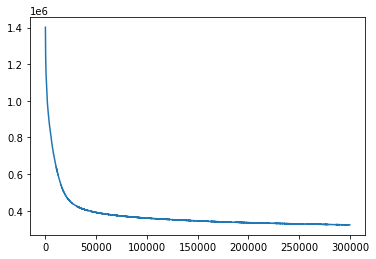

In [22]:
start = 50
loss_moving_avg = np.convolve(model.losses[start:], np.ones(100)/100, 'valid')
plt.plot(loss_moving_avg)

In [23]:
predict_timepoints = torch.linspace(timepoints.min(), timepoints.max(), 100).reshape(-1, 1)
means = model.get_means(predict_timepoints)

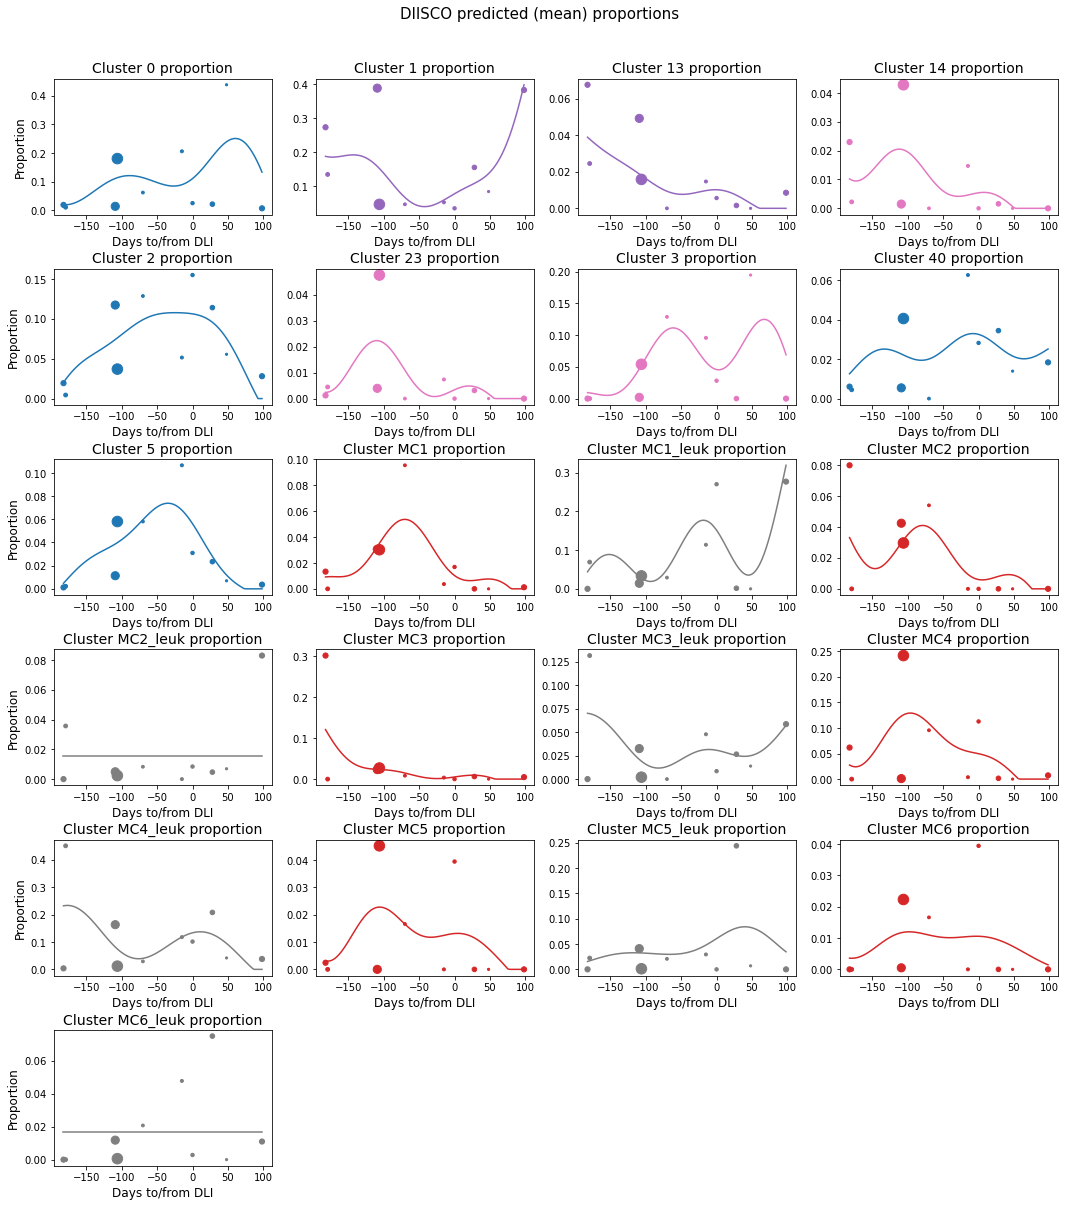

In [24]:
from mimic_alpha.mimic_alpha import colorAlpha_to_rgb
import matplotlib.colors as colors2

plt.figure(figsize=(18, 20))
for i, cluster in enumerate(clusters_of_interest):
    mean = unscale(means['Y'][:, i], i)
    x = predict_timepoints.squeeze().numpy()
    plt.subplot(6, 4, i+1)
    color = colors[list(clusters_of_interest.values())[i]]
    plt.plot(x, mean, c=color)
    plt.scatter(timepoints, unscale(proportions[:, i], i), c=color, s=cells_per_sample*300)
    plt.title(f'Cluster {cluster} proportion', fontsize=14)
    plt.xlabel('Days to/from DLI', fontsize=12)
    if i%4==0: plt.ylabel('Proportion', fontsize=12)
    
plt.suptitle('DIISCO predicted (mean) proportions', fontsize=15, y=0.93)
plt.subplots_adjust(hspace=0.4)

In [25]:
predict_timepoints = torch.linspace(timepoints.min(), timepoints.max(), 100).reshape(-1, 1)
samples = model.sample(predict_timepoints, 
                 n_samples=10000, 
                 n_samples_per_latent=10,
                 include_emission_variance=False)

100%|██████████████████████████████████████| 10000/10000 [06:16<00:00, 26.55it/s]


In [26]:
W_samples_predict = samples['W']
f_samples_predict = samples['F']
y_samples_predict = samples['Y']

In [27]:
y_preds = y_samples_predict.mean(axis=0).numpy()

np.save('../../data/AML/run_3_X_NR.npy', predict_timepoints.numpy())
np.save('../../data/AML/run_3_y_preds_NR.npy', y_preds)
np.save('../../data/AML/run_3_W_samples_predict_NR.npy', W_samples_predict)
np.save('../../data/AML/run_3_y_samples_predict_NR.npy', y_samples_predict)

In [45]:
predict_timepoints = np.load('../../data/AML/run_3_X_NR.npy')
y_preds = np.load('../../data/AML/run_3_y_preds_NR.npy')
W_samples_predict = np.load('../../data/AML/run_3_W_samples_predict_NR.npy')
y_samples_predict = np.load('../../data/AML/run_3_y_samples_predict_NR.npy')

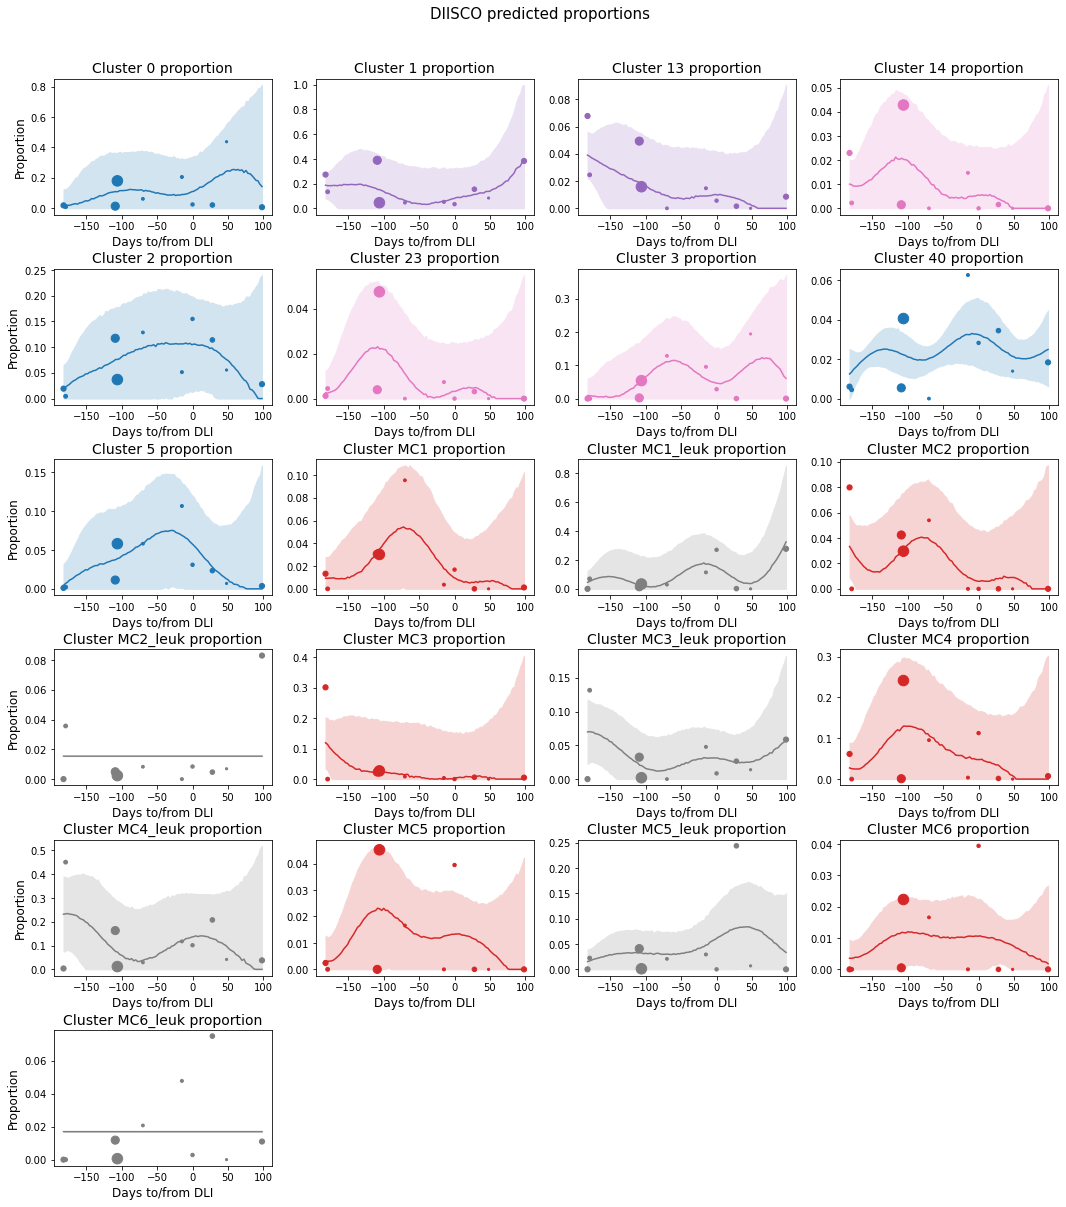

In [46]:
from mimic_alpha.mimic_alpha import colorAlpha_to_rgb
import matplotlib.colors as colors2

plt.figure(figsize=(18, 20))
for i, cluster in enumerate(clusters_of_interest):
    cell_type_samples = y_samples_predict[:, :, i]
    mean = unscale(cell_type_samples.mean(axis=0), i)
    x = predict_timepoints.squeeze()
    percentile_75 = unscale(np.percentile(cell_type_samples, 84, axis=0), i)
    percentile_25 = unscale(np.percentile(cell_type_samples, 16, axis=0), i)
    plt.subplot(6, 4, i+1)
    color = colors[list(clusters_of_interest.values())[i]]
    plt.plot(x, mean, c=color)
    color_with_alpha = list(colors2.to_rgb(color)) + [0.2]
    color_without_alpha = colorAlpha_to_rgb([color_with_alpha], 0.2)
    plt.fill_between(x, percentile_25, percentile_75, color=color_without_alpha)
    plt.scatter(timepoints, unscale(proportions[:, i], i), c=color, s=cells_per_sample*300)
    plt.title(f'Cluster {cluster} proportion', fontsize=14)
    plt.xlabel('Days to/from DLI', fontsize=12)
    if i%4==0: plt.ylabel('Proportion', fontsize=12)
    
plt.suptitle('DIISCO predicted proportions', fontsize=15, y=0.93)
plt.subplots_adjust(hspace=0.4)
plt.savefig('../../figures/AML/run_3/diisco_predictions_NR.eps')

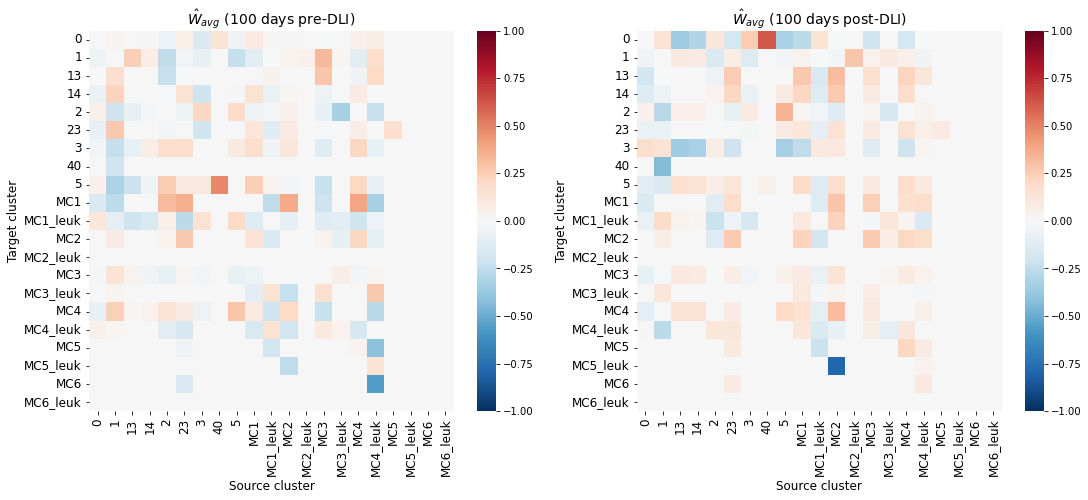

In [47]:
annot = False
vmin = -1
vmax = 1

X_100_days_pre_dli_index = np.where(predict_timepoints > -100)[0][0]
X_post_dli_index = np.where(predict_timepoints > 0)[0][0]
X_100_days_post_dli_index = np.where(predict_timepoints > 95)[0][0]
X_post_dli_index

W = W_samples_predict.mean(axis=0)
W_pre_dli = W[X_100_days_pre_dli_index:X_post_dli_index]
W_post_dli = W[X_post_dli_index:X_100_days_post_dli_index]
W_pre_dli_avg_over_time = np.mean(W_pre_dli, axis=0)
W_post_dli_avg_over_time = np.mean(W_post_dli, axis=0)

plt.figure(figsize=(18, 7))
plt.subplot(1, 2, 1)
ax = sns.heatmap(W_pre_dli_avg_over_time, cmap="RdBu_r", annot=annot, 
                 fmt='.2f', vmin=vmin, vmax=vmax, center=0)
ax.set_yticklabels(clusters_of_interest, fontsize=12)
ax.set_xticklabels(clusters_of_interest, fontsize=12)
plt.xlabel('Source cluster', fontsize=12)
plt.ylabel('Target cluster', fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.title('$\hat{W}_{avg}$ (100 days pre-DLI)', fontsize=14)

plt.subplot(1, 2, 2)
ax = sns.heatmap(W_post_dli_avg_over_time, cmap="RdBu_r", annot=annot, 
                 fmt='.2f', vmin=vmin, vmax=vmax, center=0)
ax.set_yticklabels(clusters_of_interest, fontsize=12)
ax.set_xticklabels(clusters_of_interest, fontsize=12)
plt.xlabel('Source cluster', fontsize=12)
plt.ylabel('Target cluster', fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.title('$\hat{W}_{avg}$ (100 days post-DLI)', fontsize=14)
plt.savefig('../../figures/AML/run_3/W_avg_pre_post_DLI_NR.eps')

In [48]:
y_samples_predict_unscaled = [unscale(y_samples_predict[:, :, i], i) 
                              for i in range(len(clusters_of_interest))]
y_samples_predict_unscaled = np.dstack(y_samples_predict_unscaled)
y_samples_predict_unscaled.shape

(10000, 100, 21)

In [49]:
y_mu = y_samples_predict_unscaled.mean(axis=0).mean(axis=0)
y_sigma = y_samples_predict_unscaled.std(axis=0).mean(axis=0)

y_mu_over_sigma = np.array(y_mu) / np.array(y_sigma)

(0.0, 2.0)

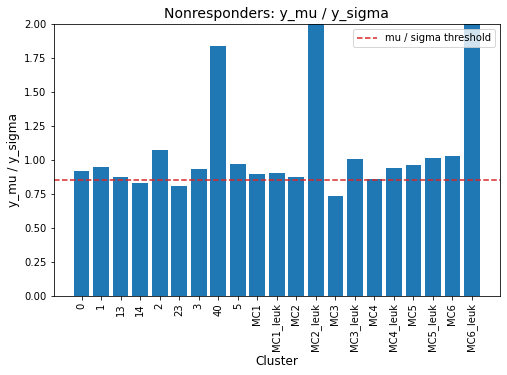

In [50]:
plt.figure(figsize=(8, 5))
mu_sigma_threshold = 0.85
plt.bar(range(len(y_mu_over_sigma)), y_mu_over_sigma)
plt.xticks(range(len(y_mu_over_sigma)), clusters_of_interest, rotation=90)
plt.axhline(mu_sigma_threshold, c='tab:red', linestyle='--', label='mu / sigma threshold')
plt.legend(loc='upper right')
plt.title("Nonresponders: y_mu / y_sigma", fontsize=14)
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("y_mu / y_sigma", fontsize=12)
plt.ylim([0, 2])

In [51]:
mean_abs_W_threshold = 0.3
max_abs_W_threshold = 1
mu_sigma_threshold = 0.85

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


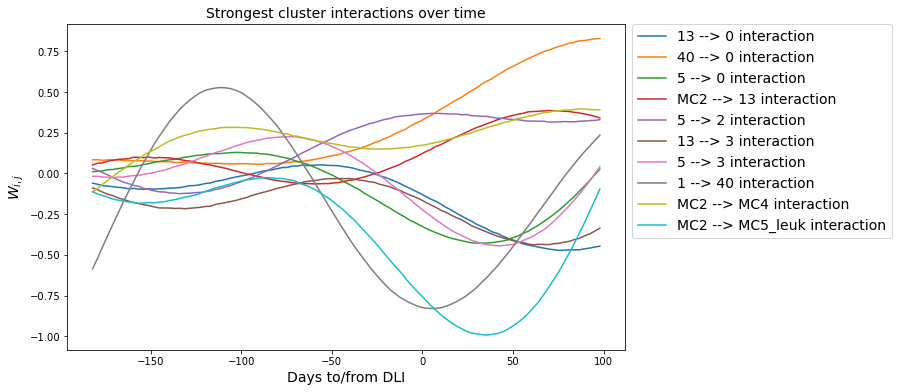

In [52]:
plt.figure(figsize=(10, 6))
linestyles = ['-', '--', ":"]
lines = 0
for i, cluster_i in enumerate(clusters_of_interest):
    for j, cluster_j in enumerate(clusters_of_interest):
        # a sustained strong interaction over the entire post-DLI time period
        sustained = np.abs(W_post_dli_avg_over_time[i, j]) > mean_abs_W_threshold
        # a transient strong interaction during the post-DLI time period
        transient = (np.abs(W_post_dli[:, i, j]) > max_abs_W_threshold).any()
        confident = (y_mu_over_sigma[i] > mu_sigma_threshold and
                     y_mu_over_sigma[j] > mu_sigma_threshold)
        show_line = (sustained or transient) and confident
        if show_line and i!= j:
            plt.plot(predict_timepoints.squeeze(),
                     W[:, i, j],
                     linestyle=linestyles[lines//10],
                     label='%s --> %s interaction' % (cluster_j, cluster_i))
            lines += 1
plt.legend(bbox_to_anchor=(1, 1.02), loc='upper left', fontsize=14)
plt.title('Strongest cluster interactions over time', fontsize=14)
plt.ylabel('$W_{i, j}$', fontsize=14)
plt.xlabel('Days to/from DLI', fontsize=14)
plt.savefig('../../figures/AML/run_3/W_over_time_NR_top_interactions.eps', bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


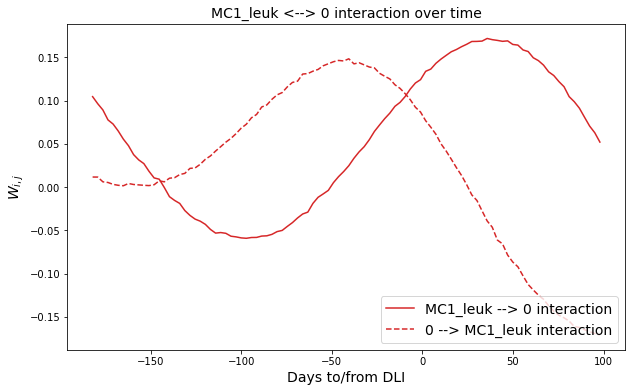

In [53]:
i = 0
j = 10
cluster_i = list(clusters_of_interest.keys())[i]
cluster_j = list(clusters_of_interest.keys())[j]

plt.figure(figsize=(10, 6))
plt.plot(predict_timepoints.squeeze(),
         W[:, i, j],
         linestyle='-',
         color='tab:red',
         label='%s --> %s interaction' % (cluster_j, cluster_i))
plt.plot(predict_timepoints.squeeze(),
         W[:, j, i],
         linestyle='--',
         color='tab:red',
         label='%s --> %s interaction' % (cluster_i, cluster_j))

plt.legend(loc='lower right', fontsize=14)
plt.title('MC1_leuk <--> 0 interaction over time', fontsize=14)
plt.ylabel('$W_{i, j}$', fontsize=14)
plt.xlabel('Days to/from DLI', fontsize=14)
plt.savefig('../../figures/AML/run_3/W_MC1_leuk_and_0_over_time_NR.eps', bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


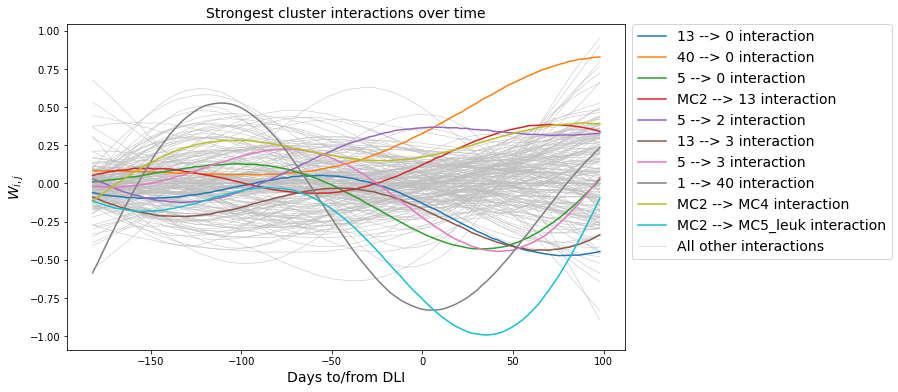

In [54]:
plt.figure(figsize=(10, 6))
linestyles = ['-', '--', ":"]
lines = 0
for i, cluster_i in enumerate(clusters_of_interest):
    for j, cluster_j in enumerate(clusters_of_interest):
        # a sustained strong interaction over the entire post-DLI time period
        sustained = np.abs(W_post_dli_avg_over_time[i, j]) > mean_abs_W_threshold
        # a transient strong interaction during the post-DLI time period
        transient = (np.abs(W_post_dli[:, i, j]) > max_abs_W_threshold).any()
        confident = (y_mu_over_sigma[i] > mu_sigma_threshold and
                     y_mu_over_sigma[j] > mu_sigma_threshold)
        show_line = (sustained or transient) and confident
        if show_line and i!= j:
            plt.plot(predict_timepoints.squeeze(), 
                     W[:, i, j],
                     linestyles[lines//10],
                     label='%s --> %s interaction' % (cluster_j, cluster_i))
            lines += 1
            
once = False
color = 'tab:gray'
color_with_alpha = list(colors2.to_rgb(color)) + [0.5]
color_without_alpha = colorAlpha_to_rgb([color_with_alpha], 0.5)
for i, cluster_i in enumerate(clusters_of_interest):
    for j, cluster_j in enumerate(clusters_of_interest):
        # a sustained strong interaction over the entire post-DLI time period
        sustained = np.abs(W_post_dli_avg_over_time[i, j]) > mean_abs_W_threshold
        # a transient strong interaction during the post-DLI time period
        transient = (np.abs(W_post_dli[:, i, j]) > max_abs_W_threshold).any()
        confident = (y_mu_over_sigma[i] > mu_sigma_threshold and
                     y_mu_over_sigma[j] > mu_sigma_threshold)
        show_line = (sustained or transient) and confident
        if not show_line and i != j:
            plt.plot(predict_timepoints.squeeze(), 
                     W[:, i, j],
                     color=color_without_alpha[0],
                     linewidth=0.5, zorder=-100,
                     label='All other interactions' if not once else '')
            once = True

plt.legend(bbox_to_anchor=(1, 1.02), loc='upper left', fontsize=14)
plt.title('Strongest cluster interactions over time', fontsize=14)
plt.ylabel('$W_{i, j}$', fontsize=14)
plt.xlabel('Days to/from DLI', fontsize=14)
plt.savefig('../../figures/AML/run_3/W_over_time_NR_all_interactions.eps', bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


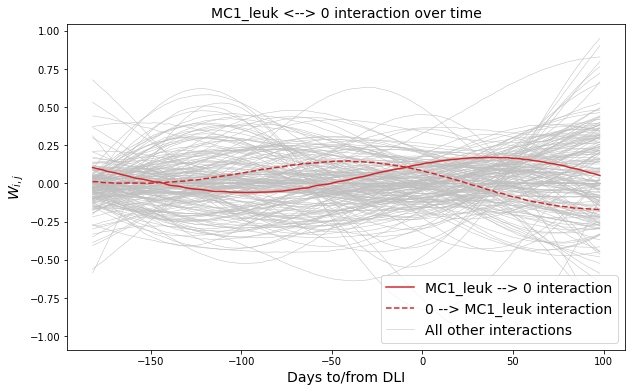

In [55]:
i = 0
j = 10
cluster_i = list(clusters_of_interest.keys())[i]
cluster_j = list(clusters_of_interest.keys())[j]

plt.figure(figsize=(10, 6))
plt.plot(predict_timepoints.squeeze(),
         W[:, i, j],
         linestyle='-',
         color='tab:red',
         label='%s --> %s interaction' % (cluster_j, cluster_i))
plt.plot(predict_timepoints.squeeze(),
         W[:, j, i],
         linestyle='--',
         color='tab:red',
         label='%s --> %s interaction' % (cluster_i, cluster_j))
            
once = False
color = 'tab:gray'
color_with_alpha = list(colors2.to_rgb(color)) + [0.5]
color_without_alpha = colorAlpha_to_rgb([color_with_alpha], 0.5)
for i, cluster_i in enumerate(clusters_of_interest):
    for j, cluster_j in enumerate(clusters_of_interest):
        # a sustained strong interaction over the entire post-DLI time period
        sustained = np.abs(W_post_dli_avg_over_time[i, j]) > mean_abs_W_threshold
        # a transient strong interaction during the post-DLI time period
        transient = (np.abs(W_post_dli[:, i, j]) > max_abs_W_threshold).any()
        confident = (y_mu_over_sigma[i] > mu_sigma_threshold and
                     y_mu_over_sigma[j] > mu_sigma_threshold)
        show_line = (sustained or transient) and confident
        if i != j:
            plt.plot(predict_timepoints.squeeze(), 
                     W[:, i, j],
                     color=color_without_alpha[0],
                     linewidth=0.5, zorder=-100,
                     label='All other interactions' if not once else '')
            once = True

plt.legend(loc='lower right', fontsize=14)
plt.title('MC1_leuk <--> 0 interaction over time', fontsize=14)
plt.ylabel('$W_{i, j}$', fontsize=14)
plt.xlabel('Days to/from DLI', fontsize=14)
plt.savefig('../../figures/AML/run_3/W_MC1_leuk_and_0_over_time_NR_all_interactions.eps', bbox_inches='tight')

In [83]:
W_pre_dli_avg_edge_list = []

for row, target_cluster in enumerate(clusters_of_interest.keys()):
    for col, source_cluster in enumerate(clusters_of_interest.keys()):
        sustained = np.abs(W_post_dli_avg_over_time[row, col]) > mean_abs_W_threshold
        transient = (np.abs(W_post_dli[:, row, col]) > max_abs_W_threshold).any()
        confident = (y_mu_over_sigma[row] > mu_sigma_threshold and
                     y_mu_over_sigma[col] > mu_sigma_threshold)
        show_edge = (sustained or transient) and confident
        W_pre_dli_avg_edge_list.append({
            'Source cluster': source_cluster,
            'Target cluster': target_cluster,
            'Interaction weight': W_pre_dli_avg_over_time[row, col],
            'abs(Interaction weight)': np.abs(W_pre_dli_avg_over_time[row, col]) * show_edge,
            'sign(Interaction weight)': np.sign(W_pre_dli_avg_over_time[row, col])
        })

W_pre_dli_avg_edge_list_df = pd.DataFrame(W_pre_dli_avg_edge_list)

W_avg_edge_list_df = W_pre_dli_avg_edge_list_df
W_avg_edge_list_df.columns = ['source', 'target', 'Interaction weight', 
                              'abs(Interaction weight)', 'sign(Interaction weight)']
W_avg_edge_list_df[['source', 'target']] = W_avg_edge_list_df[['source', 'target']].astype(str)
W_avg_edge_list_df = W_avg_edge_list_df[W_avg_edge_list_df['source'] != W_avg_edge_list_df['target']]
W_avg_edge_list_df.head()

source target  Interaction weight  abs(Interaction weight)  \
1      1      0            0.030264                 0.000000   
2     13      0            0.005065                 0.005065   
3     14      0            0.013490                 0.000000   
4      2      0           -0.055258                 0.000000   
5     23      0            0.060787                 0.000000   

   sign(Interaction weight)  
1                       1.0  
2                       1.0  
3                       1.0  
4                      -1.0  
5                       1.0

In [84]:
# y_preds = y_samples_predict.mean(axis=0).numpy()
y_preds_pre_dli = y_preds[X_100_days_pre_dli_index:X_post_dli_index]
y_preds_avg_pre_dli = y_preds_pre_dli.mean(axis=0)
y_preds_avg_pre_dli = [unscale(y, i) for i, y in enumerate(y_preds_avg_pre_dli)]
y_preds_avg_pre_dli_df = pd.DataFrame(y_preds_avg_pre_dli,
                                      index=clusters_of_interest, 
                                      columns=['Inferred cluster proportion'])

y_preds_avg_df = y_preds_avg_pre_dli_df.reset_index()
y_preds_avg_df.columns = ['id', 'Inferred cluster proportion']
y_preds_avg_df['id'] = y_preds_avg_df['id'].astype(str)
y_preds_avg_df

id  Inferred cluster proportion
0          0                     0.104598
1          1                     0.064907
2         13                     0.009628
3         14                     0.008955
4          2                     0.100711
5         23                     0.007549
6          3                     0.086719
7         40                     0.025403
8          5                     0.062859
9        MC1                     0.038205
10  MC1_leuk                     0.097968
11       MC2                     0.026201
12  MC2_leuk                     0.015440
13       MC3                     0.008270
14  MC3_leuk                     0.021587
15       MC4                     0.085306
16  MC4_leuk                     0.073362
17       MC5                     0.015124
18  MC5_leuk                     0.036632
19       MC6                     0.010750
20  MC6_leuk                     0.016976

In [85]:
# Reduce clutter by removing nodes without edges
not_connected_cluster_ids = []
for cluster in clusters_of_interest:
    sum_abs_interaction_weights = (
        W_avg_edge_list_df.loc[(W_avg_edge_list_df['source'] == str(cluster)) | 
                               (W_avg_edge_list_df['target'] == str(cluster)), 
                               'abs(Interaction weight)'].sum()
    )
    if sum_abs_interaction_weights == 0: 
        not_connected_cluster_ids.append(str(cluster))

        
# Remove nodes with less than 1% cluster proportion
clusters_with_low_prop = y_preds_avg_df.loc[y_preds_avg_df['Inferred cluster proportion'] < 0.00, 'id']
clusters_with_low_prop = []

clusters_to_remove = not_connected_cluster_ids + list(clusters_with_low_prop)
W_avg_edge_list_df = W_avg_edge_list_df[~(W_avg_edge_list_df['source'].isin(clusters_to_remove)) & 
                                        ~(W_avg_edge_list_df['target'].isin(clusters_to_remove))]
y_preds_avg_df = y_preds_avg_df[~(y_preds_avg_df['id'].isin(clusters_to_remove))]

In [86]:
# Add clusters from R interaction network diagram
clusters_to_add = {
    '20': 'B cell',
    '26': 'T cell',
    'MC3': 'Myeloid',
    'MC7': 'Myeloid',
    'MC1_leuk': 'AML'
}

proportions_pre_dli_df = sample_cluster_proportions_all_df[sample_cluster_proportions_all_df['days_to_DLI'] < 0]
proportions_pre_dli_df = proportions_pre_dli_df[clusters_to_add].mean().reset_index()
proportions_pre_dli_df.columns = ['id', 'Inferred cluster proportion']
y_preds_avg_df = pd.concat([y_preds_avg_df, proportions_pre_dli_df])
y_preds_avg_df = y_preds_avg_df.sort_values('id').reset_index(drop=True)

# Add a fake 0 interactions so that cluster shows up in network diagram
for cluster in clusters_to_add:
    W_avg_edge_list_df = W_avg_edge_list_df.append({
        'source': cluster, 
        'target': '0', 
        'Interaction weight': 0,
        'abs(Interaction weight)': 0,
        'sign(Interaction weight)': 1
    }, ignore_index=True)
    W_avg_edge_list_df = W_avg_edge_list_df.append({
        'source': cluster, 
        'target': '1', 
        'Interaction weight': 0,
        'abs(Interaction weight)': 0,
        'sign(Interaction weight)': 1
    }, ignore_index=True)

/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_66050/166039222.py:11: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  proportions_pre_dli_df = proportions_pre_dli_df[clusters_to_add].mean().reset_index()
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_66050/166039222.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W_avg_edge_list_df = W_avg_edge_list_df.append({
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_66050/166039222.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W_avg_edge_list_df = W_avg_edge_list_df.append({
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_66050/166039222.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versi

In [87]:
colors_hex = {
    'T cell': '#CBE0EE',
    'B cell': '#F9E0F2',
    'Myeloid': '#F8CECD',
    'AML': '#E1E1E1',
    'HSC': '#F8EBCB',
    'NK cell': '#E7DDF0'
}

clusters_to_colors_hex = [
    colors_hex[clusters_of_interest[cluster]] if cluster in clusters_of_interest
    else colors_hex[clusters_to_add[cluster]]
    for cluster in y_preds_avg_df['id']
]

# clusters_to_colors_hex = ['#CBE0EE' for cluster in y_preds_avg_df['id']]

Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
This file already exists. A Cytoscape popup will be generated to confirm overwrite.
This file already exists. A Cytoscape popup will be generated to confirm overwrite.


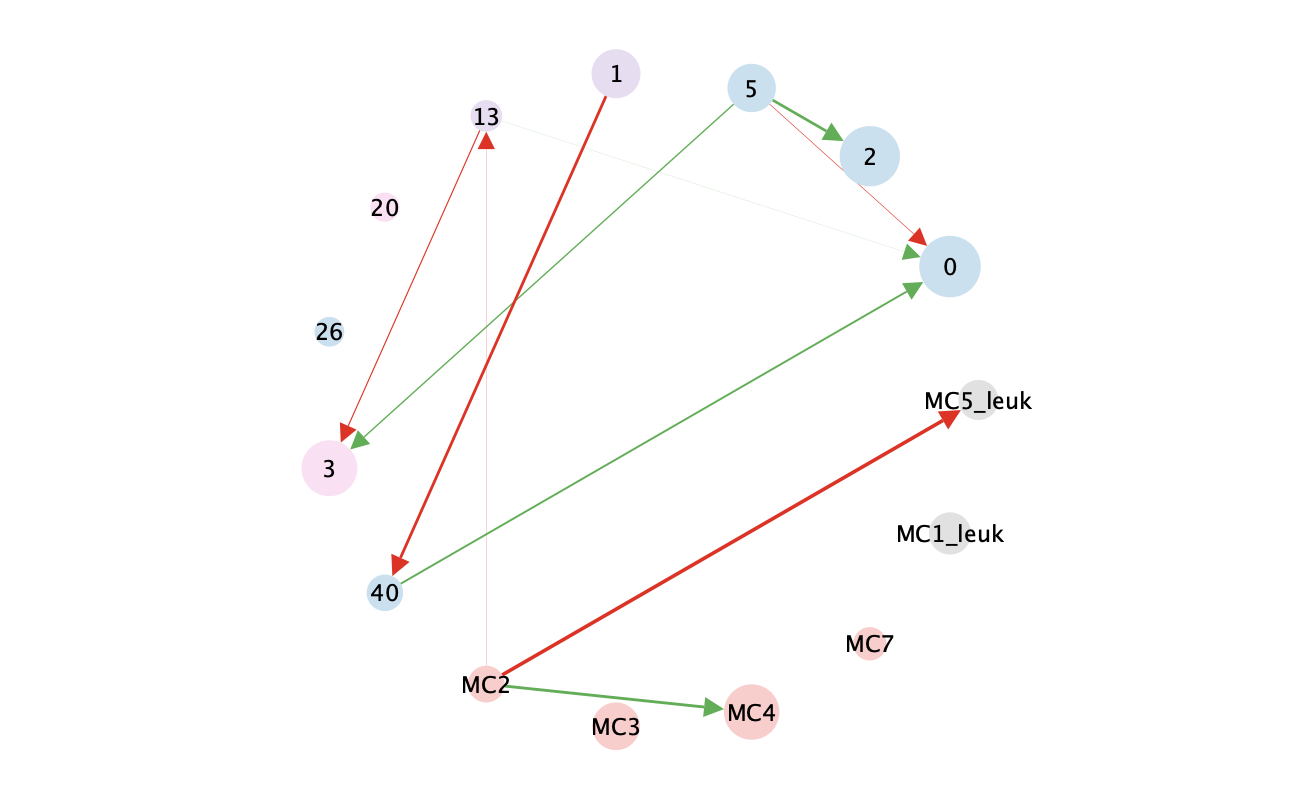

In [89]:
p4c.create_network_from_data_frames(nodes=y_preds_avg_df, 
                                    edges=W_avg_edge_list_df, 
                                    title="AML Non-responders Pre DLI", 
                                    collection="AML Non-responders Pre DLI")

# Default styles
p4c.layout_network('circular')
p4c.layout_copycat(source_network='AML Responders Pre DLI', 
                   target_network='AML Non-responders Pre DLI')
p4c.set_node_shape_default('ELLIPSE')
p4c.set_node_width_default(20)
p4c.set_node_height_default(20)
p4c.set_node_font_size_default(8)
p4c.set_edge_target_arrow_shape_default('DELTA_SHORT_1')

# Map style properties to node/edge attributes
p4c.set_node_color_mapping(table_column='shared name', 
                           table_column_values=list(y_preds_avg_df['id']), 
                           colors=clusters_to_colors_hex, 
                           mapping_type='d')
p4c.set_node_size_mapping(table_column='SUID',
                          table_column_values=list(p4c.get_table_columns()['SUID']),
                          sizes=list(p4c.get_table_columns()['Inferred cluster proportion'] * 110 + 10))
p4c.set_edge_color_mapping(table_column='sign(Interaction weight)',
                           table_column_values=[-1.0, 1.0],
                           colors=['#DB3427', '#63AD58'])
p4c.set_edge_target_arrow_color_mapping(table_column='sign(Interaction weight)',
                                        table_column_values=[-1.0, 1.0],
                                        colors=['#DB3427', '#63AD58'])
p4c.set_edge_line_width_mapping(table_column='abs(Interaction weight)', 
                                table_column_values=[W_avg_edge_list_df['abs(Interaction weight)'].min(), 
                                                     W_avg_edge_list_df['abs(Interaction weight)'].max()],
                                widths=[W_avg_edge_list_df['abs(Interaction weight)'].min() * 5, 
                                        W_avg_edge_list_df['abs(Interaction weight)'].max() * 5], 
                                mapping_type='c')
edges_to_hide = [f'{row.source} (interacts with) {row.target}' 
                 for i, row in W_avg_edge_list_df.iterrows()
                 if row['abs(Interaction weight)'] == 0]
p4c.hide_edges(edges_to_hide)

p4c.set_network_center_bypass(0, 0)
p4c.set_network_zoom_bypass(1.75)
p4c.export_image(f'../../figures/AML/run_3/interaction_network_NR_pre_avg.svg', type='SVG')
p4c.export_image(f'../../figures/AML/run_3/interaction_network_NR_pre_avg.png', type='PNG')
p4c.notebook_export_show_image()

In [90]:
W_post_dli_avg_edge_list = []

for row, target_cluster in enumerate(clusters_of_interest.keys()):
    for col, source_cluster in enumerate(clusters_of_interest.keys()):
        sustained = np.abs(W_post_dli_avg_over_time[row, col]) > mean_abs_W_threshold
        transient = (np.abs(W_post_dli[:, row, col]) > max_abs_W_threshold).any()
        confident = (y_mu_over_sigma[row] > mu_sigma_threshold and
                     y_mu_over_sigma[col] > mu_sigma_threshold)
        show_edge = (sustained or transient) and confident
        W_post_dli_avg_edge_list.append({
            'Source cluster': source_cluster,
            'Target cluster': target_cluster,
            'Interaction weight': W_post_dli_avg_over_time[row, col],
            'abs(Interaction weight)': np.abs(W_post_dli_avg_over_time[row, col]) * show_edge,
            'sign(Interaction weight)': np.sign(W_post_dli_avg_over_time[row, col])
        })
        
W_post_dli_avg_edge_list_df = pd.DataFrame(W_post_dli_avg_edge_list)

W_avg_edge_list_df = W_post_dli_avg_edge_list_df
W_avg_edge_list_df.columns = ['source', 'target', 'Interaction weight', 
                              'abs(Interaction weight)', 'sign(Interaction weight)']
W_avg_edge_list_df[['source', 'target']] = W_avg_edge_list_df[['source', 'target']].astype(str)
W_avg_edge_list_df = W_avg_edge_list_df[W_avg_edge_list_df['source'] != W_avg_edge_list_df['target']]
W_avg_edge_list_df.head()

source target  Interaction weight  abs(Interaction weight)  \
1      1      0            0.145465                 0.000000   
2     13      0           -0.361615                 0.361615   
3     14      0           -0.302819                 0.000000   
4      2      0            0.117445                 0.000000   
5     23      0           -0.176591                 0.000000   

   sign(Interaction weight)  
1                       1.0  
2                      -1.0  
3                      -1.0  
4                       1.0  
5                      -1.0

In [91]:
# y_preds = y_samples_predict.mean(axis=0).numpy()
y_preds_post_dli = y_preds[X_post_dli_index:X_100_days_post_dli_index]
y_preds_avg_post_dli = y_preds_post_dli.mean(axis=0)
y_preds_avg_post_dli = [unscale(y, i) for i, y in enumerate(y_preds_avg_post_dli)]
y_preds_avg_post_dli_df = pd.DataFrame(y_preds_avg_post_dli,
                                      index=clusters_of_interest, 
                                      columns=['Inferred cluster proportion'])

y_preds_avg_df = y_preds_avg_post_dli_df.reset_index()
y_preds_avg_df.columns = ['id', 'Inferred cluster proportion']
y_preds_avg_df['id'] = y_preds_avg_df['id'].astype(str)
y_preds_avg_df

id  Inferred cluster proportion
0          0                     0.203318
1          1                     0.164852
2         13                     0.003159
3         14                     0.000000
4          2                     0.068262
5         23                     0.000489
6          3                     0.088686
7         40                     0.024205
8          5                     0.018057
9        MC1                     0.004221
10  MC1_leuk                     0.103462
11       MC2                     0.004375
12  MC2_leuk                     0.015440
13       MC3                     0.000000
14  MC3_leuk                     0.031686
15       MC4                     0.007165
16  MC4_leuk                     0.085214
17       MC5                     0.006542
18  MC5_leuk                     0.070550
19       MC6                     0.007185
20  MC6_leuk                     0.016976

In [92]:
# Reduce clutter by removing nodes without edges
not_connected_cluster_ids = []
for cluster in clusters_of_interest:
    sum_abs_interaction_weights = (
        W_avg_edge_list_df.loc[(W_avg_edge_list_df['source'] == str(cluster)) | 
                               (W_avg_edge_list_df['target'] == str(cluster)), 
                               'abs(Interaction weight)'].sum()
    )
    if sum_abs_interaction_weights == 0: 
        not_connected_cluster_ids.append(str(cluster))

        
# Remove nodes with less than 1% cluster proportion
clusters_with_low_prop = y_preds_avg_df.loc[y_preds_avg_df['Inferred cluster proportion'] < 0.00, 'id']
clusters_with_low_prop = []

clusters_to_remove = not_connected_cluster_ids + list(clusters_with_low_prop)
W_avg_edge_list_df = W_avg_edge_list_df[~(W_avg_edge_list_df['source'].isin(clusters_to_remove)) & 
                                        ~(W_avg_edge_list_df['target'].isin(clusters_to_remove))]
y_preds_avg_df = y_preds_avg_df[~(y_preds_avg_df['id'].isin(clusters_to_remove))]

In [93]:
# Add clusters from R interaction network diagram
clusters_to_add = {
    '20': 'B cell',
    '26': 'T cell',
    'MC3': 'Myeloid',
    'MC7': 'Myeloid',
    'MC1_leuk': 'AML'
}

proportions_post_dli_df = sample_cluster_proportions_all_df[sample_cluster_proportions_all_df['days_to_DLI'] >= 0]
proportions_post_dli_df = proportions_post_dli_df[clusters_to_add].mean().reset_index()
proportions_post_dli_df.columns = ['id', 'Inferred cluster proportion']
y_preds_avg_df = pd.concat([y_preds_avg_df, proportions_post_dli_df])
y_preds_avg_df = y_preds_avg_df.sort_values('id').reset_index(drop=True)

# Add a fake 0 interactions so that cluster shows up in network diagram
for cluster in clusters_to_add:
    W_avg_edge_list_df = W_avg_edge_list_df.append({
        'source': cluster, 
        'target': '0', 
        'Interaction weight': 0,
        'abs(Interaction weight)': 0,
        'sign(Interaction weight)': 1
    }, ignore_index=True)
    W_avg_edge_list_df = W_avg_edge_list_df.append({
        'source': cluster, 
        'target': '5', 
        'Interaction weight': 0,
        'abs(Interaction weight)': 0,
        'sign(Interaction weight)': 1
    }, ignore_index=True)

/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_66050/3167887485.py:11: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  proportions_post_dli_df = proportions_post_dli_df[clusters_to_add].mean().reset_index()
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_66050/3167887485.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W_avg_edge_list_df = W_avg_edge_list_df.append({
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_66050/3167887485.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W_avg_edge_list_df = W_avg_edge_list_df.append({
/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_66050/3167887485.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future

Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
This file already exists. A Cytoscape popup will be generated to confirm overwrite.
This file already exists. A Cytoscape popup will be generated to confirm overwrite.


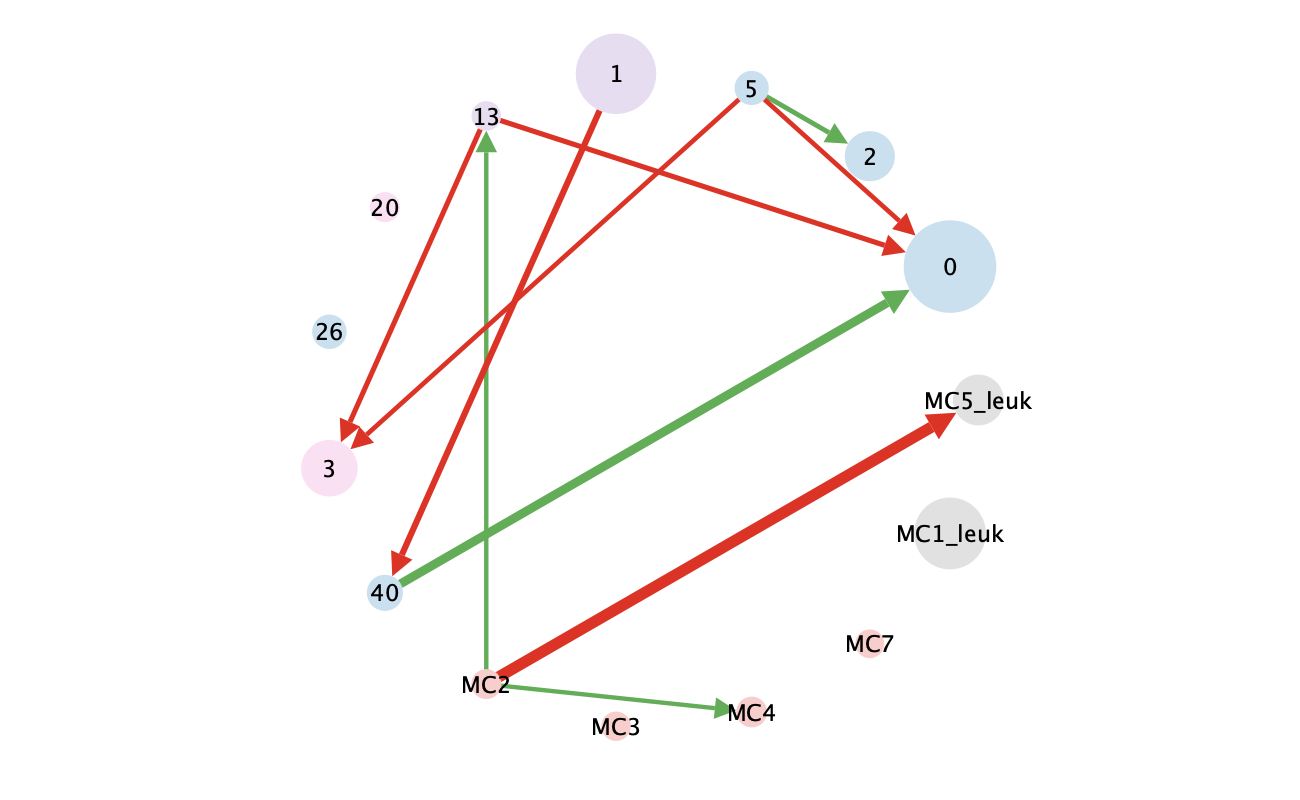

In [94]:
p4c.create_network_from_data_frames(nodes=y_preds_avg_df, 
                                    edges=W_avg_edge_list_df, 
                                    title="AML Non-responders Post DLI", 
                                    collection="AML Non-responders Post DLI")

# Default styles
p4c.layout_copycat(source_network='AML Responders Pre DLI', 
                   target_network='AML Non-responders Post DLI')
p4c.set_node_shape_default('ELLIPSE')
p4c.set_node_width_default(20)
p4c.set_node_height_default(20)
p4c.set_node_font_size_default(8)
p4c.set_edge_target_arrow_shape_default('DELTA_SHORT_1')

# Map style properties to node/edge attributes
p4c.set_node_color_mapping(table_column='shared name', 
                           table_column_values=list(y_preds_avg_df['id']), 
                           colors=clusters_to_colors_hex, 
                           mapping_type='d')
p4c.set_node_size_mapping(table_column='SUID',
                          table_column_values=list(p4c.get_table_columns()['SUID']),
                          sizes=list(p4c.get_table_columns()['Inferred cluster proportion'] * 110 + 10))
p4c.set_edge_color_mapping(table_column='sign(Interaction weight)',
                           table_column_values=[-1.0, 1.0],
                           colors=['#DB3427', '#63AD58'])
p4c.set_edge_target_arrow_color_mapping(table_column='sign(Interaction weight)',
                                        table_column_values=[-1.0, 1.0],
                                        colors=['#DB3427', '#63AD58'])
p4c.set_edge_line_width_mapping(table_column='abs(Interaction weight)', 
                                table_column_values=[W_avg_edge_list_df['abs(Interaction weight)'].min(), 
                                                     W_avg_edge_list_df['abs(Interaction weight)'].max()],
                                widths=[W_avg_edge_list_df['abs(Interaction weight)'].min() * 5, 
                                        W_avg_edge_list_df['abs(Interaction weight)'].max() * 5], 
                                mapping_type='c')
edges_to_hide = [f'{row.source} (interacts with) {row.target}' 
                 for i, row in W_avg_edge_list_df.iterrows()
                 if row['abs(Interaction weight)'] == 0]
p4c.hide_edges(edges_to_hide)

p4c.set_network_center_bypass(0, 0)
p4c.set_network_zoom_bypass(1.75)
p4c.export_image(f'../../figures/AML/run_3/interaction_network_NR_post_avg.svg', type='SVG')
p4c.export_image(f'../../figures/AML/run_3/interaction_network_NR_post_avg.png', type='PNG')
p4c.notebook_export_show_image()

In [95]:
# interactions_over_time_summary = []

# for i, cluster_i in enumerate(clusters_of_interest):
#     for j, cluster_j in enumerate(clusters_of_interest):
#         # a sustained strong interaction over the entire post-DLI time period
#         sustained = np.abs(W_post_dli_avg_over_time[i, j]) > mean_abs_W_threshold
#         # a transient strong interaction during the post-DLI time period
#         transient = (np.abs(W_post_dli[:, i, j]) > max_abs_W_threshold).any()
#         interactions_over_time_summary.append({
#             'Source': cluster_j,
#             'Target': cluster_i,
#             'W_abs_val_post_dli_max': np.max(np.abs(W_post_dli[:, i, j])),
#             f'Transient (W_abs_val_post_dli_max > {max_abs_W_threshold})': transient,
#             'W_abs_val_post_dli_avg': np.abs(W_post_dli_avg_over_time[i, j]),
#             f'Sustained (W_abs_val_post_dli_avg > {mean_abs_W_threshold})': sustained,
#             'Transient OR Sustained': transient or sustained
#         })

# interactions_over_time_summary_df = pd.DataFrame(interactions_over_time_summary)
# interactions_over_time_summary_df = interactions_over_time_summary_df.\
#                                         sort_values(['Transient OR Sustained', 
#                                                      'W_abs_val_post_dli_max'], 
#                                                     ascending=False)

# interactions_over_time_summary_df.to_csv('../../data/AML/AML_R_interactions_over_time_summary.csv', 
#                                          index=False)
# interactions_over_time_summary_df.head()